<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/AirFrance/AirFrance_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "AF.PA"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High   Low  Close  Adj Close   Volume
Date                                                     
2009-01-02   9.38   9.80  9.06   9.80       9.58  1419568
2009-01-05   9.89  10.03  9.77  10.00       9.77  1756012
2009-01-06  10.00  10.05  9.85   9.95       9.73  1441376
2009-01-07   9.92   9.94  9.74   9.87       9.65  1656512
2009-01-08   9.76   9.82  9.53   9.66       9.44  1798384
...           ...    ...   ...    ...        ...      ...
2018-12-21   9.12   9.55  9.08   9.39       9.39  5647594
2018-12-24   9.31   9.42  9.01   9.13       9.13  1484141
2018-12-27   9.20   9.34  8.94   9.04       9.04  2731985
2018-12-28   9.01   9.39  9.01   9.36       9.36  2654662
2018-12-31   9.42   9.57  9.40   9.48       9.48  1042316

[2556 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2.556000e+03
mean      8.386694     8.522899     8.238815     8.378490     8.348568  3.489851e+06
std       2.663198     2.695818     2.633117     2.664614     2.643339  2.020676e+06
min       3.090000     3.140000     3.010000     3.060000     3.060000  0.000000e+00
25%       6.530000     6.650000     6.420000     6.530000     6.527500  2.203118e+06
50%       7.950000     8.090000     7.795000     7.950000     7.940000  3.064608e+06
75%      10.522500    10.730000    10.310000    10.520000    10.445000  4.127165e+06
max      15.100000    15.300000    14.930000    15.110000    15.110000  2.242723e+07

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open  High   Low  Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08    SMA_8    TEMA_8  TRIMA_8     WMA_8   MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  BBANDS_lowerband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
2009-03-13  7.15  7.18  6.87   6.95       6.79  1589142   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  6.837373  7.014645  6.261580  6.819084  6.887423  6.999529       6.710       6.745  6.381280  6.75125  6.933182   6.6905  6.813333  6.75125  6.990000  7.138198                7.312181                  6.75125                6.190319                7.592647                  6.75125                5.909853                7.873112                  6.75125                5.629388                8.153578                  6.75125                5.348922  6.887423  6.931037  7.075024                7.448354                 6.887423                6.326492                7.728820                 6.887423                6.046026                8.009285                 6.887423                5.765561                8.289751                 6.887423                5.485095   
2009-03-16  7.16  7.31  7.00   7.18       7.02  1426640   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  6.854505  7.010642  6.281748  6.949857  6.952440  7.001636       6.770       6.765  6.452378  6.76625  7.089742   6.7840  6.908611  6.76625  7.065000  7.097492                7.364576                  6.76625                6.167924                7.663739                  6.76625                5.868761                7.962902                  6.76625                5.569598                8.262064                  6.76625                5.270436  6.952440  7.105137  7.039214                7.550766                 6.952440                6.354114                7.849929                 6.952440                6.054951                8.149092                 6.952440                5.755789                8.448255                 6.952440                5.456626   
2009-03-17  7.12  7.17  

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2.506000e+03  2506.000000  2506.000000  2506.000000    2506.000000   2506.000000     2506.000000     2506.000000       2506.000000  2506.000000  2506.000000  2506.000000  2506.000000   2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000   
mean      8.394266     8.529425     8.248097     8.386860     8.359968  3.505248e+06    15.766959     1.999202   186.043496      30.462889      0.032721        0.028332        0.009976          0.007981     6.619314     2.538707    27.001197     1.999202      2.015563    27.001197     8.387541     8.382428    -0.352868     8.386705     8.383460     8.401050     8.384336     8.383460     8.382659     8.383338     8.386926     8.383376     8.384548     8.383338     8.386537     8.377191                8.821323                 8.383338                7.945354                9.040315                 8.383338                7.726362                9.259307                 8.383338                7.507370                9.478299                 8.383338                7.288378     8.383460     8.386268     8.378047                8.821444                 8.383460                7.945475                9.040436                 8.383460                7.726483                9.259428   
std       2.684742     2.717934     2.654219     2.686188     2.664280  2.030745e+06     8.737921     1.407706   103.562746       0.785865      0.177942        0.165953        0.099401          0.088996     3.394067     1.106097    14.812238     1.407706      1.412857    14.812238     2.679581     2.653367     8.822948     2.693078     2.667897     2.652167     2.669152     2.667087     2.693816     2.674537     2.689336     2.677330     2.676363     2.674537     2.684003     2.650544                2.789588                 2.674537                2.580815                2.854324                 2.674537                2.542710                2.923449                 2.674537                2.510810                2.996660                 2.674537                2.485354     2.667897     2.681735     2.654297                2.782683                 2.667897                2.574514                2.847313                 2.667897                2.536610                2.916348   
min       3.090000     3.140000     3.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-13  0.338052  0.332237  0.323826  0.322822   0.309544  1589142   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.319710  0.335617  0.725620  0.310775  0.320123  0.329645    0.299742    0.301553  0.274311  0.305098  0.319456  0.300744  0.311838  0.305098  0.326223  0.344477                0.320618                 0.305098                0.287330                0.325306                 0.305098                0.281919                0.330865                 0.305098                0.276554                0.325580                 0.305098                0.271234  0.320123  0.322844  0.338462                0.332910                 0.320123                0.296153                0.339108                 0.320123                0.290581                0.346289                 0.320123                0.285056                0.342684                 0.320123   
2009-03-16  0.338884  0.342928  0.334732  0.341909   0.328631  1426640   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.321209  0.335252  0.726299  0.321797  0.325789  0.329834    0.304910    0.303279  0.280096  0.306391  0.332478  0.308746  0.320018  0.306391  0.332497  0.340801                0.324922                 0.306391                0.285397                0.330917                 0.306391                0.278387                0.337674                 0.306391                0.271437                0.333250                 0.306391                0.264545  0.325789  0.337495  0.335244                0.341374                 0.325789                0.298592                0.348788                 0.325789                0.291365                0.357085                 0.325789                0.284201                0.354176                 0.325789   
2009-03-17  0.335554  0.331414  0.328859  0.332780  

139982

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpkw_f_dyw
  JVM stdout: /tmp/tmpkw_f_dyw/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpkw_f_dyw/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         03 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 7 days
H2O cluster name:           H2O_from_python_unknownUser_u9faeb
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_193555_mod...  0.760541  0.584244              0.304928  0.447354  0.200126
1  DeepLearning_grid_1_AutoML_20190826_193555_mod...  0.759271  0.611344              0.321438  0.451037  0.203434
2  DeepLearning_grid_1_AutoML_20190826_193555_mod...  0.755334  0.647016              0.301181  0.465524  0.216713
3  DeepLearning_grid_1_AutoML_20190826_193555_mod...  0.750254  0.601174              0.325375  0.451968  0.204275
4  DeepLearning_grid_1_AutoML_20190826_193555_mod...  0.740030  0.606535              0.284004  0.456733  0.208605
5  DeepLearning_grid_1_AutoML_20190826_193555_mod...  0.724028  0.621745              0.312611  0.462303  0.213724
6  DeepLearning_grid_1_AutoML_20190826_193555_mod...  0.722473  2.205543              0.332963  0.534387  0.285569
7  DeepLearning_grid_1_AutoML_20190826_193555_mod...  0.705169  1.022918              0.393923  0.514841  0.265061
8  DeepLearning_grid_1_AutoML_20190826_193555_mod...  0.673927  0.694392              0.381731  0.490075  0.240173
9              DeepLearning_1_AutoML_20190826_193555  0.631350  0.822375              0.422911  0.514584  0.264796

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.010211
1           CDLCLOSINGMARUBOZU             0.674070           0.674070    0.006883
2                  CDLLONGLINE             0.612119           0.612119    0.006250
3                          SUB             0.437828           0.437828    0.004471
4                  CDLBELTHOLD             0.432201           0.432201    0.004413
...                        ...                  ...                ...         ...
1035   BBANDS_middleband_8_4_2             0.068321           0.068321    0.000698
1036                     SMA_8             0.068263           0.068263    0.000697
1037  BBANDS_middleband_12_7_4             0.068211           0.068211    0.000697
1038                   KAMA_12             0.067603           0.067603    0.000690
1039   BBANDS_middleband_8_8_4             0.067099           0.067099    0.000685

[1040 rows x 4 columns]

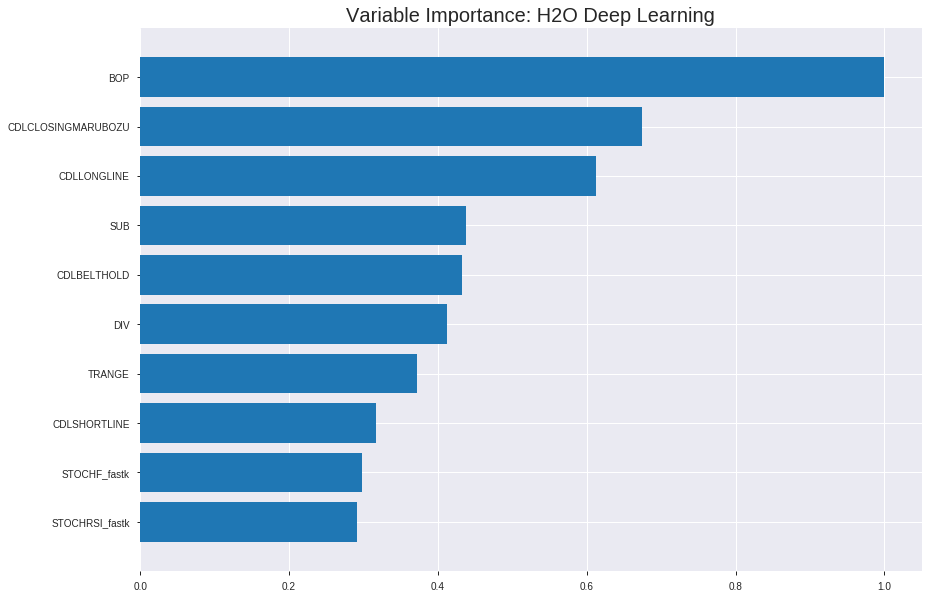

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_193555_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1895279133341178
RMSE: 0.43534803701649766
LogLoss: 0.560960134007974
Mean Per-Class Error: 0.25879218033051565
AUC: 0.8052497877637328
pr_auc: 0.7947772040606309
Gini: 0.6104995755274656
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4841981319480134: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      536  325   0.3775   (325.0/861.0)
1      140  752   0.157    (140.0/892.0)
Total  676  1077  0.2653   (465.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.484198     0.76384   211
max f2                       0.311523     0.854336  301
max f0point5                 0.571953     0.746203  148
max accuracy                 0.502459     0.742156  198
max precision                0.930322     1         0
max recall                   0.11045      1         372
max specificity              0.930322     1         0
max absolute_mcc             0.499196     0.485659  200
max min_per_class_accuracy   0.517521     0.725336  187
max mean_per_class_accuracy  0.502459     0.741208  198

Gains/Lift Table: Avg response rate: 50.88 %, avg score: 50.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.852373           1.85607   1.85607            0.944444         0.877989  0.944444                    0.877989            0.0190583       0.0190583                  85.6066   85.6066
    2        0.0205362                   0.828716           1.85607   1.85607            0.944444         0.839194  0.944444                    0.858591            0.0190583       0.0381166                  85.6066   85.6066
    3        0.0302339                   0.815141           1.61844   1.77985            0.823529         0.821911  0.90566                     0.846826            0.0156951       0.0538117                  61.8438   77.9846
    4        0.040502                    0.800886           1.96525   1.82685            1                0.806587  0.929577                    0.836625            0.0201794       0.073991                   96.5247   82.6849
    5        0.0501997                   0.786013           1.73404   1.80892            0.882353         0.792342  0.920455                    0.82807             0.0168161       0.0908072                  73.4041   80.892
    6        0.100399                    0.73401            1.67493   1.74192            0.852273         0.757624  0.886364                    0.792847            0.0840807       0.174888                   67.4926   74.1923
    7        0.150029                    0.69712            1.53605   1.67382            0.781609         0.713775  0.851711                    0.76669             0.0762332       0.251121                   53.6055   67.3822
    8        0.200228                    0.666317           1.63026   1.6629             0.829545         0.681008  0.846154                    0.745209            0.0818386       0.33296                    63.0261   66.2901
    9        0.300057                    0.602155           1.54974   1.62525            0.788571         0.634355  0.826996                    0.708328            0.154709        0.487668                   54.9737   62.5251
    10       0.399886                    0.555114           1.25776   1.53351            0.64             0.577478  0.780314                    0.675662            0.125561        0.613229                   25.7758   53.3509
    11       0.500285                    0.517526           1.10545   1.4476             0.5625           0.536117  0.736602                    0.647657            0.110987        0.724215                   10.5451   44.7605
    12       0.600114                    0.49005            1.0107    1.37493            0.514286         0.503958  0.69962                     0.623753            0.100897        0.825112                   1.06983   37.4925
    13       0.699943                    0.445612           0.617649  1.26692            0.314286         0.468667  0.644662                    0.601634            0.0616592       0.886771                   -38.2351  26.6919
    14       0.799772                    0.352192           0.595189  1.18307            0.302857         0.403796  0.601997                    0.57694             0.059417        0.946188                   -40.4811  18.3073
    15       0.899601                    0.218223           0.303209  1.08543            0.154286         0.291479  0.552315                    0.545262            0.0302691       0.976457                   -69.6791  8.54343
    16       1                           0.0134407          0.23449   1                  0.119318         0.129105  0.508842                    0.50348           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2098169852744469
RMSE: 0.458057840533755
LogLoss: 0.6079885844603675
Mean Per-Class Error: 0.3141265725535388
AUC: 0.7371154646435545
pr_auc: 0.7335323869719477
Gini: 0.47423092928710897
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4072708131974866: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      84   150  0.641    (150.0/234.0)
1      24   243  0.0899   (24.0/267.0)
Total  108  393  0.3473   (174.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.407271     0.736364  303
max f2                       0.224833     0.857795  364
max f0point5                 0.535194     0.711297  186
max accuracy                 0.535194     0.682635  186
max precision                0.862672     1         0
max recall                   0.0561139    1         395
max specificity              0.862672     1         0
max absolute_mcc             0.535194     0.371955  186
max min_per_class_accuracy   0.523291     0.670412  200
max mean_per_class_accuracy  0.535194     0.685873  186

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 51.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.826789           1.56367   1.56367            0.833333         0.842328  0.833333                    0.842328            0.0187266       0.0187266                  56.367    56.367
    2        0.0219561                   0.814341           1.50112   1.53524            0.8              0.819043  0.818182                    0.831744            0.0149813       0.0337079                  50.1124   53.524
    3        0.0319361                   0.799277           1.8764    1.64185            1                0.807126  0.875                       0.824051            0.0187266       0.0524345                  87.6404   64.1854
    4        0.0419162                   0.784749           1.50112   1.60835            0.8              0.788763  0.857143                    0.815649            0.0149813       0.0674157                  50.1124   60.8347
    5        0.0518962                   0.766003           1.12584   1.51556            0.6              0.774089  0.807692                    0.807657            0.011236        0.0786517                  12.5843   51.5557
    6        0.101796                    0.714998           1.42607   1.47169            0.76             0.731863  0.784314                    0.770503            0.071161        0.149813                   42.6067   47.169
    7        0.151697                    0.684556           1.65124   1.53075            0.88             0.700178  0.815789                    0.74737             0.082397        0.23221                    65.1236   53.0751
    8        0.201597                    0.656446           1.42607   1.50484            0.76             0.667605  0.80198                     0.727626            0.071161        0.303371                   42.6067   50.4839
    9        0.301397                    0.610073           1.35101   1.4539             0.72             0.633382  0.774834                    0.696419            0.134831        0.438202                   35.1011   45.3903
    10       0.401198                    0.555171           1.16337   1.38163            0.62             0.580016  0.736318                    0.667463            0.116105        0.554307                   16.3371   38.1631
    11       0.500998                    0.526618           1.08831   1.3232             0.58             0.537885  0.705179                    0.641651            0.108614        0.662921                   8.83146   32.3202
    12       0.600798                    0.50244            0.97573   1.26548            0.52             0.512398  0.674419                    0.62018             0.0973783       0.7603                     -2.42697  26.5482
    13       0.700599                    0.469525           0.900674  1.21352            0.48             0.487986  0.646724                    0.601349            0.0898876       0.850187                   -9.93258  21.3515
    14       0.800399                    0.395074           0.600449  1.13707            0.32             0.430249  0.605985                    0.580015            0.0599251       0.910112                   -39.9551  13.7073
    15       0.9002                      0.281482           0.637978  1.08174            0.34             0.334964  0.576497                    0.552847            0.0636704       0.973783                   -36.2022  8.1741
    16       1                           0.00323094         0.262697  1                  0.14             0.169433  0.532934                    0.514583            0


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 19:59:00  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 19:59:02  7 min 46.577 sec   274 obs/sec       0.271535  1             476        0.671425         2.86046             -0.803811      0.51875         0.512022           1.0918           0.491158                         0.695601           3.2723                -0.943876        0.497583          0.560726             1.56367            0.467066
    2019-08-26 19:59:40  8 min 25.686 sec   251 obs/sec       5.23274   19            9173       0.495653         0.684435            0.0170057      0.596469        0.590283           1.63771          0.456931                         0.499295           0.691722              -0.00152545      0.520255          0.56599              1.25094            0.453094
    2019-08-26 20:00:24  9 min  9.578 sec   263 obs/sec       11.4524   42            20076      0.483826         0.660581            0.0633569      0.710818        0.685926           1.52853          0.363377                         0.487097           0.667192              0.0468112        0.674373          0.661887             1.25094            0.349301
    2019-08-26 20:01:08  9 min 53.533 sec   273 obs/sec       18.0165   66            31583      0.461653         0.615736            0.147241       0.754727        0.733553           1.85607          0.333143                         0.47026            0.632674              0.111568         0.721886          0.712573             1.56367            0.331337
    2019-08-26 20:01:52  10 min 37.995 sec  276 obs/sec       24.5995   90            43123      0.452706         0.603084            0.179972       0.752648        0.738668           1.96525          0.35482                          0.477006           0.662278              0.0858948        0.694116          0.690771             1.8764             0.361277
    2019-08-26 20:02:37  11 min 22.541 sec  282 obs/sec       31.6292   116           55446      0.448712         0.589666            0.19438        0.763621        0.74944            1.85607          0.322305                         0.46857            0.628417              0.117942         0.698814          0.687907             1.25094            0.351297
    2019-08-26 20:03:21  12 min  6.257 sec  286 obs/sec       38.4204   141           67351      0.443881         0.579403            0.211634       0.788949        0.777682           1.85607          0.284084                         0.463294           0.621512              0.137692         0.737284          0.742649             1.8764             0.347305
    2019-08-26 20:04:05  12 min 51.018 sec  289 obs/sec       45.5847   167           79910      0.43595          0.561146            0.239553       0.792056        0.775821           1.74689          0.288078                         0.462695           0.620837              0.139923         0.724087          0.704276             1.25094            0.317365
    2019-08-

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.01021121869243052
CDLCLOSINGMARUBOZU        0.6740700602531433     0.6740700602531433   0.006883076799264664
CDLLONGLINE               0.6121194958686829     0.6121194958686829   0.006250486038215441
SUB                       0.43782809376716614    0.43782809376716614  0.004470758415146509
CDLBELTHOLD               0.4322006404399872     0.4322006404399872   0.004413295258541239
---                       ---                    ---                  ---
BBANDS_middleband_8_4_2   0.06832141429185867    0.06832141429185867  0.000697644902710317
SMA_8                     0.0682634487748146     0.0682634487748146   0.0006970530041391601
BBANDS_middleband_12_7_4  0.06821146607398987    0.06821146607398987  0.0006965221974128156
KAMA_12                   0.06760335713624954    0.06760335713624954  0.0006903126640607275
BBANDS_middleband_8_8_4   0.06709914654493332    0.06709914654493332  0.0006851640594457578


See the whole table with table.as_data_frame()


('accuracy', 0.7250996015936255)

('F1', 0.7449664429530201)

('auc', 0.7605410210820421)

('logloss', 0.5842437570103212)

('mean_per_class_error', 0.27536830073660146)

('rmse', 0.44735404736457585)

('mse', 0.20012564369346716)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


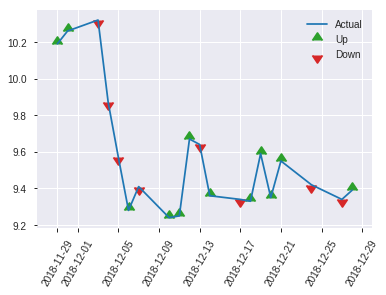


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20012564369346716
RMSE: 0.44735404736457585
LogLoss: 0.5842437570103212
Mean Per-Class Error: 0.27536830073660146
AUC: 0.7605410210820421
pr_auc: 0.7253645461831536
Gini: 0.5210820421640843
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4162625136539883: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   60   0.4839   (60.0/124.0)
1      16   111  0.126    (16.0/127.0)
Total  80   171  0.3028   (76.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.416263     0.744966  170
max f2                       0.183823     0.853825  223
max f0point5                 0.502625     0.722802  135
max accuracy                 0.502625     0.7251    135
max precision                0.847659     1         0
max recall                   0.0766998    1         242
max specificity              0.847659     1         0
max absolute_mcc             0.502625     0.450812  135
max min_per_class_accuracy   0.508506     0.709677  126
max mean_per_class_accuracy  0.502625     0.724632  135

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 48.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.835024           1.97638   1.97638            1                0.843539  1                           0.843539            0.023622        0.023622                   97.6378   97.6378
    2        0.0239044                   0.827603           1.97638   1.97638            1                0.828704  1                           0.836122            0.023622        0.0472441                  97.6378   97.6378
    3        0.0318725                   0.815486           0.988189  1.72933            0.5              0.820642  0.875                       0.832252            0.00787402      0.0551181                  -1.1811   72.9331
    4        0.0438247                   0.810088           1.31759   1.61704            0.666667         0.810862  0.818182                    0.826418            0.015748        0.0708661                  31.7585   61.7037
    5        0.0517928                   0.799916           1.97638   1.67232            1                0.80412   0.846154                    0.822988            0.015748        0.0866142                  97.6378   67.232
    6        0.103586                    0.759705           1.21623   1.44428            0.615385         0.776395  0.730769                    0.799691            0.0629921       0.149606                   21.6233   44.4276
    7        0.151394                    0.716947           1.81168   1.5603             0.916667         0.736722  0.789474                    0.779806            0.0866142       0.23622                    81.168    56.0298
    8        0.203187                    0.672322           1.52029   1.5501             0.769231         0.689458  0.784314                    0.756776            0.0787402       0.314961                   52.0291   55.01
    9        0.302789                    0.612599           1.26488   1.45628            0.64             0.643288  0.736842                    0.719445            0.125984        0.440945                   26.4882   45.6278
    10       0.40239                     0.549591           1.26488   1.4089             0.64             0.583026  0.712871                    0.685678            0.125984        0.566929                   26.4882   40.8903
    11       0.501992                    0.508961           1.42299   1.4117             0.72             0.52242   0.714286                    0.653285            0.141732        0.708661                   42.2992   41.1699
    12       0.601594                    0.474117           0.948661  1.33504            0.48             0.494939  0.675497                    0.627069            0.0944882       0.80315                    -5.13386  33.5037
    13       0.701195                    0.388205           0.711496  1.24647            0.36             0.440265  0.630682                    0.600534            0.0708661       0.874016                   -28.8504  24.6466
    14       0.800797                    0.280925           0.632441  1.17009            0.32             0.329626  0.59204                     0.566839            0.0629921       0.937008                   -36.7559  17.0094
    15       0.900398                    0.16959            0.474331  1.09313            0.24             0.221916  0.553097                    0.528684            0.0472441       0.984252                   -52.5669  9.31294
    16       1                           0.0178571          0.15811   1                  0.08             0.100524  0.505976                    0.486039            

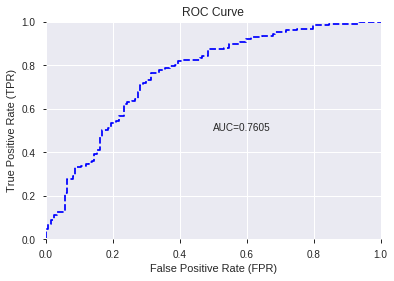

This function is available for GLM models only


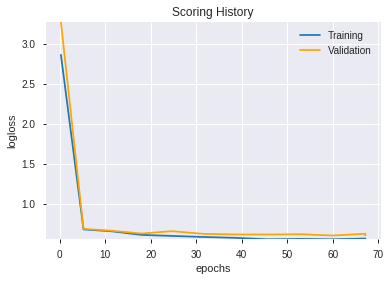

--2019-08-26 20:06:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.228.208
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.228.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  16.5MB/s    in 23s     

2019-08-26 20:07:00 (15.4 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_193555_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_193555_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_8650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_200713_model_9  0.781814  0.558287              0.317786  0.436049  0.190139
1  DeepLearning_grid_1_AutoML_20190826_200713_model_6  0.768733  0.572508              0.276797  0.440396  0.193949
2  DeepLearning_grid_1_AutoML_20190826_200713_model_5  0.766574  0.586789              0.280925  0.446986  0.199797
3  DeepLearning_grid_1_AutoML_20190826_200713_model_7  0.751524  0.612726              0.296577  0.453559  0.205716
4  DeepLearning_grid_1_AutoML_20190826_200713_model_8  0.745809  0.613924              0.300800  0.453330  0.205508
5  DeepLearning_grid_1_AutoML_20190826_200713_model_4  0.736284  0.769558              0.337662  0.496290  0.246304
6               DeepLearning_1_AutoML_20190826_200713  0.732601  0.627446              0.321628  0.461149  0.212658
7  DeepLearning_grid_1_AutoML_20190826_200713_model_3  0.732029  0.658434              0.337471  0.463967  0.215266
8  DeepLearning_grid_1_AutoML_20190826_200713_model_2  0.724346  0.647737              0.349759  0.468804  0.219777
9  DeepLearning_grid_1_AutoML_20190826_200713_model_1  0.685738  0.839817              0.373857  0.508124  0.258190

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.034452
1   CDLCLOSINGMARUBOZU             0.761104           0.761104    0.026222
2          CDLLONGLINE             0.655583           0.655583    0.022586
3         CDLSHORTLINE             0.628584           0.628584    0.021656
4          CDLBELTHOLD             0.624653           0.624653    0.021521
5       STOCHRSI_fastk             0.623721           0.623721    0.021489
6                  DIV             0.606783           0.606783    0.020905
7         STOCHF_fastd             0.606627           0.606627    0.020900
8            CDLTAKURI             0.595037           0.595037    0.020500
9               TRANGE             0.594552           0.594552    0.020484
10             BETA_12             0.587849           0.587849    0.020253
11    CDLDRAGONFLYDOJI             0.583833           0.583833    0.020114
12              ULTOSC             0.582142           0.582142    0.020056
13                 SUB             0.580069           0.580069    0.019985
14           CORREL_20             0.579232           0.579232    0.019956
15   CDLDARKCLOUDCOVER             0.578972           0.578972    0.019947
16            WILLR_12             0.578411           0.578411    0.019928
17         CDLMARUBOZU             0.575992           0.575992    0.019844
18                TANH             0.575734           0.575734    0.019835
19       days_in_month             0.574573           0.574573    0.019795
20          CDL3INSIDE             0.573972           0.573972    0.019775
21        STOCHF_fastk             0.573368           0.573368    0.019754
22           dayofweek             0.573118           0.573118    0.019745
23       CDLHANGINGMAN             0.571857           0.571857    0.019702
24         CDLHIGHWAVE             0.571545           0.571545    0.019691
25                 COS             0.570630           0.570630    0.019660
26        CDLENGULFING             0.570139           0.570139    0.019643
27           CDLHAMMER             0.570106           0.570106    0.019641
28         STOCH_slowk             0.565683           0.565683    0.019489
29           dayofyear             0.565412           0.565412    0.019480
30        weekday_name             0.564937           0.564937    0.019463
31            WILLR_14             0.560939           0.560939    0.019326
32          aroonup_12             0.556927           0.556927    0.019187
33               month             0.556699           0.556699    0.019180
34               CMO_8             0.554243           0.554243    0.019095
35              SAREXT             0.552404           0.552404    0.019032
36           PLUS_DM_8             0.552239           0.552239    0.019026
37           aroonup_8             0.548742           0.548742    0.018905
38              BETA_8             0.547993           0.547993    0.018880
39        is_month_end             0.545577           0.545577    0.018796
40             WILLR_8             0.541109           0.541109    0.018642
41         STOCH_slowd             0.539783           0.539783    0.018597
42               ADOSC             0.536905           0.536905    0.018498
43        HT_TRENDMODE             0.536586           0.536586    0.018487
44      is_month_start             0.530378           0.530378    0.018273
45           CORREL_14             0.528171           0.528171    0.018197
46            CORREL_8             0.522645           0.522645    0.018006
47           CORREL_12             0.518697           0.518697    0.017870
48             quarter             0.515861           0.515861    0.017773
49           CORREL_24             0.515485           0.515485    0.017760

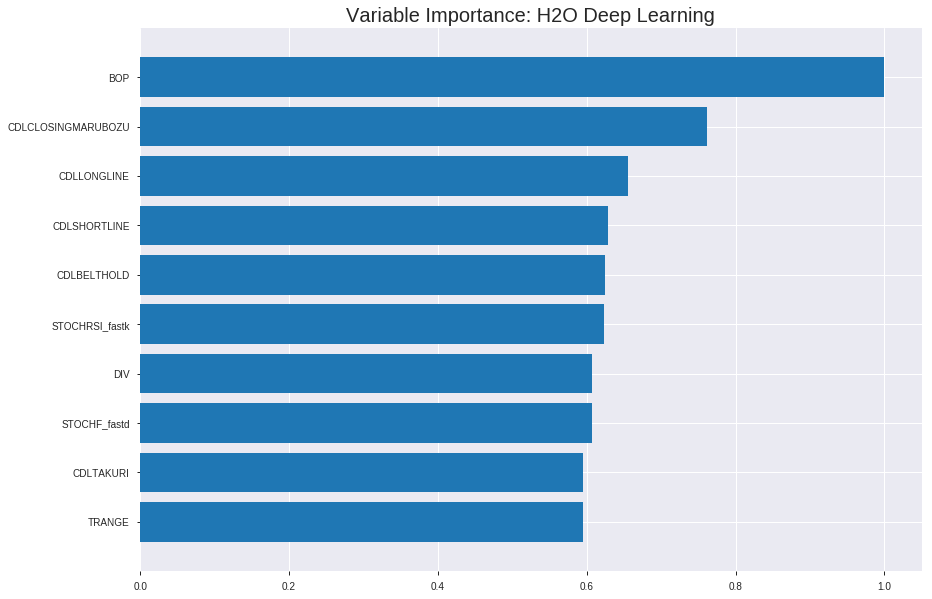

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_200713_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19395830051100538
RMSE: 0.4404069714604951
LogLoss: 0.5703095848549756
Mean Per-Class Error: 0.2903639526465732
AUC: 0.7762450326296985
pr_auc: 0.7691439273046954
Gini: 0.5524900652593969
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46072312513525804: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      462  399   0.4634   (399.0/861.0)
1      135  757   0.1513   (135.0/892.0)
Total  597  1156  0.3046   (534.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.460723     0.739258  228
max f2                       0.1092       0.850202  363
max f0point5                 0.623182     0.722614  141
max accuracy                 0.554544     0.710211  180
max precision                0.90972      1         0
max recall                   0.0431978    1         394
max specificity              0.90972      1         0
max absolute_mcc             0.554544     0.420311  180
max min_per_class_accuracy   0.575712     0.702671  170
max mean_per_class_accuracy  0.554544     0.709636  180

Gains/Lift Table: Avg response rate: 50.88 %, avg score: 52.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.889257           1.96525   1.96525            1                0.895735   1                           0.895735            0.0201794       0.0201794                  96.5247   96.5247
    2        0.0205362                   0.876306           1.63771   1.80148            0.833333         0.881342   0.916667                    0.888538            0.0168161       0.0369955                  63.7706   80.1476
    3        0.0302339                   0.86428            1.73404   1.77985            0.882353         0.870335   0.90566                     0.882699            0.0168161       0.0538117                  73.4041   77.9846
    4        0.040502                    0.857058           1.74689   1.77149            0.888889         0.861373   0.901408                    0.877293            0.0179372       0.0717489                  74.6886   77.149
    5        0.0501997                   0.845085           1.84964   1.78659            0.941176         0.851334   0.909091                    0.872278            0.0179372       0.0896861                  84.9644   78.6588
    6        0.100399                    0.803209           1.63026   1.70842            0.829545         0.825124   0.869318                    0.848701            0.0818386       0.171525                   63.0261   70.8425
    7        0.150029                    0.770118           1.53605   1.6514             0.781609         0.785569   0.840304                    0.827817            0.0762332       0.247758                   53.6055   65.1405
    8        0.200228                    0.731421           1.5186    1.61811            0.772727         0.752054   0.823362                    0.808822            0.0762332       0.323991                   51.86     61.8109
    9        0.300057                    0.671884           1.41498   1.55053            0.72             0.700364   0.788973                    0.772738            0.141256        0.465247                   41.4978   55.0527
    10       0.399886                    0.621934           1.33637   1.49706            0.68             0.644258   0.761769                    0.740664            0.133408        0.598655                   33.6368   49.7064
    11       0.500285                    0.577599           1.01612   1.40055            0.517045         0.600716   0.712657                    0.712579            0.102018        0.700673                   1.61218   40.0546
    12       0.600114                    0.508648           0.954548  1.32635            0.485714         0.545559   0.674905                    0.684795            0.0952915       0.795964                   -4.54516  32.6355
    13       0.699943                    0.415103           0.786099  1.2493             0.4              0.464265   0.635697                    0.653342            0.0784753       0.874439                   -21.3901  24.9301
    14       0.799772                    0.27652            0.640109  1.17326            0.325714         0.351578   0.597004                    0.615675            0.0639013       0.938341                   -35.9891  17.3261
    15       0.899601                    0.136179           0.370589  1.08419            0.188571         0.196971   0.55168                     0.569212            0.0369955       0.975336                   -62.9411  8.41881
    16       1                           0.0278478          0.245656  1                  0.125            0.0839447  0.508842                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20081836949222706
RMSE: 0.44812762634346376
LogLoss: 0.5871206498549291
Mean Per-Class Error: 0.2939594737347546
AUC: 0.753169115528666
pr_auc: 0.7446052974744239
Gini: 0.5063382310573321
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4830217225982999: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      112  122  0.5214   (122.0/234.0)
1      31   236  0.1161   (31.0/267.0)
Total  143  358  0.3054   (153.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483022     0.7552    267
max f2                       0.228586     0.863787  342
max f0point5                 0.600107     0.719557  193
max accuracy                 0.572517     0.712575  220
max precision                0.834254     0.897959  36
max recall                   0.0554395    1         391
max specificity              0.909034     0.995726  0
max absolute_mcc             0.572517     0.422062  220
max min_per_class_accuracy   0.610726     0.688034  184
max mean_per_class_accuracy  0.572517     0.706041  220

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 56.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.894339           1.25094   1.25094            0.666667         0.902858  0.666667                    0.902858            0.0149813       0.0149813                  25.0936   25.0936
    2        0.0219561                   0.882863           1.8764    1.53524            1                0.887728  0.818182                    0.89598             0.0187266       0.0337079                  87.6404   53.524
    3        0.0319361                   0.878529           1.50112   1.52458            0.8              0.880827  0.8125                      0.891245            0.0149813       0.0486891                  50.1124   52.4579
    4        0.0419162                   0.875859           1.50112   1.51899            0.8              0.877327  0.809524                    0.887931            0.0149813       0.0636704                  50.1124   51.8994
    5        0.0518962                   0.868284           1.8764    1.58773            1                0.870718  0.846154                    0.884621            0.0187266       0.082397                   87.6404   58.7727
    6        0.101796                    0.82957            1.72629   1.65565            0.92             0.843258  0.882353                    0.864345            0.0861423       0.168539                   72.6292   65.5651
    7        0.151697                    0.802798           1.42607   1.58013            0.76             0.817068  0.842105                    0.848793            0.071161        0.2397                     42.6067   58.013
    8        0.201597                    0.757894           1.27596   1.50484            0.68             0.780025  0.80198                     0.831771            0.0636704       0.303371                   27.5955   50.4839
    9        0.301397                    0.686306           1.35101   1.4539             0.72             0.720575  0.774834                    0.794951            0.134831        0.438202                   35.1011   45.3903
    10       0.401198                    0.648303           1.08831   1.36296            0.58             0.662547  0.726368                    0.762015            0.108614        0.546816                   8.83146   36.296
    11       0.500998                    0.613196           1.2009    1.33068            0.64             0.630723  0.709163                    0.735861            0.11985         0.666667                   20.0899   33.0677
    12       0.600798                    0.578428           1.2009    1.30912            0.64             0.59612   0.697674                    0.712648            0.11985         0.786517                   20.0899   30.9119
    13       0.700599                    0.507432           0.825618  1.24024            0.44             0.543998  0.660969                    0.688624            0.082397        0.868914                   -17.4382  24.0245
    14       0.800399                    0.385005           0.637978  1.16515            0.34             0.449092  0.620948                    0.658757            0.0636704       0.932584                   -36.2022  16.5149
    15       0.9002                      0.189079           0.487865  1.09006            0.26             0.289108  0.580931                    0.617776            0.0486891       0.981273                   -51.2135  9.0062
    16       1                           0.0125726          0.18764   1                  0.1              0.105704  0.532934                    0.566671            0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 20:13:21  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 20:13:23  2 min  3.037 sec  558 obs/sec       0.575585  1             1009       0.526631         0.947053            -0.109707      0.757786        0.741633           1.74689          0.333714                         0.523091           0.895331              -0.0992678       0.741365          0.738247             1.56367            0.343313
    2019-08-26 20:13:32  2 min 12.210 sec  906 obs/sec       5.24758   9             9199       0.440407         0.57031             0.223924       0.776245        0.769144           1.96525          0.304621                         0.448128           0.587121              0.193226         0.753169          0.744605             1.25094            0.305389
    2019-08-26 20:13:41  2 min 20.736 sec  1086 obs/sec      11.0559   19            19381      0.465098         0.621784            0.134466       0.785471        0.771394           1.74689          0.30348                          0.469803           0.631692              0.113294         0.749816          0.735375             1.56367            0.317365
    2019-08-26 20:13:49  2 min 29.287 sec  1206 obs/sec      17.5813   30            30820      0.438969         0.56915             0.228983       0.787654        0.776602           1.74689          0.286366                         0.448921           0.589386              0.190367         0.757843          0.743276             1.25094            0.329341
    2019-08-26 20:13:58  2 min 37.628 sec  1307 obs/sec      24.6617   42            43232      0.439836         0.572589            0.225936       0.791686        0.78076            1.74689          0.29093                          0.450433           0.593315              0.184903         0.759956          0.744517             0.938202           0.339321
    2019-08-26 20:14:06  2 min 46.092 sec  1393 obs/sec      32.3212   55            56659      0.432666         0.556326            0.250967       0.79483         0.784575           1.74689          0.284084                         0.44867            0.592751              0.191273         0.761708          0.746034             0.938202           0.293413
    2019-08-26 20:14:15  2 min 54.726 sec  1466 obs/sec      40.5568   69            71096      0.432672         0.556792            0.250945       0.804407        0.789895           1.74689          0.276669                         0.452794           0.604172              0.176336         0.759891          0.744213             0.938202           0.319361
    2019-08-26 20:14:15  2 min 55.619 sec  1465 obs/sec      40.5568   69            71096      0.440407         0.57031             0.223924       0.776245        0.769144           1.96525          0.304621                         0.448128           0.587121              0.193226         0.753169          0.744605             1.25094            0.305389

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.03445234959997008
CDLCLOSINGMARUBOZU  0.7611035108566284     0.7611035108566284   0.026221804237797186
CDLLONGLINE         0.6555832624435425     0.6555832624435425   0.022586383749593864
CDLSHORTLINE        0.628583550453186      0.628583550453186    0.0216561802330036
CDLBELTHOLD         0.6246531009674072     0.6246531009674072   0.021520767013234524
---                 ---                    ---                  ---
CORREL_14           0.5281708240509033     0.5281708240509033   0.018196725878706008
CORREL_8            0.5226454138755798     0.5226454138755798   0.01800636251566253
CORREL_12           0.5186969041824341     0.5186969041824341   0.017870327079315403
quarter             0.5158606171607971     0.5158606171607971   0.017772610327280107
CORREL_24           0.5154845118522644     0.5154845118522644   0.017759652615704134


See the whole table with table.as_data_frame()


('accuracy', 0.7091633466135459)

('F1', 0.7507886435331229)

('auc', 0.7818135636271273)

('logloss', 0.5582874402740321)

('mean_per_class_error', 0.2913068326136652)

('rmse', 0.43604933288582204)

('mse', 0.19013902071017044)

deeplearning prediction progress: |███████████████████████████████████████| 100%


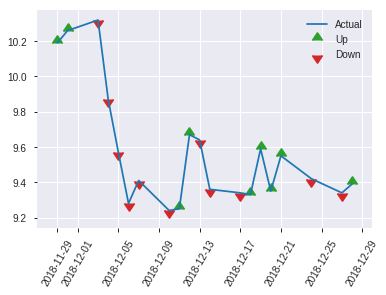


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19013902071017044
RMSE: 0.43604933288582204
LogLoss: 0.5582874402740321
Mean Per-Class Error: 0.2913068326136652
AUC: 0.7818135636271273
pr_auc: 0.7735070110415532
Gini: 0.5636271272542546
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31406442092599385: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      53   71   0.5726   (71.0/124.0)
1      8    119  0.063    (8.0/127.0)
Total  61   190  0.3147   (79.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.314064     0.750789  189
max f2                       0.14325      0.864198  220
max f0point5                 0.625646     0.728953  89
max accuracy                 0.539003     0.709163  135
max precision                0.883172     1         0
max recall                   0.0635384    1         243
max specificity              0.883172     1         0
max absolute_mcc             0.314064     0.424797  189
max min_per_class_accuracy   0.57397      0.677419  126
max mean_per_class_accuracy  0.539003     0.708693  135

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 49.92 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.879537           1.97638    1.97638            1                0.882431   1                           0.882431            0.023622        0.023622                   97.6378   97.6378
    2        0.0239044                   0.869319           1.97638    1.97638            1                0.872935   1                           0.877683            0.023622        0.0472441                  97.6378   97.6378
    3        0.0318725                   0.86486            1.97638    1.97638            1                0.866523   1                           0.874893            0.015748        0.0629921                  97.6378   97.6378
    4        0.0438247                   0.855092           1.97638    1.97638            1                0.860389   1                           0.870937            0.023622        0.0866142                  97.6378   97.6378
    5        0.0517928                   0.842756           1.97638    1.97638            1                0.848092   1                           0.867423            0.015748        0.102362                   97.6378   97.6378
    6        0.103586                    0.787301           1.52029    1.74833            0.769231         0.810098   0.884615                    0.83876             0.0787402       0.181102                   52.0291   74.8334
    7        0.151394                    0.732735           1.48228    1.66432            0.75             0.75969    0.842105                    0.813791            0.0708661       0.251969                   48.2283   66.4318
    8        0.203187                    0.696929           1.52029    1.62761            0.769231         0.71628    0.823529                    0.788935            0.0787402       0.330709                   52.0291   62.7605
    9        0.302789                    0.645767           1.5811     1.61231            0.8              0.66919    0.815789                    0.749545            0.15748         0.488189                   58.1102   61.2308
    10       0.40239                     0.604703           0.948661   1.44804            0.48             0.625978   0.732673                    0.718959            0.0944882       0.582677                   -5.13386  44.8039
    11       0.501992                    0.574832           0.948661   1.34896            0.48             0.58981    0.68254                     0.693334            0.0944882       0.677165                   -5.13386  34.8956
    12       0.601594                    0.478501           1.18583    1.32195            0.6              0.524295   0.668874                    0.665348            0.11811         0.795276                   18.5827   32.1948
    13       0.701195                    0.381234           0.869606   1.2577             0.44             0.432382   0.636364                    0.632256            0.0866142       0.88189                    -13.0394  25.7695
    14       0.800797                    0.242034           0.632441   1.17993            0.32             0.315692   0.597015                    0.592882            0.0629921       0.944882                   -36.7559  17.9927
    15       0.900398                    0.125383           0.474331   1.10187            0.24             0.16864    0.557522                    0.545953            0.0472441       0.992126                   -52.5669  10.1874
    16       1                           0.0339261          0.0790551  1                  0.04             0.0766976  0.505976 

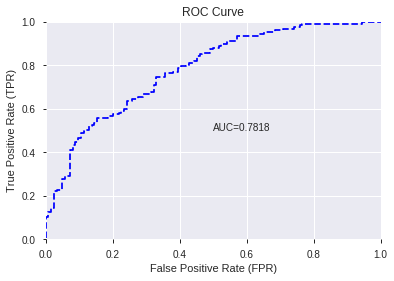

This function is available for GLM models only


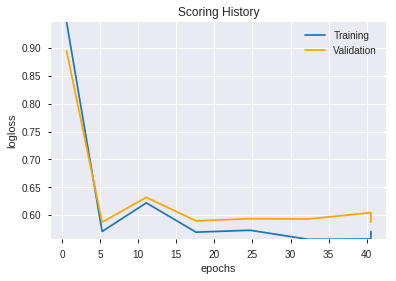

--2019-08-26 20:14:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.176.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.176.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_200713_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_200713_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_8650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'CDLBELTHOLD',
 'STOCHRSI_fastk',
 'DIV',
 'STOCHF_fastd',
 'CDLTAKURI',
 'TRANGE',
 'BETA_12',
 'CDLDRAGONFLYDOJI',
 'ULTOSC',
 'SUB',
 'CORREL_20',
 'CDLDARKCLOUDCOVER',
 'WILLR_12',
 'CDLMARUBOZU',
 'TANH',
 'days_in_month',
 'CDL3INSIDE',
 'STOCHF_fastk',
 'dayofweek',
 'CDLHANGINGMAN',
 'CDLHIGHWAVE',
 'COS',
 'CDLENGULFING',
 'CDLHAMMER',
 'STOCH_slowk',
 'dayofyear',
 'weekday_name',
 'WILLR_14',
 'aroonup_12',
 'month',
 'CMO_8',
 'SAREXT',
 'PLUS_DM_8',
 'aroonup_8',
 'BETA_8',
 'is_month_end',
 'WILLR_8',
 'STOCH_slowd',
 'ADOSC',
 'HT_TRENDMODE',
 'is_month_start',
 'CORREL_14',
 'CORREL_8',
 'CORREL_12',
 'quarter',
 'CORREL_24']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190826_201435_model_1  0.771908  0.565356              0.297244  0.43866  0.192422

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.666022           1.000000    0.159734
1                  DIV             0.249078           0.373979    0.059737
2   CDLCLOSINGMARUBOZU             0.214362           0.321855    0.051411
3               ULTOSC             0.201589           0.302676    0.048348
4         STOCHF_fastk             0.166385           0.249820    0.039905
5         STOCHF_fastd             0.154982           0.232699    0.037170
6          STOCH_slowk             0.154543           0.232039    0.037065
7            CDLHAMMER             0.132769           0.199347    0.031843
8           aroonup_12             0.130543           0.196005    0.031309
9               TRANGE             0.121341           0.182188    0.029102
10            WILLR_12             0.102862           0.154443    0.024670
11   CDLDARKCLOUDCOVER             0.102683           0.154174    0.024627
12           CORREL_12             0.092136           0.138337    0.022097
13             WILLR_8             0.089853           0.134910    0.021550
14      STOCHRSI_fastk             0.083468           0.125323    0.020018
15           CORREL_24             0.082691           0.124156    0.019832
16             BETA_12             0.080838           0.121375    0.019388
17          CDL3INSIDE             0.077428           0.116254    0.018570
18    CDLDRAGONFLYDOJI             0.074122           0.111291    0.017777
19           CORREL_20             0.073972           0.111066    0.017741
20           CDLTAKURI             0.073842           0.110870    0.017710
21              SAREXT             0.072740           0.109216    0.017446
22               CMO_8             0.068320           0.102579    0.016385
23        HT_TRENDMODE             0.065382           0.098168    0.015681
24                TANH             0.059073           0.088695    0.014168
25               ADOSC             0.052668           0.079079    0.012632
26         CDLMARUBOZU             0.052590           0.078961    0.012613
27                 COS             0.051006           0.076584    0.012233
28        weekday_name             0.050438           0.075731    0.012097
29         CDLHIGHWAVE             0.048695           0.073113    0.011679
30           CORREL_14             0.045828           0.068808    0.010991
31       CDLHANGINGMAN             0.044354           0.066595    0.010638
32         CDLBELTHOLD             0.043829           0.065808    0.010512
33            WILLR_14             0.042417           0.063687    0.010173
34           aroonup_8             0.041797           0.062756    0.010024
35        is_month_end             0.038636           0.058011    0.009266
36           dayofyear             0.038481           0.057777    0.009229
37              BETA_8             0.033714           0.050620    0.008086
38             quarter             0.029715           0.044615    0.007127
39            CORREL_8             0.026910           0.040405    0.006454
40                 SUB             0.026030           0.039083    0.006243
41       days_in_month             0.020929           0.031423    0.005019
42        CDLSHORTLINE             0.019431           0.029175    0.004660
43         STOCH_slowd             0.017534           0.026326    0.004205
44           PLUS_DM_8             0.014212           0.021339    0.003409
45         CDLLONGLINE             0.013342           0.020033    0.003200
46           dayofweek             0.007305           0.010968    0.001752
47               month             0.006963           0.010455    0.001670
48        CDLENGULFING             0.006605           0.009917    0.001584
49      is_month_start             0.005101           0.007659    0.001223

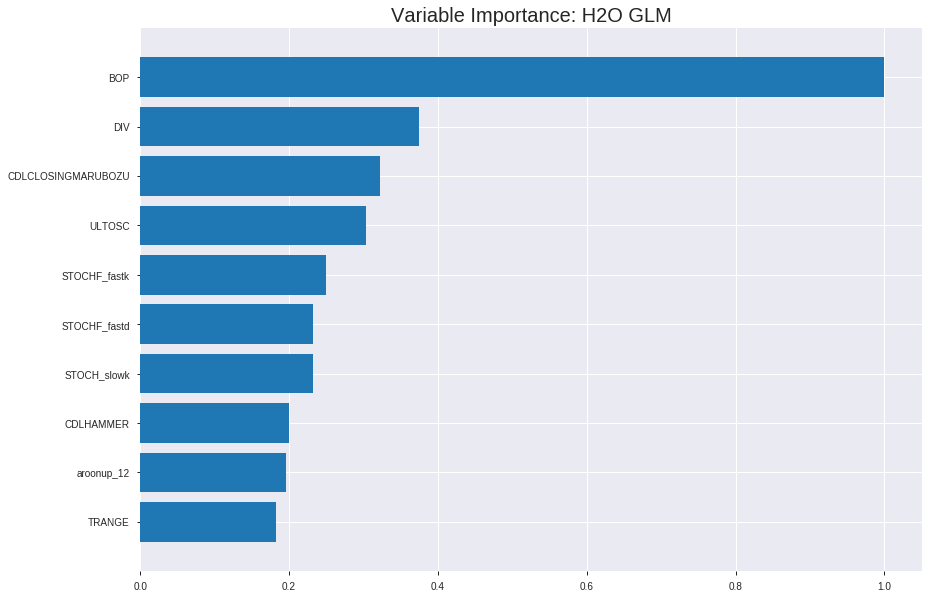

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_201435_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18916336299171901
RMSE: 0.4349291470937755
LogLoss: 0.558535210210408
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2429.6257833865593
Residual deviance: 1958.2244469976908
AIC: 2060.224446997691
AUC: 0.784727973000422
pr_auc: 0.7736934991767523
Gini: 0.5694559460008439
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37250967270997176: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      444  417   0.4843   (417.0/861.0)
1      116  776   0.13     (116.0/892.0)
Total  560  1193  0.3041   (533.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37251      0.744365  260
max f2                       0.139797     0.851717  361
max f0point5                 0.629711     0.724206  142
max accuracy                 0.482238     0.715345  208
max precision                0.943862     1         0
max recall                   0.0776531    1         383
max specificity              0.943862     1         0
max absolute_mcc             0.482238     0.430858  208
max min_per_class_accuracy   0.523501     0.708479  190
max mean_per_class_accuracy  0.482238     0.714641  208

Gains/Lift Table: Avg response rate: 50.88 %, avg score: 50.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.914498           1.74689   1.74689            0.888889         0.926883  0.888889                    0.926883            0.0179372       0.0179372                  74.6886   74.6886
    2        0.0205362                   0.897593           1.74689   1.74689            0.888889         0.907642  0.888889                    0.917262            0.0179372       0.0358744                  74.6886   74.6886
    3        0.0302339                   0.881898           1.84964   1.77985            0.941176         0.889063  0.90566                     0.908217            0.0179372       0.0538117                  84.9644   77.9846
    4        0.040502                    0.872082           1.63771   1.74381            0.833333         0.877133  0.887324                    0.900337            0.0168161       0.0706278                  63.7706   74.381
    5        0.0501997                   0.857732           1.50284   1.69726            0.764706         0.864917  0.863636                    0.893494            0.014574        0.0852018                  50.2836   69.7258
    6        0.100399                    0.803534           1.78659   1.74192            0.909091         0.832472  0.886364                    0.862983            0.0896861       0.174888                   78.6588   74.1923
    7        0.150029                    0.770613           1.55864   1.68129            0.793103         0.786643  0.855513                    0.83773             0.0773543       0.252242                   55.8644   68.1295
    8        0.200228                    0.740182           1.47393   1.62931            0.75             0.756414  0.82906                     0.817343            0.073991        0.326233                   47.3935   62.9307
    9        0.300057                    0.677096           1.48236   1.58042            0.754286         0.707686  0.804183                    0.78086             0.147982        0.474215                   48.2357   58.0417
    10       0.399886                    0.612263           1.21284   1.48865            0.617143         0.645937  0.757489                    0.747177            0.121076        0.595291                   21.2838   48.8653
    11       0.500285                    0.52697            1.08312   1.40727            0.551136         0.570842  0.716078                    0.71179             0.108744        0.704036                   8.31189   40.7269
    12       0.600114                    0.434972           0.954548  1.33196            0.485714         0.47654   0.677757                    0.672656            0.0952915       0.799327                   -4.54516  33.1959
    13       0.699943                    0.353678           0.819789  1.25891            0.417143         0.394506  0.640587                    0.632985            0.0818386       0.881166                   -18.0211  25.8911
    14       0.799772                    0.274059           0.606419  1.17747            0.308571         0.314533  0.599144                    0.593235            0.0605381       0.941704                   -39.3581  17.7466
    15       0.899601                    0.177223           0.381819  1.08917            0.194286         0.226659  0.554217                    0.552556            0.0381166       0.979821                   -61.8181  8.91728
    16       1                           0.0236293          0.200991  1                  0.102273         0.117153  0.508842                    0.508842          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1971212296694615
RMSE: 0.44398336643331754
LogLoss: 0.5798541753278866
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 693.5229098211739
Residual deviance: 581.0138836785424
AIC: 683.0138836785424
AUC: 0.7636047888856877
pr_auc: 0.7471093451736409
Gini: 0.5272095777713754
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3882229957102724: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      100  134  0.5726   (134.0/234.0)
1      24   243  0.0899   (24.0/267.0)
Total  124  377  0.3154   (158.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.388223     0.754658  291
max f2                       0.295737     0.868984  333
max f0point5                 0.644347     0.729073  160
max accuracy                 0.530963     0.702595  224
max precision                0.81435      0.892308  47
max recall                   0.0781581    1         392
max specificity              0.948726     0.995726  0
max absolute_mcc             0.446194     0.404255  266
max min_per_class_accuracy   0.593104     0.689139  193
max mean_per_class_accuracy  0.603211     0.700327  187

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 55.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.909187           0.938202  0.938202           0.5              0.925412  0.5                         0.925412            0.011236        0.011236                   -6.17978  -6.17978
    2        0.0219561                   0.900631           1.50112   1.19408            0.8              0.903745  0.636364                    0.915563            0.0149813       0.0262172                  50.1124   19.4076
    3        0.0319361                   0.895094           1.8764    1.4073             1                0.896156  0.75                        0.909498            0.0187266       0.0449438                  87.6404   40.7303
    4        0.0419162                   0.87818            1.50112   1.42964            0.8              0.887014  0.761905                    0.904145            0.0149813       0.0599251                  50.1124   42.9642
    5        0.0518962                   0.874122           1.8764    1.51556            1                0.874832  0.807692                    0.898508            0.0187266       0.0786517                  87.6404   51.5557
    6        0.101796                    0.827104           1.80135   1.65565            0.96             0.854184  0.882353                    0.876781            0.0898876       0.168539                   80.1348   65.5651
    7        0.151697                    0.801252           1.57618   1.62951            0.84             0.814889  0.868421                    0.856421            0.0786517       0.247191                   57.618    62.9509
    8        0.201597                    0.754824           1.27596   1.542              0.68             0.776792  0.821782                    0.836711            0.0636704       0.310861                   27.5955   54.1996
    9        0.301397                    0.707872           1.35101   1.47876            0.72             0.730539  0.788079                    0.801555            0.134831        0.445693                   35.1011   47.8756
    10       0.401198                    0.657634           1.27596   1.42831            0.68             0.682242  0.761194                    0.771875            0.127341        0.573034                   27.5955   42.8308
    11       0.500998                    0.594314           1.08831   1.36058            0.58             0.623712  0.7251                      0.74236             0.108614        0.681648                   8.83146   36.058
    12       0.600798                    0.516769           0.97573   1.29665            0.52             0.556892  0.69103                     0.711552            0.0973783       0.779026                   -2.42697  29.6652
    13       0.700599                    0.439379           0.900674  1.24024            0.48             0.4772    0.660969                    0.678168            0.0898876       0.868914                   -9.93258  24.0245
    14       0.800399                    0.363033           0.675506  1.16983            0.36             0.390827  0.623441                    0.64234             0.0674157       0.93633                    -32.4494  16.9828
    15       0.9002                      0.24692            0.375281  1.08174            0.2              0.302645  0.576497                    0.60468             0.0374532       0.973783                   -62.4719  8.1741
    16       1                           0.00237925         0.262697  1                  0.14             0.145561  0.532934                    0.55886           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-26 20:14:35  0.000 sec   2            .22E2     51            1.365694472349188   1.3636401525871793
     2019-08-26 20:14:35  0.084 sec   4            .14E2     51            1.3552790244698083  1.353142228621671
     2019-08-26 20:14:35  0.157 sec   6            .84E1     51            1.3407848498276502  1.3386926084486503
     2019-08-26 20:14:36  0.230 sec   8            .52E1     51            1.3217685306972298  1.320007271290538
     2019-08-26 20:14:36  0.321 sec   10           .32E1     51            1.2983962440296128  1.2975508827775752
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-26 20:14:36  0.781 sec   34           .11E-1    51            1.1147587698958468  1.1600925140765435
     2019-08-26 20:14:36  0.807 sec   36           .66E-2    51            1.1133160801078466  1.1608775613798135
     2019-08-26 20:14:36  0.838 sec   38           .41E-2    51            1.1124495422891563  1.1617601427947268
     2019-08-26 20:14:36  0.858 sec   39           .25E-2    51            1.1119436683496584  1.1625802964599758
     2019-08-26 20:14:36  0.871 sec   40           .16E-2    51            1.1116635061920384  1.1632772468306103


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7131474103585658)

('F1', 0.756578947368421)

('auc', 0.7719075438150875)

('logloss', 0.5653559083590596)

('mean_per_class_error', 0.28784607569215137)

('rmse', 0.4386598373936053)

('mse', 0.19242245294218424)

glm prediction progress: |████████████████████████████████████████████████| 100%


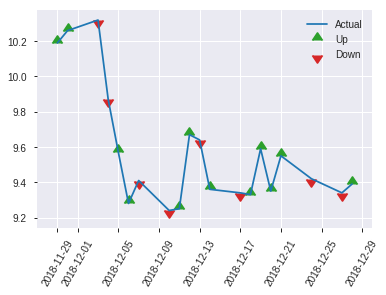


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19242245294218424
RMSE: 0.4386598373936053
LogLoss: 0.5653559083590596
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 347.9322754570597
Residual deviance: 283.8086659962479
AIC: 385.8086659962479
AUC: 0.7719075438150875
pr_auc: 0.7510102777195852
Gini: 0.543815087630175
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3504552198998467: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   62   0.5      (62.0/124.0)
1      12   115  0.0945   (12.0/127.0)
Total  74   177  0.2948   (74.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.350455     0.756579  176
max f2                       0.195495     0.859697  218
max f0point5                 0.613799     0.712909  97
max accuracy                 0.484766     0.713147  146
max precision                0.91126      1         0
max recall                   0.129986     1         239
max specificity              0.91126      1         0
max absolute_mcc             0.350455     0.444645  176
max min_per_class_accuracy   0.547792     0.692913  125
max mean_per_class_accuracy  0.484766     0.712154  146

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 51.01 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.89848            1.97638    1.97638            1                0.905977  1                           0.905977            0.023622        0.023622                   97.6378   97.6378
    2        0.0239044                   0.88975            1.97638    1.97638            1                0.893407  1                           0.899692            0.023622        0.0472441                  97.6378   97.6378
    3        0.0318725                   0.871035           1.97638    1.97638            1                0.877641  1                           0.894179            0.015748        0.0629921                  97.6378   97.6378
    4        0.0438247                   0.855541           1.31759    1.79671            0.666667         0.864276  0.909091                    0.886024            0.015748        0.0787402                  31.7585   79.6707
    5        0.0517928                   0.846658           1.97638    1.82435            1                0.854577  0.923077                    0.881186            0.015748        0.0944882                  97.6378   82.4349
    6        0.103586                    0.794625           1.52029    1.67232            0.769231         0.819756  0.846154                    0.850471            0.0787402       0.173228                   52.0291   67.232
    7        0.151394                    0.754366           1.48228    1.61231            0.75             0.774187  0.815789                    0.826381            0.0708661       0.244094                   48.2283   61.2308
    8        0.203187                    0.73227            1.36826    1.5501             0.692308         0.742172  0.784314                    0.804916            0.0708661       0.314961                   36.8262   55.01
    9        0.302789                    0.676047           1.50205    1.53429            0.76             0.702775  0.776316                    0.771317            0.149606        0.464567                   50.2047   53.4293
    10       0.40239                     0.604924           1.18583    1.44804            0.6              0.642538  0.732673                    0.739441            0.11811         0.582677                   18.5827   44.8039
    11       0.501992                    0.547792           1.10677    1.38033            0.56             0.575503  0.698413                    0.706914            0.110236        0.692913                   10.6772   38.0327
    12       0.601594                    0.460987           1.10677    1.33504            0.56             0.513366  0.675497                    0.674869            0.110236        0.80315                    10.6772   33.5037
    13       0.701195                    0.35478            0.948661   1.28015            0.48             0.40875   0.647727                    0.637068            0.0944882       0.897638                   -5.13386  28.0154
    14       0.800797                    0.259817           0.474331   1.17993            0.24             0.304793  0.597015                    0.59574             0.0472441       0.944882                   -52.5669  17.9927
    15       0.900398                    0.167251           0.474331   1.10187            0.24             0.20791   0.557522                    0.552839            0.0472441       0.992126                   -52.5669  10.1874
    16       1                           0.031576           0.0790551  1                  0.04             0.124085  0.505976                    0.

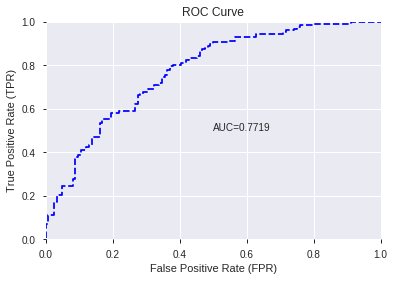

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


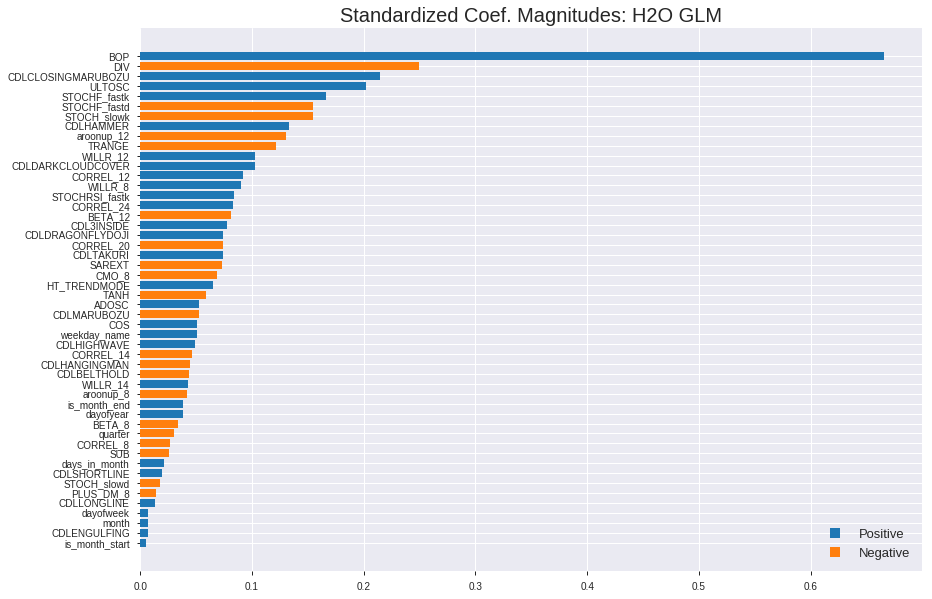

'log_likelihood'
--2019-08-26 20:14:42--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.1.220
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.1.220|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_201435_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_201435_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_8650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'DIV',
 'CDLCLOSINGMARUBOZU',
 'ULTOSC',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCH_slowk',
 'CDLHAMMER',
 'aroonup_12',
 'TRANGE',
 'WILLR_12',
 'CDLDARKCLOUDCOVER',
 'CORREL_12',
 'WILLR_8',
 'STOCHRSI_fastk',
 'CORREL_24',
 'BETA_12',
 'CDL3INSIDE',
 'CDLDRAGONFLYDOJI',
 'CORREL_20',
 'CDLTAKURI',
 'SAREXT',
 'CMO_8',
 'HT_TRENDMODE',
 'TANH',
 'ADOSC',
 'CDLMARUBOZU',
 'COS',
 'weekday_name',
 'CDLHIGHWAVE',
 'CORREL_14',
 'CDLHANGINGMAN',
 'CDLBELTHOLD',
 'WILLR_14',
 'aroonup_8',
 'is_month_end',
 'dayofyear',
 'BETA_8',
 'quarter',
 'CORREL_8',
 'SUB',
 'days_in_month',
 'CDLSHORTLINE',
 'STOCH_slowd',
 'PLUS_DM_8',
 'CDLLONGLINE',
 'dayofweek',
 'month',
 'CDLENGULFING',
 'is_month_start']

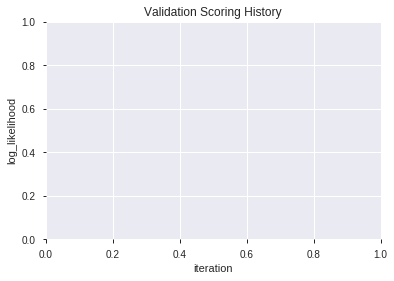

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_201452_model_1  0.767336  0.575776              0.292640  0.442349  0.195673
1  XGBoost_grid_1_AutoML_20190826_201452_model_6  0.765113  0.576878              0.321628  0.443358  0.196566
2  XGBoost_grid_1_AutoML_20190826_201452_model_3  0.764034  0.575113              0.267875  0.442163  0.195508
3               XGBoost_3_AutoML_20190826_201452  0.763970  0.573724              0.301562  0.442083  0.195438
4               XGBoost_1_AutoML_20190826_201452  0.763208  0.578154              0.296577  0.444027  0.197160
5               XGBoost_2_AutoML_20190826_201452  0.761303  0.581045              0.309531  0.445348  0.198335
6  XGBoost_grid_1_AutoML_20190826_201452_model_4  0.757811  0.581453              0.296958  0.445383  0.198366
7  XGBoost_grid_1_AutoML_20190826_201452_model_5  0.752985  0.589031              0.313468  0.449701  0.202231
8  XGBoost_grid_1_AutoML_20190826_201452_model_7  0.749428  0.588526              0.317405  0.449332  0.201899
9  XGBoost_grid_1_AutoML_20190826_201452_model_2  0.744539  0.590647              0.317310  0.449688  0.202219

variable  relative_importance  scaled_importance  percentage
0                  BOP          3562.292236           1.000000    0.395317
1                  DIV           907.550171           0.254766    0.100713
2         STOCHF_fastk           406.895752           0.114223    0.045154
3             CORREL_8           295.959381           0.083081    0.032843
4            dayofyear           291.018738           0.081694    0.032295
5              BETA_12           240.251343           0.067443    0.026661
6               BETA_8           237.850311           0.066769    0.026395
7                  SUB           202.711685           0.056905    0.022495
8            CORREL_24           197.772110           0.055518    0.021947
9          STOCH_slowk           186.063843           0.052231    0.020648
10         STOCH_slowd           173.006821           0.048566    0.019199
11            WILLR_12           159.878784           0.044881    0.017742
12              TRANGE           154.900818           0.043483    0.017190
13                 COS           145.593140           0.040871    0.016157
14                TANH           141.848038           0.039819    0.015741
15               ADOSC           138.125885           0.038774    0.015328
16              SAREXT           130.751312           0.036704    0.014510
17            WILLR_14           124.598343           0.034977    0.013827
18              ULTOSC           113.817101           0.031951    0.012631
19               CMO_8           105.971672           0.029748    0.011760
20           CORREL_20           104.684074           0.029387    0.011617
21  CDLCLOSINGMARUBOZU           103.048279           0.028928    0.011436
22           PLUS_DM_8            92.956856           0.026095    0.010316
23           CORREL_14            91.797188           0.025769    0.010187
24          aroonup_12            78.816261           0.022125    0.008746
25             WILLR_8            76.009964           0.021337    0.008435
26           aroonup_8            68.657158           0.019273    0.007619
27           dayofweek            54.279236           0.015237    0.006024
28           CORREL_12            53.035721           0.014888    0.005886
29         CDLHIGHWAVE            51.963608           0.014587    0.005767
30    CDLDRAGONFLYDOJI            46.888962           0.013163    0.005203
31      STOCHRSI_fastk            39.148567           0.010990    0.004344
32           CDLHAMMER            38.864426           0.010910    0.004313
33         CDLBELTHOLD            33.908104           0.009519    0.003763
34        STOCHF_fastd            33.294659           0.009346    0.003695
35        CDLSHORTLINE            31.788244           0.008924    0.003528
36        weekday_name            27.010483           0.007582    0.002997
37               month            18.928823           0.005314    0.002101
38       days_in_month            17.932400           0.005034    0.001990
39         CDLLONGLINE            15.381050           0.004318    0.001707
40           CDLTAKURI            12.117704           0.003402    0.001345
41        HT_TRENDMODE             3.863734           0.001085    0.000429

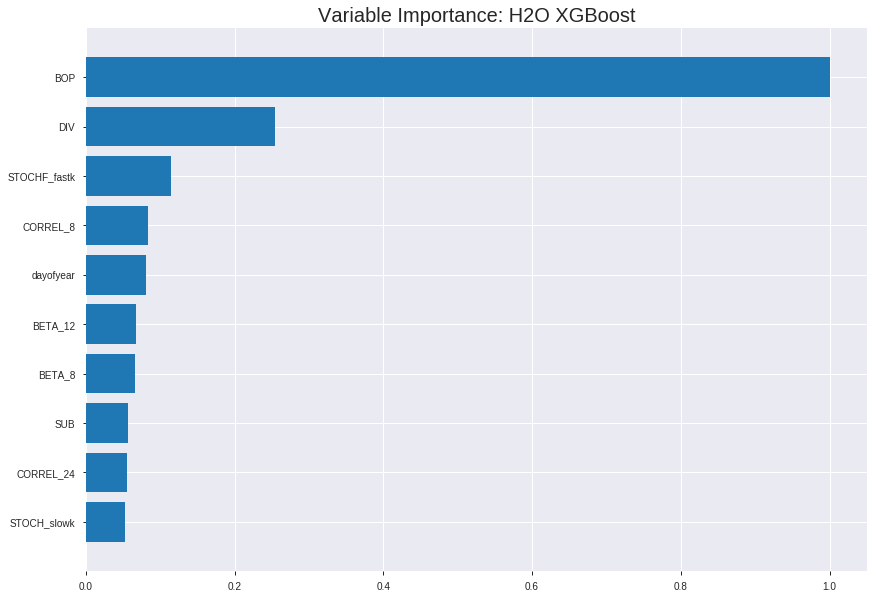

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_201452_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13917044298384626
RMSE: 0.3730555494612649
LogLoss: 0.44279653188220186
Mean Per-Class Error: 0.17625375645172214
AUC: 0.9076850361713098
pr_auc: 0.9129116368161199
Gini: 0.8153700723426196
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.500695638358593: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      671  190  0.2207   (190.0/861.0)
1      125  767  0.1401   (125.0/892.0)
Total  796  957  0.1797   (315.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.500696     0.829638  203
max f2                       0.326629     0.898123  282
max f0point5                 0.583218     0.844595  166
max accuracy                 0.535567     0.823731  187
max precision                0.937956     1         0
max recall                   0.199055     1         336
max specificity              0.937956     1         0
max absolute_mcc             0.535567     0.647422  187
max min_per_class_accuracy   0.535567     0.82287   187
max mean_per_class_accuracy  0.535567     0.823746  187

Gains/Lift Table: Avg response rate: 50.88 %, avg score: 50.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.896029           1.96525   1.96525            1                0.911218   1                           0.911218            0.0201794       0.0201794                  96.5247   96.5247
    2        0.0205362                   0.872776           1.96525   1.96525            1                0.885899   1                           0.898558            0.0201794       0.0403587                  96.5247   96.5247
    3        0.0302339                   0.8647             1.96525   1.96525            1                0.868214   1                           0.888825            0.0190583       0.059417                   96.5247   96.5247
    4        0.040502                    0.852711           1.96525   1.96525            1                0.859247   1                           0.881327            0.0201794       0.0795964                  96.5247   96.5247
    5        0.0501997                   0.84666            1.96525   1.96525            1                0.849856   1                           0.875247            0.0190583       0.0986547                  96.5247   96.5247
    6        0.100399                    0.808093           1.96525   1.96525            1                0.826469   1                           0.850858            0.0986547       0.197309                   96.5247   96.5247
    7        0.150029                    0.773034           1.94266   1.95777            0.988506         0.791503   0.996198                    0.831224            0.0964126       0.293722                   94.2658   95.7774
    8        0.200228                    0.741794           1.78659   1.91486            0.909091         0.756486   0.974359                    0.812486            0.0896861       0.383408                   78.6588   91.4856
    9        0.300057                    0.68525            1.67327   1.83448            0.851429         0.713905   0.93346                     0.779688            0.16704         0.550448                   67.3267   83.4479
    10       0.399886                    0.61484            1.43744   1.73536            0.731429         0.650794   0.883024                    0.747511            0.143498        0.693946                   43.7438   73.536
    11       0.500285                    0.539166           1.23945   1.63584            0.630682         0.576047   0.832383                    0.713101            0.124439        0.818386                   23.9445   63.5838
    12       0.600114                    0.459323           0.729949  1.48514            0.371429         0.497911   0.755703                    0.677304            0.07287         0.891256                   -27.0051  48.5144
    13       0.699943                    0.358729           0.628879  1.36302            0.32             0.40889    0.693562                    0.639021            0.0627803       0.954036                   -37.1121  36.3019
    14       0.799772                    0.25897            0.348129  1.23634            0.177143         0.305744   0.629101                    0.597421            0.0347534       0.988789                   -65.1871  23.6339
    15       0.899601                    0.150948           0.1123    1.1116             0.0571429        0.207074   0.565631                    0.554104            0.0112108       1                          -88.77    11.1604
    16       1                           0.0484582          0         1                  0                0.0988749  0.508842                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20887278765067674
RMSE: 0.45702602513497714
LogLoss: 0.6033695745495683
Mean Per-Class Error: 0.32677902621722854
AUC: 0.7252712954960145
pr_auc: 0.7345792085704973
Gini: 0.4505425909920291
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4382520914077759: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      110  124  0.5299   (124.0/234.0)
1      35   232  0.1311   (35.0/267.0)
Total  145  356  0.3174   (159.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.438252     0.744783  271
max f2                       0.135858     0.861957  374
max f0point5                 0.549699     0.690627  220
max accuracy                 0.455216     0.684631  260
max precision                0.905762     1         0
max recall                   0.113413     1         381
max specificity              0.905762     1         0
max absolute_mcc             0.438252     0.372952  271
max min_per_class_accuracy   0.574666     0.649573  198
max mean_per_class_accuracy  0.455216     0.673221  260

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 54.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.8744             1.8764    1.8764             1                0.890791  1                           0.890791            0.0224719       0.0224719                  87.6404   87.6404
    2        0.0219561                   0.864368           1.50112   1.70582            0.8              0.870379  0.909091                    0.881513            0.0149813       0.0374532                  50.1124   70.5822
    3        0.0319361                   0.855651           1.50112   1.64185            0.8              0.859019  0.875                       0.874483            0.0149813       0.0524345                  50.1124   64.1854
    4        0.0419162                   0.847804           1.8764    1.6977             1                0.850647  0.904762                    0.868808            0.0187266       0.071161                   87.6404   69.7699
    5        0.0518962                   0.833034           1.50112   1.6599             0.8              0.840719  0.884615                    0.863406            0.0149813       0.0861423                  50.1124   65.9896
    6        0.101796                    0.790165           1.50112   1.58207            0.8              0.808337  0.843137                    0.836412            0.0749064       0.161049                   50.1124   58.2067
    7        0.151697                    0.761598           1.57618   1.58013            0.84             0.777331  0.842105                    0.816977            0.0786517       0.2397                     57.618    58.013
    8        0.201597                    0.731161           1.42607   1.542              0.76             0.744736  0.821782                    0.799096            0.071161        0.310861                   42.6067   54.1996
    9        0.301397                    0.680072           1.05079   1.37934            0.56             0.705144  0.735099                    0.767986            0.104869        0.41573                    5.07865   37.9344
    10       0.401198                    0.633955           1.01326   1.28828            0.54             0.660648  0.686567                    0.741285            0.101124        0.516854                   1.32584   28.8278
    11       0.500998                    0.577382           1.23843   1.27835            0.66             0.606133  0.681275                    0.714362            0.123596        0.640449                   23.8427   27.8347
    12       0.600798                    0.527976           1.16337   1.25925            0.62             0.558569  0.671096                    0.688483            0.116105        0.756554                   16.3371   25.9248
    13       0.700599                    0.442971           0.97573   1.21886            0.52             0.486259  0.649573                    0.659676            0.0973783       0.853933                   -2.42697  21.8861
    14       0.800399                    0.333213           0.675506  1.15111            0.36             0.386575  0.613466                    0.625624            0.0674157       0.921348                   -32.4494  15.1111
    15       0.9002                      0.210985           0.487865  1.07758            0.26             0.272223  0.574279                    0.586444            0.0486891       0.970037                   -51.2135  7.75804
    16       1                           0.0461821          0.300225  1                  0.16             0.133128  0.532934                    0.541203          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 20:14:59  0.023 sec   0                  0.5              0.693147            0.5             0                  1                0.491158                         0.5                0.693147              0.5               0                    1                  0.467066
    2019-08-26 20:14:59  0.159 sec   5                  0.468791         0.632209            0.841311        0.836386           1.96525          0.253851                         0.483179           0.659839              0.700503          0.681074             1.25094            0.331337
    2019-08-26 20:14:59  0.244 sec   10                 0.446431         0.589346            0.852825        0.848934           1.96525          0.24073                          0.472659           0.638868              0.712355          0.70926              1.56367            0.353293
    2019-08-26 20:14:59  0.328 sec   15                 0.430011         0.557626            0.860662        0.85949            1.96525          0.223617                         0.465975           0.625184              0.71618           0.707341             1.56367            0.331337
    2019-08-26 20:14:59  0.421 sec   20                 0.418147         0.534079            0.865867        0.865269           1.96525          0.220194                         0.461341           0.615351              0.723703          0.71532              1.56367            0.333333
    2019-08-26 20:14:59  0.520 sec   25                 0.408891         0.515131            0.87205         0.871674           1.96525          0.221905                         0.458688           0.609271              0.727128          0.724878             1.56367            0.321357
    2019-08-26 20:14:59  0.631 sec   30                 0.400383         0.49786             0.880428        0.882424           1.96525          0.219053                         0.458221           0.607499              0.724007          0.725302             1.8764             0.321357
    2019-08-26 20:15:00  0.725 sec   35                 0.394544         0.485638            0.88527         0.8883             1.96525          0.196805                         0.457516           0.605384              0.724895          0.72953              1.56367            0.347305
    2019-08-26 20:15:00  0.822 sec   40                 0.389211         0.474798            0.890639        0.895129           1.96525          0.192242                         0.45718            0.604521              0.724967          0.729875             1.8764             0.341317
    2019-08-26 20:15:00  0.914 sec   45                 0.384412         0.465134            0.895561        0.900305           1.96525          0.185967                         0.456929           0.603848              0.725207          0.726991             1.56367            0.311377
    2019-08-26 20:15:00  1.007 sec   50                 0.379678         0.45576             0.900598        0.904718           1.96525          0.179692                         0.456867           0.603313              0.724815          0.727823             1.56367            0.311377
    2019-08-26 20:15:00  1.096 sec   55                 0.376877         0.44995             0.902954        0.907885           1.96525          0.183115                         0.457447           0.604072              0.723471          0

Variable Importances: 


variable       relative_importance    scaled_importance     percentage
-------------  ---------------------  --------------------  ----------------------
BOP            3562.292236328125      1.0                   0.39531684986994603
DIV            907.5501708984375      0.25476578300996033   0.10071320679414775
STOCHF_fastk   406.895751953125       0.11422301286896597   0.045154281630013934
CORREL_8       295.9593811035156      0.08308116276518045   0.03284338354786339
dayofyear      291.01873779296875     0.08169423463498317   0.03229510748843779
---            ---                    ---                   ---
month          18.928823471069336     0.005313663847686018  0.0021005808535350537
days_in_month  17.93239974975586      0.005033949648173697  0.0019900051173199493
CDLLONGLINE    15.381050109863281     0.004317739559098465  0.0017068752010616546
CDLTAKURI      12.117704391479492     0.003401659265318996  0.0013447332250968204
HT_TRENDMODE   3.8637337684631348     0.001084620101927888  0.00042876860199975245


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7131474103585658)

('F1', 0.7491408934707903)

('auc', 0.7673355346710693)

('logloss', 0.5757763265619309)

('mean_per_class_error', 0.2876555753111507)

('rmse', 0.44234921949641043)

('mse', 0.19567283198908347)

xgboost prediction progress: |████████████████████████████████████████████| 100%


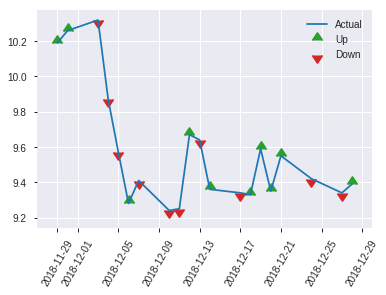


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19567283198908347
RMSE: 0.44234921949641043
LogLoss: 0.5757763265619309
Mean Per-Class Error: 0.2876555753111507
AUC: 0.7673355346710693
pr_auc: 0.7407822868143817
Gini: 0.5346710693421386
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43446245789527893: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      69   55   0.4435   (55.0/124.0)
1      18   109  0.1417   (18.0/127.0)
Total  87   164  0.2908   (73.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.434462     0.749141  163
max f2                       0.19464      0.85282   218
max f0point5                 0.619513     0.712831  90
max accuracy                 0.48462      0.713147  142
max precision                0.90818      1         0
max recall                   0.0560642    1         246
max specificity              0.90818      1         0
max absolute_mcc             0.434462     0.435698  163
max min_per_class_accuracy   0.542318     0.692913  122
max mean_per_class_accuracy  0.48462      0.712344  142

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 49.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.879819           1.97638   1.97638            1                0.892432   1                           0.892432            0.023622        0.023622                   97.6378   97.6378
    2        0.0239044                   0.876983           1.97638   1.97638            1                0.877712   1                           0.885072            0.023622        0.0472441                  97.6378   97.6378
    3        0.0318725                   0.83631            0         1.48228            0                0.855704   0.75                        0.87773             0               0.0472441                  -100      48.2283
    4        0.0438247                   0.826453           1.97638   1.61704            1                0.830463   0.818182                    0.864839            0.023622        0.0708661                  97.6378   61.7037
    5        0.0517928                   0.821225           1.97638   1.67232            1                0.823232   0.846154                    0.858438            0.015748        0.0866142                  97.6378   67.232
    6        0.103586                    0.776973           1.67232   1.67232            0.846154         0.79971    0.846154                    0.829074            0.0866142       0.173228                   67.232    67.232
    7        0.151394                    0.751646           1.48228   1.61231            0.75             0.762307   0.815789                    0.80799             0.0708661       0.244094                   48.2283   61.2308
    8        0.203187                    0.718004           1.21623   1.51135            0.615385         0.732579   0.764706                    0.788767            0.0629921       0.307087                   21.6233   51.1348
    9        0.302789                    0.649236           1.5811    1.53429            0.8              0.676984   0.776316                    0.751997            0.15748         0.464567                   58.1102   53.4293
    10       0.40239                     0.590383           1.10677   1.42847            0.56             0.622849   0.722772                    0.720029            0.110236        0.574803                   10.6772   42.8471
    11       0.501992                    0.534403           1.18583   1.38033            0.6              0.559582   0.698413                    0.688195            0.11811         0.692913                   18.5827   38.0327
    12       0.601594                    0.471613           1.10677   1.33504            0.56             0.499872   0.675497                    0.657015            0.110236        0.80315                    10.6772   33.5037
    13       0.701195                    0.382025           0.790551  1.2577             0.4              0.433271   0.636364                    0.625234            0.0787402       0.88189                    -20.9449  25.7695
    14       0.800797                    0.252466           0.553386  1.17009            0.28             0.290241   0.59204                     0.583568            0.0551181       0.937008                   -44.6614  17.0094
    15       0.900398                    0.148695           0.395276  1.08438            0.2              0.209575   0.548673                    0.542197            0.0393701       0.976378                   -60.4724  8.43844
    16       1                           0.0471704          0.237165  1                  0.12             0.0870363  0.505976                    0

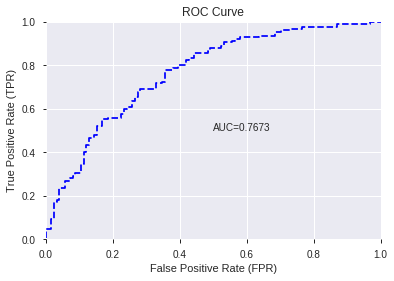

This function is available for GLM models only


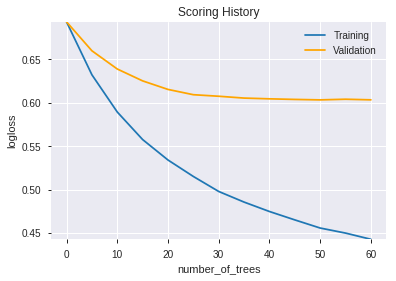

--2019-08-26 20:15:17--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.8.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.8.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.co

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_201452_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_201452_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_8650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'STOCHF_fastk',
 'CORREL_8',
 'dayofyear',
 'BETA_12',
 'BETA_8',
 'SUB',
 'CORREL_24',
 'STOCH_slowk',
 'STOCH_slowd',
 'WILLR_12',
 'TRANGE',
 'COS',
 'TANH',
 'ADOSC',
 'SAREXT',
 'WILLR_14',
 'ULTOSC',
 'CMO_8',
 'CORREL_20',
 'CDLCLOSINGMARUBOZU',
 'PLUS_DM_8',
 'CORREL_14',
 'aroonup_12',
 'WILLR_8',
 'aroonup_8',
 'dayofweek',
 'CORREL_12',
 'CDLHIGHWAVE',
 'CDLDRAGONFLYDOJI',
 'STOCHRSI_fastk',
 'CDLHAMMER',
 'CDLBELTHOLD',
 'STOCHF_fastd',
 'CDLSHORTLINE',
 'weekday_name',
 'month',
 'days_in_month',
 'CDLLONGLINE',
 'CDLTAKURI',
 'HT_TRENDMODE']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_201528_model_1  0.780163  0.564541              0.305118  0.438741  0.192494

variable  relative_importance  scaled_importance    percentage
0                          BOP             0.457860           1.000000  4.030443e-02
1           CDLCLOSINGMARUBOZU             0.170573           0.372543  1.501515e-02
2                          DIV             0.168887           0.368862  1.486676e-02
3                       TRANGE             0.151737           0.331404  1.335704e-02
4                          SUB             0.146249           0.319418  1.287395e-02
...                        ...                  ...                ...           ...
1035    BBANDS_lowerband_8_8_3             0.000020           0.000044  1.789927e-06
1036  BBANDS_middleband_12_3_2             0.000016           0.000035  1.421638e-06
1037   BBANDS_upperband_30_0_5             0.000015           0.000033  1.312382e-06
1038   BBANDS_upperband_12_1_2             0.000009           0.000020  7.901970e-07
1039                   MA_24_2             0.000006           0.000013  5.113478e-07

[1040 rows x 4 columns]

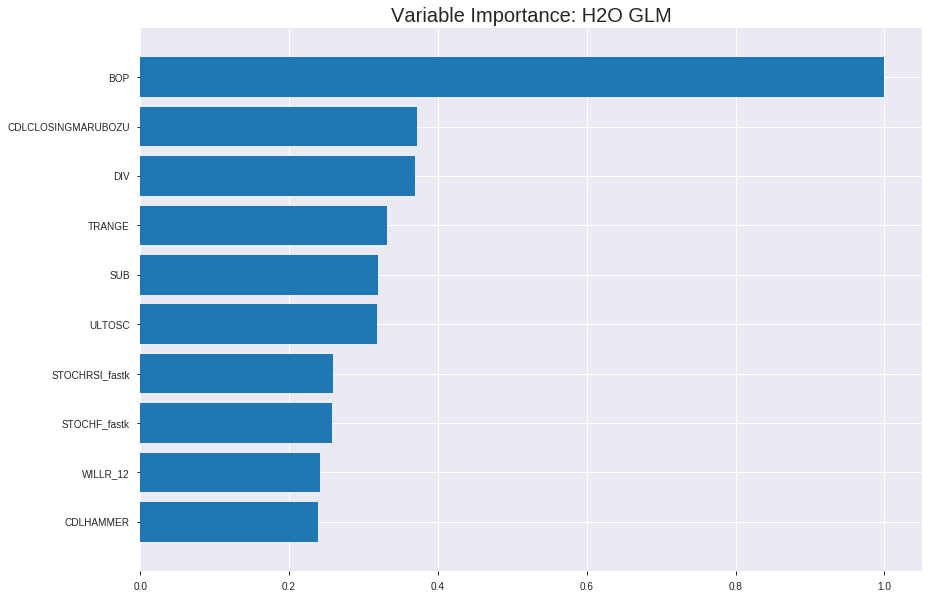

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_201528_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.17917161572022336
RMSE: 0.42328668266344427
LogLoss: 0.5371096066620825
Null degrees of freedom: 1752
Residual degrees of freedom: 712
Null deviance: 2429.6257833865593
Residual deviance: 1883.106280957261
AIC: 3965.1062809572613
AUC: 0.810305047316969
pr_auc: 0.7950803336422494
Gini: 0.6206100946339379
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3994829331107629: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      496  365   0.4239   (365.0/861.0)
1      113  779   0.1267   (113.0/892.0)
Total  609  1144  0.2727   (478.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.399483     0.765226  250
max f2                       0.218832     0.855315  332
max f0point5                 0.565323     0.751963  175
max accuracy                 0.455014     0.742156  223
max precision                0.990204     1         0
max recall                   0.089685     1         381
max specificity              0.990204     1         0
max absolute_mcc             0.455014     0.487791  223
max min_per_class_accuracy   0.520905     0.737515  194
max mean_per_class_accuracy  0.455014     0.740824  223

Gains/Lift Table: Avg response rate: 50.88 %, avg score: 50.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.916004           1.74689   1.74689            0.888889         0.934137  0.888889                    0.934137            0.0179372       0.0179372                  74.6886   74.6886
    2        0.0205362                   0.891447           1.85607   1.80148            0.944444         0.902075  0.916667                    0.918106            0.0190583       0.0369955                  85.6066   80.1476
    3        0.0302339                   0.878805           1.84964   1.81693            0.941176         0.884968  0.924528                    0.907477            0.0179372       0.0549327                  84.9644   81.6926
    4        0.040502                    0.866934           1.41934   1.71613            0.722222         0.872327  0.873239                    0.898566            0.014574        0.0695067                  41.9345   71.6131
    5        0.0501997                   0.850301           1.96525   1.76426            1                0.858781  0.897727                    0.89088             0.0190583       0.088565                   96.5247   76.4256
    6        0.100399                    0.807763           1.76426   1.76426            0.897727         0.825564  0.897727                    0.858222            0.088565        0.17713                    76.4256   76.4256
    7        0.150029                    0.774801           1.58123   1.70371            0.804598         0.791819  0.86692                     0.836256            0.0784753       0.255605                   58.1233   70.3712
    8        0.200228                    0.737531           1.56326   1.6685             0.795455         0.756321  0.849003                    0.816215            0.0784753       0.334081                   56.3264   66.85
    9        0.300057                    0.669461           1.54974   1.62899            0.788571         0.705006  0.828897                    0.779216            0.154709        0.488789                   54.9737   62.8988
    10       0.399886                    0.600704           1.29145   1.54472            0.657143         0.635969  0.78602                     0.743455            0.128924        0.617713                   29.1448   54.4723
    11       0.500285                    0.525187           1.13895   1.46329            0.579545         0.56495   0.744584                    0.707632            0.11435         0.732063                   13.895    46.3291
    12       0.600114                    0.437924           0.965778  1.38053            0.491429         0.481214  0.702471                    0.669968            0.0964126       0.828475                   -3.42217  38.053
    13       0.699943                    0.362808           0.707489  1.28454            0.36             0.400653  0.653627                    0.631557            0.0706278       0.899103                   -29.2511  28.4538
    14       0.799772                    0.277174           0.482889  1.18447            0.245714         0.321278  0.60271                     0.592827            0.0482063       0.947309                   -51.7111  18.4475
    15       0.899601                    0.180339           0.325669  1.08917            0.165714         0.230585  0.554217                    0.552629            0.0325112       0.979821                   -67.4331  8.91728
    16       1                           0.0163759          0.200991  1                  0.102273         0.1165    0.508842                    0.508842            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19673029303651912
RMSE: 0.44354288748273163
LogLoss: 0.5775619679389604
Null degrees of freedom: 500
Residual degrees of freedom: -540
Null deviance: 693.5229098211739
Residual deviance: 578.7170918748382
AIC: 2660.717091874838
AUC: 0.7617721437946158
pr_auc: 0.7530571696632758
Gini: 0.5235442875892315
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42177101674872014: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      116  118  0.5043   (118.0/234.0)
1      32   235  0.1199   (32.0/267.0)
Total  148  353  0.2994   (150.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.421771     0.758065  273
max f2                       0.273758     0.868984  334
max f0point5                 0.61971      0.723385  162
max accuracy                 0.453423     0.706587  258
max precision                0.889611     0.928571  12
max recall                   0.0797956    1         387
max specificity              0.939276     0.995726  0
max absolute_mcc             0.451085     0.415185  259
max min_per_class_accuracy   0.549876     0.692884  197
max mean_per_class_accuracy  0.549876     0.699006  197

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 53.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.918199           1.56367   1.56367            0.833333         0.927013  0.833333                    0.927013            0.0187266       0.0187266                  56.367    56.367
    2        0.0219561                   0.898516           1.8764    1.70582            1                0.90759   0.909091                    0.918185            0.0187266       0.0374532                  87.6404   70.5822
    3        0.0319361                   0.888482           1.50112   1.64185            0.8              0.891328  0.875                       0.909792            0.0149813       0.0524345                  50.1124   64.1854
    4        0.0419162                   0.876184           1.50112   1.60835            0.8              0.881094  0.857143                    0.902959            0.0149813       0.0674157                  50.1124   60.8347
    5        0.0518962                   0.861857           1.50112   1.58773            0.8              0.864499  0.846154                    0.895563            0.0149813       0.082397                   50.1124   58.7727
    6        0.101796                    0.821754           1.35101   1.47169            0.72             0.836823  0.784314                    0.866769            0.0674157       0.149813                   35.1011   47.169
    7        0.151697                    0.794702           1.80135   1.58013            0.96             0.806807  0.842105                    0.847044            0.0898876       0.2397                     80.1348   58.013
    8        0.201597                    0.749998           1.57618   1.57915            0.84             0.776429  0.841584                    0.829565            0.0786517       0.318352                   57.618    57.9152
    9        0.301397                    0.69007            1.23843   1.46633            0.66             0.718791  0.781457                    0.792885            0.123596        0.441948                   23.8427   46.6329
    10       0.401198                    0.625054           1.27596   1.41897            0.68             0.65339   0.756219                    0.758185            0.127341        0.569288                   27.5955   41.8973
    11       0.500998                    0.564686           1.16337   1.36806            0.62             0.598379  0.729084                    0.726351            0.116105        0.685393                   16.3371   36.8056
    12       0.600798                    0.488958           0.900674  1.29042            0.48             0.515409  0.687708                    0.691311            0.0898876       0.775281                   -9.93258  29.0418
    13       0.700599                    0.423348           0.97573   1.24559            0.52             0.458136  0.663818                    0.658095            0.0973783       0.872659                   -2.42697  24.559
    14       0.800399                    0.322331           0.562921  1.16047            0.3              0.373094  0.618454                    0.622559            0.0561798       0.928839                   -43.7079  16.047
    15       0.9002                      0.212191           0.487865  1.0859             0.26             0.269454  0.578714                    0.583412            0.0486891       0.977528                   -51.2135  8.59015
    16       1                           0.000704028        0.225169  1                  0.12             0.128757  0.532934                    0.538037            0.


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-26 20:15:31  0.000 sec   2            .22E2     1019          1.3573009022899853  1.352326239261856
     2019-08-26 20:15:33  2.206 sec   4            .16E2     1036          1.349854456957162   1.3449377373968925
     2019-08-26 20:15:36  4.577 sec   6            .12E2     1037          1.3407981733759693  1.336186271695015
     2019-08-26 20:15:38  6.749 sec   8            .84E1     1037          1.3298744009348624  1.3258810624074917
     2019-08-26 20:15:40  8.892 sec   10           .61E1     1037          1.3168865205938325  1.3139198197329107
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-26 20:16:15  43.912 sec  42           .38E-1    1041          1.065642267721542   1.1562149846060576
     2019-08-26 20:16:17  46.100 sec  44           .28E-1    1041          1.0576758874654257  1.1583950624794321
     2019-08-26 20:16:19  48.174 sec  46           .2E-1     1041          1.0502247354962477  1.161599832931772
     2019-08-26 20:16:21  50.237 sec  48           .15E-1    1041          1.0431882140006914  1.1658709445377353
     2019-08-26 20:16:24  52.328 sec  50           .11E-1    1041          1.0364970642406408  1.171184991678959


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7330677290836654)

('F1', 0.7483443708609271)

('auc', 0.7801625603251207)

('logloss', 0.5645408180207008)

('mean_per_class_error', 0.26701803403606805)

('rmse', 0.4387412411470154)

('mse', 0.1924938766832235)

glm prediction progress: |████████████████████████████████████████████████| 100%


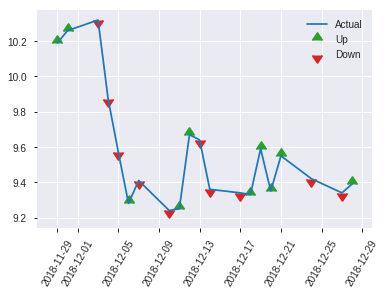


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1924938766832235
RMSE: 0.4387412411470154
LogLoss: 0.5645408180207008
Null degrees of freedom: 250
Residual degrees of freedom: -790
Null deviance: 347.9322754570597
Residual deviance: 283.39949064639177
AIC: 2365.3994906463918
AUC: 0.7801625603251207
pr_auc: 0.7653195447755097
Gini: 0.5603251206502413
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3644192780611658: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   62   0.5      (62.0/124.0)
1      14   113  0.1102   (14.0/127.0)
Total  76   175  0.3028   (76.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.364419     0.748344  174
max f2                       0.209125     0.861111  211
max f0point5                 0.48766      0.735524  127
max accuracy                 0.48766      0.733068  127
max precision                0.9186       1         0
max recall                   0.115235     1         238
max specificity              0.9186       1         0
max absolute_mcc             0.48766      0.466023  127
max min_per_class_accuracy   0.489207     0.725806  126
max mean_per_class_accuracy  0.48766      0.732982  127

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 48.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.907057           1.97638   1.97638            1                0.91733   1                           0.91733             0.023622        0.023622                   97.6378   97.6378
    2        0.0239044                   0.875011           1.97638   1.97638            1                0.882845  1                           0.900088            0.023622        0.0472441                  97.6378   97.6378
    3        0.0318725                   0.871605           1.97638   1.97638            1                0.873896  1                           0.89354             0.015748        0.0629921                  97.6378   97.6378
    4        0.0438247                   0.854868           1.31759   1.79671            0.666667         0.862442  0.909091                    0.885059            0.015748        0.0787402                  31.7585   79.6707
    5        0.0517928                   0.840934           0.988189  1.67232            0.5              0.849072  0.846154                    0.879522            0.00787402      0.0866142                  -1.1811   67.232
    6        0.103586                    0.796196           1.97638   1.82435            1                0.815151  0.923077                    0.847337            0.102362        0.188976                   97.6378   82.4349
    7        0.151394                    0.760933           1.31759   1.66432            0.666667         0.780319  0.842105                    0.826173            0.0629921       0.251969                   31.7585   66.4318
    8        0.203187                    0.698544           1.36826   1.58885            0.692308         0.731135  0.803922                    0.801948            0.0708661       0.322835                   36.8262   58.8853
    9        0.302789                    0.649482           1.5811    1.5863             0.8              0.672611  0.802632                    0.759403            0.15748         0.480315                   58.1102   58.6303
    10       0.40239                     0.572125           1.10677   1.46761            0.56             0.615412  0.742574                    0.723762            0.110236        0.590551                   10.6772   46.7607
    11       0.501992                    0.491519           1.34394   1.44307            0.68             0.528206  0.730159                    0.684961            0.133858        0.724409                   34.3937   44.307
    12       0.601594                    0.420192           0.790551  1.33504            0.4              0.457327  0.675497                    0.647273            0.0787402       0.80315                    -20.9449  33.5037
    13       0.701195                    0.360034           0.869606  1.26892            0.44             0.3886    0.642045                    0.61053             0.0866142       0.889764                   -13.0394  26.8924
    14       0.800797                    0.243424           0.395276  1.16026            0.2              0.302422  0.587065                    0.572208            0.0393701       0.929134                   -60.4724  16.0262
    15       0.900398                    0.16346            0.553386  1.09313            0.28             0.202565  0.553097                    0.531318            0.0551181       0.984252                   -44.6614  9.31294
    16       1                           0.0138848          0.15811   1                  0.08             0.102012  0.505976                    0.488559           

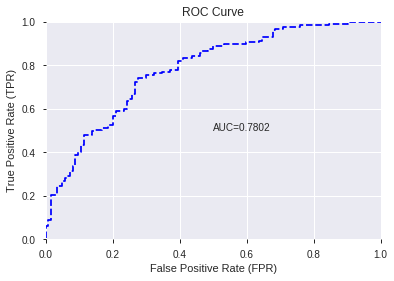

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


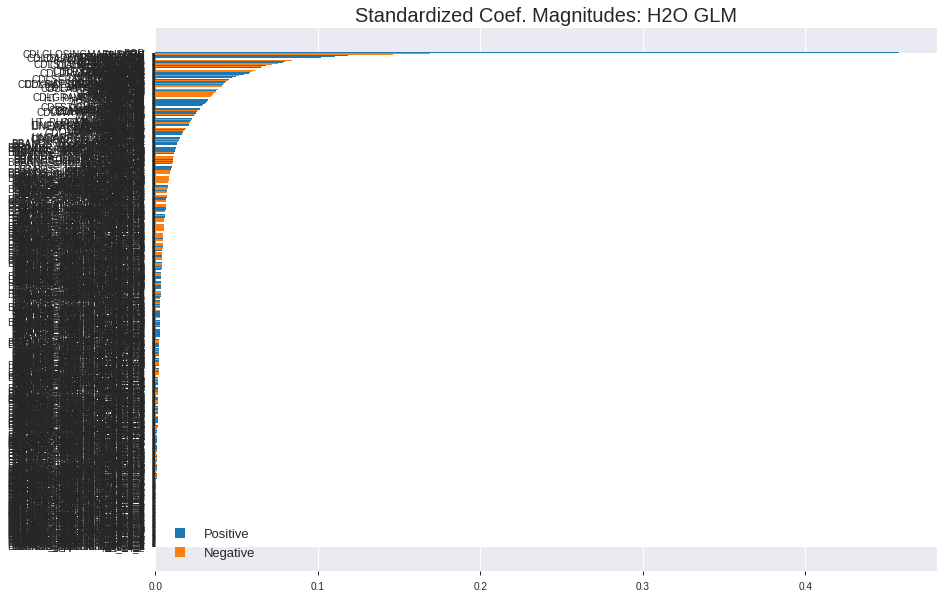

'log_likelihood'
--2019-08-26 20:16:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.134.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.134.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_201528_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_201528_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_8650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

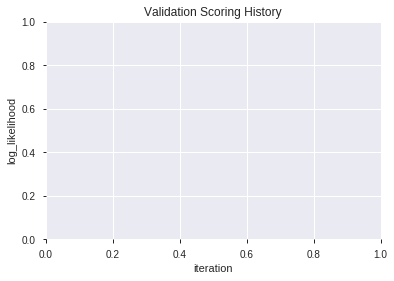

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_201658_model_3  0.757747  0.580548              0.305499  0.444680  0.197740
1  XGBoost_grid_1_AutoML_20190826_201658_model_1  0.749174  0.589163              0.308865  0.449107  0.201697
2  XGBoost_grid_1_AutoML_20190826_201658_model_6  0.745174  0.588978              0.346203  0.450168  0.202651
3               XGBoost_2_AutoML_20190826_201658  0.742189  0.594528              0.325375  0.451583  0.203927
4               XGBoost_1_AutoML_20190826_201658  0.740538  0.595251              0.301181  0.451482  0.203836
5               XGBoost_3_AutoML_20190826_201658  0.740221  0.596603              0.291974  0.452863  0.205085
6  XGBoost_grid_1_AutoML_20190826_201658_model_4  0.739967  0.595076              0.300610  0.451349  0.203716
7  XGBoost_grid_1_AutoML_20190826_201658_model_2  0.739586  0.594034              0.296196  0.451734  0.204064
8  XGBoost_grid_1_AutoML_20190826_201658_model_5  0.736982  0.602681              0.300610  0.454742  0.206790
9  XGBoost_grid_1_AutoML_20190826_201658_model_7  0.727140  0.612693              0.325375  0.458469  0.210194

variable  relative_importance  scaled_importance  percentage
0                        BOP          1710.564331           1.000000    0.189196
1                        DIV           460.540131           0.269233    0.050938
2               STOCHF_fastk           388.037018           0.226847    0.042919
3             STOCHRSI_fastk           184.978271           0.108139    0.020459
4                        SUB           151.915237           0.088810    0.016802
..                       ...                  ...                ...         ...
312  BBANDS_lowerband_14_3_5             0.944685           0.000552    0.000104
313   LINEARREG_INTERCEPT_20             0.865181           0.000506    0.000096
314  BBANDS_lowerband_20_7_3             0.261469           0.000153    0.000029
315              MIDPRICE_30             0.239639           0.000140    0.000027
316               MACDFIX_20             0.034193           0.000020    0.000004

[317 rows x 4 columns]

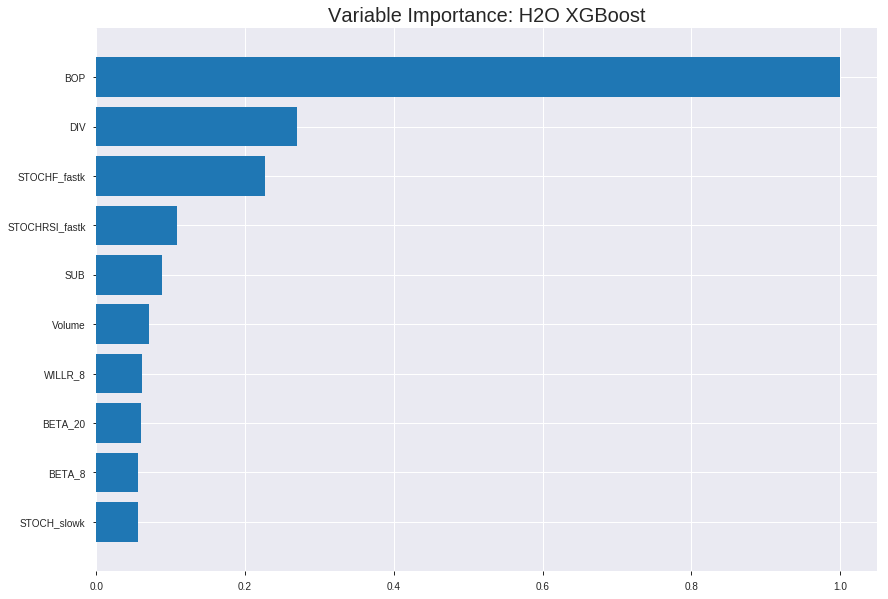

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_201658_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12352627722421664
RMSE: 0.3514630524311434
LogLoss: 0.4094989816955997
Mean Per-Class Error: 0.1379106055634547
AUC: 0.9410191507424364
pr_auc: 0.9451135961976922
Gini: 0.8820383014848727
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.516508013010025: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      733  128  0.1487   (128.0/861.0)
1      115  777  0.1289   (115.0/892.0)
Total  848  905  0.1386   (243.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.516508     0.864775  193
max f2                       0.407508     0.911031  240
max f0point5                 0.608169     0.890592  148
max accuracy                 0.533878     0.861951  184
max precision                0.923114     1         0
max recall                   0.172196     1         346
max specificity              0.923114     1         0
max absolute_mcc             0.533878     0.724068  184
max min_per_class_accuracy   0.526623     0.860987  188
max mean_per_class_accuracy  0.533878     0.862089  184

Gains/Lift Table: Avg response rate: 50.88 %, avg score: 50.94 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.892504           1.96525    1.96525            1                0.903045  1                           0.903045            0.0201794       0.0201794                  96.5247   96.5247
    2        0.0205362                   0.877339           1.96525    1.96525            1                0.88595   1                           0.894497            0.0201794       0.0403587                  96.5247   96.5247
    3        0.0302339                   0.869407           1.96525    1.96525            1                0.873274  1                           0.88769             0.0190583       0.059417                   96.5247   96.5247
    4        0.040502                    0.861144           1.96525    1.96525            1                0.865108  1                           0.881965            0.0201794       0.0795964                  96.5247   96.5247
    5        0.0501997                   0.855416           1.96525    1.96525            1                0.858204  1                           0.877375            0.0190583       0.0986547                  96.5247   96.5247
    6        0.100399                    0.823439           1.96525    1.96525            1                0.838515  1                           0.857945            0.0986547       0.197309                   96.5247   96.5247
    7        0.150029                    0.791263           1.94266    1.95777            0.988506         0.80708   0.996198                    0.841119            0.0964126       0.293722                   94.2658   95.7774
    8        0.200228                    0.755197           1.94291    1.95405            0.988636         0.772903  0.994302                    0.824016            0.0975336       0.391256                   94.2914   95.4049
    9        0.300057                    0.690785           1.84172    1.91668            0.937143         0.72137   0.975285                    0.789866            0.183857        0.575112                   84.1717   91.6676
    10       0.399886                    0.620133           1.60589    1.83909            0.817143         0.654239  0.935806                    0.756007            0.160314        0.735426                   60.5887   83.909
    11       0.500285                    0.532311           1.20595    1.71203            0.613636         0.573996  0.871152                    0.719481            0.121076        0.856502                   20.5947   71.2028
    12       0.600114                    0.445757           0.718719   1.54679            0.365714         0.487044  0.787072                    0.680815            0.0717489       0.928251                   -28.1281  54.6791
    13       0.699943                    0.345409           0.460429   1.39185            0.234286         0.393995  0.708231                    0.639907            0.0459641       0.974215                   -53.9571  39.1849
    14       0.799772                    0.248274           0.20214    1.24335            0.102857         0.296434  0.632668                    0.597034            0.0201794       0.994395                   -79.786   24.3348
    15       0.899601                    0.158193           0.0561499  1.1116             0.0285714        0.205135  0.565631                    0.553545            0.00560538      1                          -94.385   11.1604
    16       1                           0.0439652          0          1                  0                0.114147  0.508842                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20859597901814142
RMSE: 0.45672308789696786
LogLoss: 0.605261143695035
Mean Per-Class Error: 0.317007586670508
AUC: 0.7278482025673038
pr_auc: 0.7089445352245339
Gini: 0.4556964051346075
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41320928931236267: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      103  131  0.5598   (131.0/234.0)
1      30   237  0.1124   (30.0/267.0)
Total  133  368  0.3214   (161.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.413209     0.746457  281
max f2                       0.220255     0.863755  367
max f0point5                 0.556145     0.703649  203
max accuracy                 0.495288     0.688623  240
max precision                0.943438     1         0
max recall                   0.179711     1         379
max specificity              0.943438     1         0
max absolute_mcc             0.494793     0.37396   241
max min_per_class_accuracy   0.567842     0.666667  193
max mean_per_class_accuracy  0.556145     0.682992  203

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 54.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.879271           1.25094   1.25094            0.666667         0.906441  0.666667                    0.906441            0.0149813       0.0149813                  25.0936   25.0936
    2        0.0219561                   0.858128           1.50112   1.36466            0.8              0.866766  0.727273                    0.888407            0.0149813       0.0299625                  50.1124   36.4658
    3        0.0319361                   0.850207           1.50112   1.4073             0.8              0.853919  0.75                        0.877629            0.0149813       0.0449438                  50.1124   40.7303
    4        0.0419162                   0.835176           1.8764    1.51899            1                0.838888  0.809524                    0.868405            0.0187266       0.0636704                  87.6404   51.8994
    5        0.0518962                   0.828334           1.50112   1.51556            0.8              0.829964  0.807692                    0.861013            0.0149813       0.0786517                  50.1124   51.5557
    6        0.101796                    0.789648           1.42607   1.47169            0.76             0.806172  0.784314                    0.83413             0.071161        0.149813                   42.6067   47.169
    7        0.151697                    0.754801           1.42607   1.45668            0.76             0.772393  0.776316                    0.813822            0.071161        0.220974                   42.6067   45.6682
    8        0.201597                    0.722547           1.35101   1.43053            0.72             0.735035  0.762376                    0.79432             0.0674157       0.28839                    35.1011   43.0526
    9        0.301397                    0.667956           1.31348   1.39177            0.7              0.695466  0.741722                    0.761587            0.131086        0.419476                   31.3483   39.177
    10       0.401198                    0.618615           1.2009    1.34429            0.64             0.639984  0.716418                    0.731337            0.11985         0.539326                   20.0899   34.429
    11       0.500998                    0.574229           1.12584   1.30077            0.6              0.594604  0.693227                    0.7041              0.11236         0.651685                   12.5843   30.0774
    12       0.600798                    0.517865           1.12584   1.27172            0.6              0.546255  0.677741                    0.67788             0.11236         0.764045                   12.5843   27.1716
    13       0.700599                    0.440797           0.863146  1.21352            0.46             0.481081  0.646724                    0.649845            0.0861423       0.850187                   -13.6854  21.3515
    14       0.800399                    0.352492           0.600449  1.13707            0.32             0.398134  0.605985                    0.61846             0.0599251       0.910112                   -39.9551  13.7073
    15       0.9002                      0.260465           0.675506  1.0859             0.36             0.309645  0.578714                    0.584223            0.0674157       0.977528                   -32.4494  8.59015
    16       1                           0.066684           0.225169  1                  0.12             0.179943  0.532934                    0.543876            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 20:17:26  8.464 sec   0                  0.5              0.693147            0.5             0                  1                0.491158                         0.5                0.693147              0.5               0                    1                  0.467066
    2019-08-26 20:17:28  9.720 sec   5                  0.470263         0.635078            0.857526        0.850549           1.96525          0.243582                         0.486276           0.665925              0.689987          0.669003             1.07223            0.37525
    2019-08-26 20:17:28  10.097 sec  10                 0.44875          0.59415             0.878665        0.878021           1.96525          0.214489                         0.476514           0.646571              0.714371          0.695413             1.25094            0.351297
    2019-08-26 20:17:28  10.492 sec  15                 0.429697         0.558093            0.884982        0.885655           1.96525          0.212208                         0.469052           0.631702              0.725831          0.702027             1.25094            0.371257
    2019-08-26 20:17:29  10.873 sec  20                 0.416099         0.532181            0.890581        0.890482           1.96525          0.200799                         0.465884           0.625137              0.721582          0.692532             0.938202           0.353293
    2019-08-26 20:17:29  11.259 sec  25                 0.405461         0.511277            0.895164        0.896326           1.96525          0.210496                         0.463821           0.620578              0.721926          0.699725             1.25094            0.321357
    2019-08-26 20:17:29  11.665 sec  30                 0.39585          0.492779            0.901975        0.904054           1.96525          0.193953                         0.461748           0.616215              0.72123           0.698843             1.25094            0.315369
    2019-08-26 20:17:30  12.053 sec  35                 0.387199         0.475973            0.909399        0.912367           1.96525          0.175699                         0.459611           0.611793              0.723671          0.697064             0.938202           0.317365
    2019-08-26 20:17:30  12.452 sec  40                 0.380451         0.462601            0.913316        0.916959           1.96525          0.180262                         0.457747           0.607911              0.729889          0.705802             0.938202           0.327345
    2019-08-26 20:17:31  12.843 sec  45                 0.374889         0.451841            0.918298        0.922435           1.96525          0.176269                         0.456074           0.60413               0.732594          0.711692             1.25094            0.313373
    2019-08-26 20:17:31  13.226 sec  50                 0.3689           0.440612            0.923979        0.928292           1.96525          0.175128                         0.455406           0.603059              0.733354          0.711237             1.56367            0.319361
    2019-08-26 20:17:31  13.624 sec  55                 0.362855         0.429746            0.930718        0.935207           1.96525          0.154592                         0.456591           0.60563               0.728985          0.

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      1710.5643310546875     1.0                     0.18919576495082133
DIV                      460.5401306152344      0.26923286207615343     0.050937717290396825
STOCHF_fastk             388.0370178222656      0.22684736889317256     0.04291856148482493
STOCHRSI_fastk           184.978271484375       0.10813874002056527     0.020459391639008843
SUB                      151.9152374267578      0.08881001121605933     0.016802478007313364
---                      ---                    ---                     ---
BBANDS_lowerband_14_3_5  0.9446849822998047     0.0005522651005573919   0.000104486218155598
LINEARREG_INTERCEPT_20   0.8651809692382812     0.0005057868643296415   9.569273269892381e-05
BBANDS_lowerband_20_7_3  0.26146888732910156    0.00015285533702663316  2.8919582415569462e-05
MIDPRICE_30              0.2396392822265625     0.00014009369766222556  2.650513429399385e-05
MACDFIX_20               0.03419303894042969    1.998933236223112e-05   3.781897027128524e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7211155378486056)

('F1', 0.7548387096774194)

('auc', 0.7577470154940309)

('logloss', 0.5805481057478129)

('mean_per_class_error', 0.27844805689611385)

('rmse', 0.44467976553492744)

('mse', 0.19774009387619806)

xgboost prediction progress: |████████████████████████████████████████████| 100%


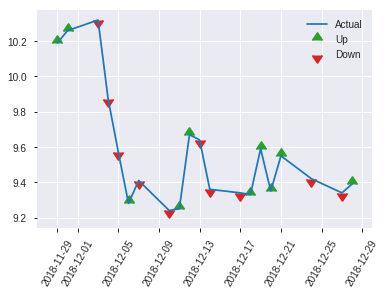


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19774009387619806
RMSE: 0.44467976553492744
LogLoss: 0.5805481057478129
Mean Per-Class Error: 0.27844805689611385
AUC: 0.7577470154940309
pr_auc: 0.7141601492884385
Gini: 0.5154940309880618
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31427067518234253: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      58   66   0.5323   (66.0/124.0)
1      10   117  0.0787   (10.0/127.0)
Total  68   183  0.3028   (76.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.314271     0.754839  182
max f2                       0.234692     0.854342  205
max f0point5                 0.582489     0.731092  116
max accuracy                 0.582489     0.721116  116
max precision                0.906134     1         0
max recall                   0.0757102    1         248
max specificity              0.906134     1         0
max absolute_mcc             0.582489     0.444092  116
max min_per_class_accuracy   0.561827     0.717742  126
max mean_per_class_accuracy  0.582489     0.721552  116

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 50.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.867186           1.97638   1.97638            1                0.894687  1                           0.894687            0.023622        0.023622                   97.6378   97.6378
    2        0.0239044                   0.833508           1.31759   1.64698            0.666667         0.843056  0.833333                    0.868872            0.015748        0.0393701                  31.7585   64.6982
    3        0.0318725                   0.820227           1.97638   1.72933            1                0.828633  0.875                       0.858812            0.015748        0.0551181                  97.6378   72.9331
    4        0.0438247                   0.806566           0.658793  1.43737            0.333333         0.811427  0.727273                    0.845889            0.00787402      0.0629921                  -34.1207  43.7366
    5        0.0517928                   0.79559            1.97638   1.52029            1                0.799508  0.769231                    0.838753            0.015748        0.0787402                  97.6378   52.0291
    6        0.103586                    0.775022           1.67232   1.59631            0.846154         0.78289   0.807692                    0.810822            0.0866142       0.165354                   67.232    59.6305
    7        0.151394                    0.739069           0.988189  1.40427            0.5              0.755683  0.710526                    0.79341             0.0472441       0.212598                   -1.1811   40.4269
    8        0.203187                    0.719393           1.52029   1.43384            0.769231         0.728264  0.72549                     0.776804            0.0787402       0.291339                   52.0291   43.3843
    9        0.302789                    0.676935           1.34394   1.40427            0.68             0.698175  0.710526                    0.750939            0.133858        0.425197                   34.3937   40.4269
    10       0.40239                     0.616548           1.66016   1.46761            0.84             0.64862   0.742574                    0.725612            0.165354        0.590551                   66.0157   46.7607
    11       0.501992                    0.5633             1.26488   1.42738            0.64             0.588346  0.722222                    0.698377            0.125984        0.716535                   26.4882   42.7384
    12       0.601594                    0.485243           0.711496  1.30886            0.36             0.527059  0.662252                    0.670013            0.0708661       0.787402                   -28.8504  30.886
    13       0.701195                    0.370535           1.02772   1.26892            0.52             0.430568  0.642045                    0.636001            0.102362        0.889764                   2.77165   26.8924
    14       0.800797                    0.245933           0.553386  1.17993            0.28             0.295479  0.597015                    0.593648            0.0551181       0.944882                   -44.6614  17.9927
    15       0.900398                    0.15175            0.31622   1.08438            0.16             0.199799  0.548673                    0.55008             0.0314961       0.976378                   -68.378   8.43844
    16       1                           0.0711548          0.237165  1                  0.12             0.115173  0.505976                    0.506763          

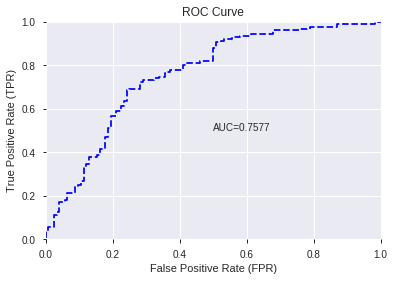

This function is available for GLM models only


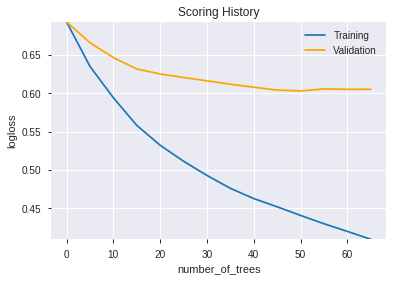

--2019-08-26 20:18:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(SharedTreeNode.java:133)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_201658_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_201658_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_8650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_201814_model_7  0.760287  0.651636              0.297054  0.456349  0.208255
1  DeepLearning_grid_1_AutoML_20190826_201814_model_9  0.756096  0.578882              0.293117  0.444634  0.197700
2  DeepLearning_grid_1_AutoML_20190826_201814_model_5  0.752477  0.596009              0.308198  0.453549  0.205706
3  DeepLearning_grid_1_AutoML_20190826_201814_model_8  0.744856  0.603872              0.362522  0.457144  0.208981
4  DeepLearning_grid_1_AutoML_20190826_201814_model_6  0.738506  0.613039              0.309055  0.454858  0.206895
5               DeepLearning_1_AutoML_20190826_201814  0.732283  0.614883              0.325375  0.460158  0.211746
6  DeepLearning_grid_1_AutoML_20190826_201814_model_3  0.726632  0.693149              0.341599  0.470968  0.221811
7  DeepLearning_grid_1_AutoML_20190826_201814_model_4  0.721171  0.780864              0.333344  0.495443  0.245464
8  DeepLearning_grid_1_AutoML_20190826_201814_model_1  0.700660  0.854515              0.418688  0.503411  0.253423
9  DeepLearning_grid_1_AutoML_20190826_201814_model_2  0.675197  0.754252              0.377604  0.501244  0.251245

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.022497
1          CDLHIGHWAVE             0.938557           0.938557    0.021115
2            CDLTAKURI             0.933430           0.933430    0.020999
3            CORREL_20             0.914534           0.914534    0.020574
4                  COS             0.913632           0.913632    0.020554
5    CDLDARKCLOUDCOVER             0.911678           0.911678    0.020510
6         CDLSHORTLINE             0.911240           0.911240    0.020500
7               BETA_8             0.910745           0.910745    0.020489
8            dayofweek             0.905512           0.905512    0.020371
9                  DIV             0.905423           0.905423    0.020369
10              SAREXT             0.903090           0.903090    0.020317
11         CDLMARUBOZU             0.902751           0.902751    0.020309
12             BETA_12             0.901888           0.901888    0.020290
13        is_month_end             0.900381           0.900381    0.020256
14    CDLDRAGONFLYDOJI             0.900337           0.900337    0.020255
15        STOCHF_fastd             0.899093           0.899093    0.020227
16       CDLHANGINGMAN             0.897463           0.897463    0.020190
17         CDLLONGLINE             0.896398           0.896398    0.020166
18         STOCH_slowk             0.893123           0.893123    0.020093
19      is_month_start             0.892629           0.892629    0.020082
20      STOCHRSI_fastk             0.891782           0.891782    0.020063
21       days_in_month             0.890851           0.890851    0.020042
22           CDLHAMMER             0.890655           0.890655    0.020037
23            WILLR_14             0.889647           0.889647    0.020015
24        STOCHF_fastk             0.889173           0.889173    0.020004
25              TRANGE             0.888711           0.888711    0.019993
26               CMO_8             0.888448           0.888448    0.019988
27                TANH             0.887698           0.887698    0.019971
28           dayofyear             0.887065           0.887065    0.019956
29           CORREL_14             0.883603           0.883603    0.019879
30           aroonup_8             0.883200           0.883200    0.019869
31        CDLENGULFING             0.882741           0.882741    0.019859
32                 SUB             0.880233           0.880233    0.019803
33             WILLR_8             0.878804           0.878804    0.019771
34  CDLCLOSINGMARUBOZU             0.877775           0.877775    0.019747
35          CDL3INSIDE             0.877369           0.877369    0.019738
36         STOCH_slowd             0.876387           0.876387    0.019716
37         CDLBELTHOLD             0.875774           0.875774    0.019702
38            WILLR_12             0.874735           0.874735    0.019679
39               month             0.872183           0.872183    0.019622
40           PLUS_DM_8             0.871734           0.871734    0.019612
41              ULTOSC             0.871650           0.871650    0.019610
42           CORREL_12             0.866752           0.866752    0.019499
43        HT_TRENDMODE             0.862105           0.862105    0.019395
44          aroonup_12             0.860855           0.860855    0.019367
45        weekday_name             0.854220           0.854220    0.019217
46            CORREL_8             0.853644           0.853644    0.019205
47               ADOSC             0.851052           0.851052    0.019146
48             quarter             0.829931           0.829931    0.018671
49           CORREL_24             0.829433           0.829433    0.018660

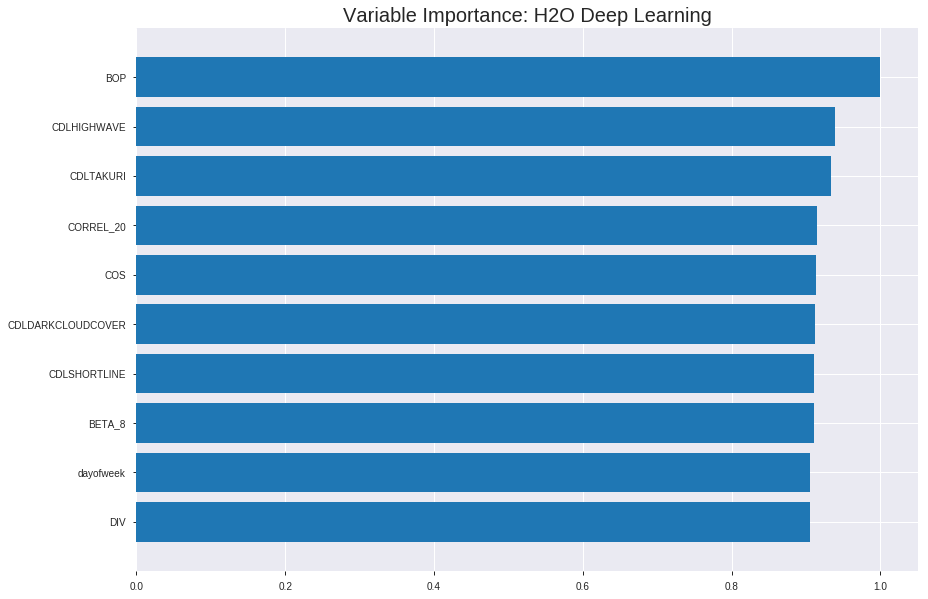

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_201814_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18445948285004993
RMSE: 0.4294874653002692
LogLoss: 0.5536438296262817
Mean Per-Class Error: 0.2669131471904085
AUC: 0.808703509840992
pr_auc: 0.7994973780062394
Gini: 0.6174070196819841
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4874079978830966: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      535  326   0.3786   (326.0/861.0)
1      142  750   0.1592   (142.0/892.0)
Total  677  1076  0.267    (468.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.487408     0.762195  220
max f2                       0.0970464    0.861865  356
max f0point5                 0.699721     0.748416  140
max accuracy                 0.617537     0.733029  174
max precision                0.997053     1         0
max recall                   0.0119671    1         390
max specificity              0.997053     1         0
max absolute_mcc             0.487408     0.474561  220
max min_per_class_accuracy   0.614593     0.730942  175
max mean_per_class_accuracy  0.617537     0.733087  174

Gains/Lift Table: Avg response rate: 50.88 %, avg score: 55.94 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.993121           1.96525    1.96525            1                0.995156   1                           0.995156            0.0201794       0.0201794                  96.5247   96.5247
    2        0.0205362                   0.989397           1.96525    1.96525            1                0.991079   1                           0.993117            0.0201794       0.0403587                  96.5247   96.5247
    3        0.0302339                   0.984542           1.84964    1.92817            0.941176         0.986477   0.981132                    0.990987            0.0179372       0.058296                   84.9644   92.8167
    4        0.040502                    0.981432           1.74689    1.88221            0.888889         0.983291   0.957746                    0.989036            0.0179372       0.0762332                  74.6886   88.2208
    5        0.0501997                   0.975219           1.96525    1.89825            1                0.977683   0.965909                    0.986843            0.0190583       0.0952915                  96.5247   89.825
    6        0.100399                    0.951888           1.65259    1.77542            0.840909         0.963943   0.903409                    0.975393            0.0829596       0.178251                   65.2594   77.5422
    7        0.150029                    0.918357           1.62641    1.72613            0.827586         0.934713   0.878327                    0.961936            0.0807175       0.258969                   62.6411   72.6129
    8        0.200228                    0.879067           1.49627    1.6685             0.761364         0.900762   0.849003                    0.946599            0.0751121       0.334081                   49.6267   66.85
    9        0.300057                    0.803503           1.49359    1.61031            0.76             0.844686   0.819392                    0.912693            0.149103        0.483184                   49.3587   61.0307
    10       0.399886                    0.714076           1.35883    1.54753            0.691429         0.755911   0.787447                    0.873553            0.13565         0.618834                   35.8828   54.7527
    11       0.500285                    0.617184           1.10545    1.45881            0.5625           0.664863   0.742303                    0.831672            0.110987        0.729821                   10.5451   45.8809
    12       0.600114                    0.508994           0.954548   1.37493            0.485714         0.568736   0.69962                     0.787933            0.0952915       0.825112                   -4.54516  37.4925
    13       0.699943                    0.372389           0.741179   1.28454            0.377143         0.439236   0.653627                    0.7382              0.073991        0.899103                   -25.8821  28.4538
    14       0.799772                    0.191906           0.527809   1.19008            0.268571         0.288972   0.605563                    0.682127            0.0526906       0.951794                   -47.2191  19.0082
    15       0.899601                    0.0610233          0.393049   1.10163            0.2              0.118605   0.560558                    0.619593            0.0392377       0.991031                   -60.6951  10.1635
    16       1                           4.64404e-05        0.0893294  1                  0.0454545        0.0200671  0.508842    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.22102384743517547
RMSE: 0.4701317341290369
LogLoss: 0.6588276233796405
Mean Per-Class Error: 0.32797944876596563
AUC: 0.7357789942059605
pr_auc: 0.7343772500394478
Gini: 0.471557988411921
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2584495540486761: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      71   163  0.6966   (163.0/234.0)
1      11   256  0.0412   (11.0/267.0)
Total  82   419  0.3473   (174.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.25845      0.746356  330
max f2                       0.0940473    0.866013  368
max f0point5                 0.675414     0.694127  198
max accuracy                 0.610813     0.674651  233
max precision                0.994871     1         0
max recall                   0.00639045   1         391
max specificity              0.994871     1         0
max absolute_mcc             0.338316     0.355316  313
max min_per_class_accuracy   0.683056     0.662393  194
max mean_per_class_accuracy  0.675414     0.672021  198

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 61.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.991053           1.8764    1.8764             1                0.992835   1                           0.992835            0.0224719       0.0224719                  87.6404   87.6404
    2        0.0219561                   0.985853           0.750562  1.36466            0.4              0.98858    0.727273                    0.990901            0.00749064      0.0299625                  -24.9438  36.4658
    3        0.0319361                   0.980808           1.50112   1.4073             0.8              0.982571   0.75                        0.988298            0.0149813       0.0449438                  50.1124   40.7303
    4        0.0419162                   0.978494           1.50112   1.42964            0.8              0.979706   0.761905                    0.986252            0.0149813       0.0599251                  50.1124   42.9642
    5        0.0518962                   0.974266           1.8764    1.51556            1                0.976332   0.807692                    0.984344            0.0187266       0.0786517                  87.6404   51.5557
    6        0.101796                    0.95034            1.65124   1.58207            0.88             0.96599    0.843137                    0.975347            0.082397        0.161049                   65.1236   58.2067
    7        0.151697                    0.917286           1.72629   1.62951            0.92             0.933552   0.868421                    0.961599            0.0861423       0.247191                   72.6292   62.9509
    8        0.201597                    0.896194           1.12584   1.50484            0.6              0.907378   0.80198                     0.948178            0.0561798       0.303371                   12.5843   50.4839
    9        0.301397                    0.825506           1.31348   1.44148            0.7              0.863361   0.768212                    0.920093            0.131086        0.434457                   31.3483   44.1476
    10       0.401198                    0.762991           1.08831   1.35363            0.58             0.798483   0.721393                    0.889842            0.108614        0.543071                   8.83146   35.3625
    11       0.500998                    0.685626           1.05079   1.2933             0.56             0.722507   0.689243                    0.856508            0.104869        0.64794                    5.07865   29.3299
    12       0.600798                    0.61581            1.05079   1.25301            0.56             0.649956   0.667774                    0.822197            0.104869        0.752809                   5.07865   25.3014
    13       0.700599                    0.494522           0.863146  1.19748            0.46             0.5702     0.638177                    0.7863              0.0861423       0.838951                   -13.6854  19.7478
    14       0.800399                    0.33286            0.900674  1.16047            0.48             0.419554   0.618454                    0.740571            0.0898876       0.928839                   -9.93258  16.047
    15       0.9002                      0.122163           0.525393  1.09006            0.28             0.226581   0.580931                    0.683588            0.0524345       0.981273                   -47.4607  9.0062
    16       1                           0.000299214        0.18764   1                  0.1              0.0447889  0.532934                    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 20:22:39  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 20:22:44  5.225 sec         236 obs/sec       0.583571  1             1023       0.693437         2.94452             -0.924021      0.733631        0.717012           1.85607          0.338277                         0.706734           2.94601               -1.0066          0.717837          0.716213             1.25094            0.329341
    2019-08-26 20:22:52  13.950 sec        427 obs/sec       2.95493   5             5180       0.429487         0.553644            0.261931       0.808704        0.799497           1.96525          0.266971                         0.470132           0.658828              0.112052         0.735779          0.734377             1.8764             0.347305
    2019-08-26 20:23:03  24.095 sec        536 obs/sec       6.54307   11            11470      0.550437         0.998094            -0.212304      0.836944        0.800484           1.96525          0.258414                         0.587792           1.25276               -0.388021        0.733058          0.727595             1.25094            0.355289
    2019-08-26 20:23:13  34.074 sec        584 obs/sec       10.174    17            17835      0.373357         0.426811            0.442243       0.886602        0.875782           1.96525          0.212778                         0.494285           0.740818              0.0184709        0.686818          0.697864             1.56367            0.393214
    2019-08-26 20:23:22  43.660 sec        613 obs/sec       13.7262   23            24062      0.343129         0.363313            0.528904       0.924653        0.893618           1.96525          0.165431                         0.502196           0.817905              -0.0131978       0.699142          0.702315             1.25094            0.379242
    2019-08-26 20:23:32  53.336 sec        630 obs/sec       17.3063   29            30338      0.311313         0.303369            0.612215       0.952594        0.904876           1.96525          0.123217                         0.514529           0.893753              -0.0635768       0.680127          0.678821             1.56367            0.373253
    2019-08-26 20:23:41  1 min  2.811 sec  645 obs/sec       20.891    35            36622      0.329388         0.336517            0.565879       0.946895        0.84327            1.96525          0.140331                         0.509692           0.998121              -0.0436739       0.708793          0.698386             1.56367            0.351297
    2019-08-26 20:23:51  1 min 12.365 sec  655 obs/sec       24.4598   41            42878      0.262904         0.221753            0.723439       0.972844        0.848528           1.96525          0.0901312                        0.53061            1.15753               -0.131095        0.677623          0.661715             1.56367            0.377246
    2019-08-26 20:24:01

Variable Importances: 


variable      relative_importance    scaled_importance    percentage
------------  ---------------------  -------------------  --------------------
BOP           1.0                    1.0                  0.022497129182288786
CDLHIGHWAVE   0.9385567307472229     0.9385567307472229   0.02111483201652691
CDLTAKURI     0.9334297776222229     0.9334297776222229   0.020999490289762245
CORREL_20     0.9145342707633972     0.9145342707633972   0.02057439563099442
COS           0.9136320948600769     0.9136320948600769   0.020554099263152274
---           ---                    ---                  ---
weekday_name  0.8542196750640869     0.8542196750640869   0.019217490379969514
CORREL_8      0.8536440134048462     0.8536440134048462   0.019204539645256286
ADOSC         0.8510516285896301     0.8510516285896301   0.019146218429178165
quarter       0.8299310207366943     0.8299310207366943   0.018671065385902207
CORREL_24     0.829433262348175      0.829433262348175    0.01865986725113412


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7171314741035857)

('F1', 0.7533333333333333)

('auc', 0.7602870205740411)

('logloss', 0.6516362346545916)

('mean_per_class_error', 0.2840995681991364)

('rmse', 0.4563494120832727)

('mse', 0.2082547859087486)

deeplearning prediction progress: |███████████████████████████████████████| 100%


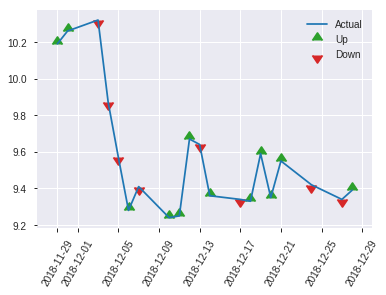


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2082547859087486
RMSE: 0.4563494120832727
LogLoss: 0.6516362346545916
Mean Per-Class Error: 0.2840995681991364
AUC: 0.7602870205740411
pr_auc: 0.7323237700228501
Gini: 0.5205740411480821
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3253209428805728: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   60   0.4839   (60.0/124.0)
1      14   113  0.1102   (14.0/127.0)
Total  78   173  0.2948   (74.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.325321     0.753333  172
max f2                       0.0351452    0.85266   224
max f0point5                 0.706974     0.715631  100
max accuracy                 0.456232     0.717131  151
max precision                0.992467     1         0
max recall                   0.00287331   1         245
max specificity              0.992467     1         0
max absolute_mcc             0.456232     0.44173   151
max min_per_class_accuracy   0.587673     0.669355  126
max mean_per_class_accuracy  0.456232     0.7159    151

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 53.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.984866           1.97638   1.97638            1                0.990019   1                           0.990019            0.023622        0.023622                   97.6378   97.6378
    2        0.0239044                   0.982267           1.31759   1.64698            0.666667         0.983076   0.833333                    0.986547            0.015748        0.0393701                  31.7585   64.6982
    3        0.0318725                   0.97306            1.97638   1.72933            1                0.976222   0.875                       0.983966            0.015748        0.0551181                  97.6378   72.9331
    4        0.0438247                   0.968678           1.97638   1.79671            1                0.970255   0.909091                    0.980227            0.023622        0.0787402                  97.6378   79.6707
    5        0.0517928                   0.967224           0.988189  1.67232            0.5              0.967888   0.846154                    0.978328            0.00787402      0.0866142                  -1.1811   67.232
    6        0.103586                    0.924632           1.67232   1.67232            0.846154         0.946869   0.846154                    0.962599            0.0866142       0.173228                   67.232    67.232
    7        0.151394                    0.89675            1.31759   1.5603             0.666667         0.906071   0.789474                    0.944748            0.0629921       0.23622                    31.7585   56.0298
    8        0.203187                    0.848142           1.67232   1.58885            0.846154         0.876128   0.803922                    0.927256            0.0866142       0.322835                   67.232    58.8853
    9        0.302789                    0.77596            1.26488   1.48228            0.64             0.816152   0.75                        0.890709            0.125984        0.448819                   26.4882   48.2283
    10       0.40239                     0.706974           1.50205   1.48718            0.76             0.739269   0.752475                    0.853224            0.149606        0.598425                   50.2047   48.7175
    11       0.501992                    0.591375           0.711496  1.33327            0.36             0.658989   0.674603                    0.814685            0.0708661       0.669291                   -28.8504  33.3271
    12       0.601594                    0.460062           1.42299   1.34813            0.72             0.533592   0.682119                    0.768147            0.141732        0.811024                   42.2992   34.8125
    13       0.701195                    0.311843           0.790551  1.26892            0.4              0.38966    0.642045                    0.714384            0.0787402       0.889764                   -20.9449  26.8924
    14       0.800797                    0.162384           0.395276  1.16026            0.2              0.220681   0.587065                    0.652978            0.0393701       0.929134                   -60.4724  16.0262
    15       0.900398                    0.0343329          0.553386  1.09313            0.28             0.0808435  0.553097                    0.589689            0.0551181       0.984252                   -44.6614  9.31294
    16       1                           0.000262879        0.15811   1                  0.08             0.0114338  0.505976                    0

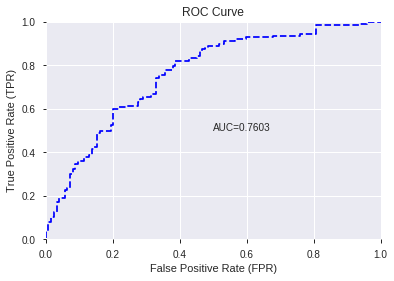

This function is available for GLM models only


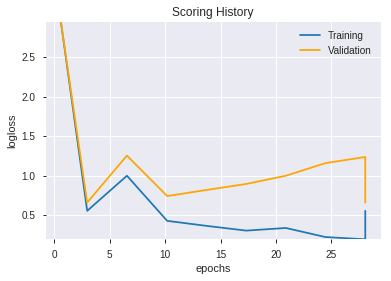

--2019-08-26 20:26:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.80.48
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.80.48|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_201814_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_201814_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_8650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLHIGHWAVE',
 'CDLTAKURI',
 'CORREL_20',
 'COS',
 'CDLDARKCLOUDCOVER',
 'CDLSHORTLINE',
 'BETA_8',
 'dayofweek',
 'DIV',
 'SAREXT',
 'CDLMARUBOZU',
 'BETA_12',
 'is_month_end',
 'CDLDRAGONFLYDOJI',
 'STOCHF_fastd',
 'CDLHANGINGMAN',
 'CDLLONGLINE',
 'STOCH_slowk',
 'is_month_start',
 'STOCHRSI_fastk',
 'days_in_month',
 'CDLHAMMER',
 'WILLR_14',
 'STOCHF_fastk',
 'TRANGE',
 'CMO_8',
 'TANH',
 'dayofyear',
 'CORREL_14',
 'aroonup_8',
 'CDLENGULFING',
 'SUB',
 'WILLR_8',
 'CDLCLOSINGMARUBOZU',
 'CDL3INSIDE',
 'STOCH_slowd',
 'CDLBELTHOLD',
 'WILLR_12',
 'month',
 'PLUS_DM_8',
 'ULTOSC',
 'CORREL_12',
 'HT_TRENDMODE',
 'aroonup_12',
 'weekday_name',
 'CORREL_8',
 'ADOSC',
 'quarter',
 'CORREL_24']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190826_202612_model_1  0.771908  0.565356              0.297244  0.43866  0.192422

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.666022           1.000000    0.159734
1                  DIV             0.249078           0.373979    0.059737
2   CDLCLOSINGMARUBOZU             0.214362           0.321855    0.051411
3               ULTOSC             0.201589           0.302676    0.048348
4         STOCHF_fastk             0.166385           0.249820    0.039905
5         STOCHF_fastd             0.154982           0.232699    0.037170
6          STOCH_slowk             0.154543           0.232039    0.037065
7            CDLHAMMER             0.132769           0.199347    0.031843
8           aroonup_12             0.130543           0.196005    0.031309
9               TRANGE             0.121341           0.182188    0.029102
10            WILLR_12             0.102862           0.154443    0.024670
11   CDLDARKCLOUDCOVER             0.102683           0.154174    0.024627
12           CORREL_12             0.092136           0.138337    0.022097
13             WILLR_8             0.089853           0.134910    0.021550
14      STOCHRSI_fastk             0.083468           0.125323    0.020018
15           CORREL_24             0.082691           0.124156    0.019832
16             BETA_12             0.080838           0.121375    0.019388
17          CDL3INSIDE             0.077428           0.116254    0.018570
18    CDLDRAGONFLYDOJI             0.074122           0.111291    0.017777
19           CORREL_20             0.073972           0.111066    0.017741
20           CDLTAKURI             0.073842           0.110870    0.017710
21              SAREXT             0.072740           0.109216    0.017446
22               CMO_8             0.068320           0.102579    0.016385
23        HT_TRENDMODE             0.065382           0.098168    0.015681
24                TANH             0.059073           0.088695    0.014168
25               ADOSC             0.052668           0.079079    0.012632
26         CDLMARUBOZU             0.052590           0.078961    0.012613
27                 COS             0.051006           0.076584    0.012233
28        weekday_name             0.050438           0.075731    0.012097
29         CDLHIGHWAVE             0.048695           0.073113    0.011679
30           CORREL_14             0.045828           0.068808    0.010991
31       CDLHANGINGMAN             0.044354           0.066595    0.010638
32         CDLBELTHOLD             0.043829           0.065808    0.010512
33            WILLR_14             0.042417           0.063687    0.010173
34           aroonup_8             0.041797           0.062756    0.010024
35        is_month_end             0.038636           0.058011    0.009266
36           dayofyear             0.038481           0.057777    0.009229
37              BETA_8             0.033714           0.050620    0.008086
38             quarter             0.029715           0.044615    0.007127
39            CORREL_8             0.026910           0.040405    0.006454
40                 SUB             0.026030           0.039083    0.006243
41       days_in_month             0.020929           0.031423    0.005019
42        CDLSHORTLINE             0.019431           0.029175    0.004660
43         STOCH_slowd             0.017534           0.026326    0.004205
44           PLUS_DM_8             0.014212           0.021339    0.003409
45         CDLLONGLINE             0.013342           0.020033    0.003200
46           dayofweek             0.007305           0.010968    0.001752
47               month             0.006963           0.010455    0.001670
48        CDLENGULFING             0.006605           0.009917    0.001584
49      is_month_start             0.005101           0.007659    0.001223

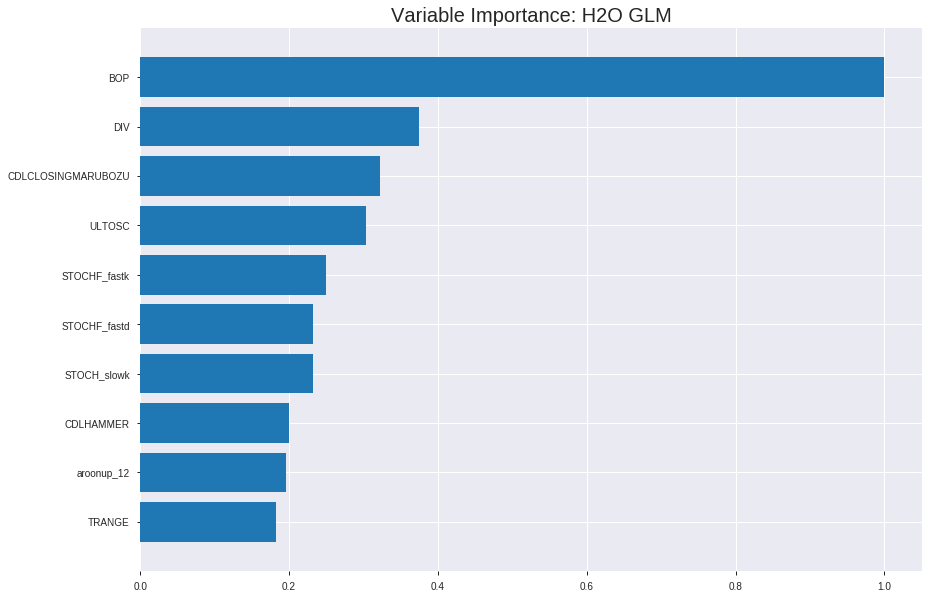

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_202612_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18916336299171901
RMSE: 0.4349291470937755
LogLoss: 0.558535210210408
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2429.6257833865593
Residual deviance: 1958.2244469976908
AIC: 2060.224446997691
AUC: 0.784727973000422
pr_auc: 0.7736934991767523
Gini: 0.5694559460008439
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37250967270997176: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      444  417   0.4843   (417.0/861.0)
1      116  776   0.13     (116.0/892.0)
Total  560  1193  0.3041   (533.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37251      0.744365  260
max f2                       0.139797     0.851717  361
max f0point5                 0.629711     0.724206  142
max accuracy                 0.482238     0.715345  208
max precision                0.943862     1         0
max recall                   0.0776531    1         383
max specificity              0.943862     1         0
max absolute_mcc             0.482238     0.430858  208
max min_per_class_accuracy   0.523501     0.708479  190
max mean_per_class_accuracy  0.482238     0.714641  208

Gains/Lift Table: Avg response rate: 50.88 %, avg score: 50.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.914498           1.74689   1.74689            0.888889         0.926883  0.888889                    0.926883            0.0179372       0.0179372                  74.6886   74.6886
    2        0.0205362                   0.897593           1.74689   1.74689            0.888889         0.907642  0.888889                    0.917262            0.0179372       0.0358744                  74.6886   74.6886
    3        0.0302339                   0.881898           1.84964   1.77985            0.941176         0.889063  0.90566                     0.908217            0.0179372       0.0538117                  84.9644   77.9846
    4        0.040502                    0.872082           1.63771   1.74381            0.833333         0.877133  0.887324                    0.900337            0.0168161       0.0706278                  63.7706   74.381
    5        0.0501997                   0.857732           1.50284   1.69726            0.764706         0.864917  0.863636                    0.893494            0.014574        0.0852018                  50.2836   69.7258
    6        0.100399                    0.803534           1.78659   1.74192            0.909091         0.832472  0.886364                    0.862983            0.0896861       0.174888                   78.6588   74.1923
    7        0.150029                    0.770613           1.55864   1.68129            0.793103         0.786643  0.855513                    0.83773             0.0773543       0.252242                   55.8644   68.1295
    8        0.200228                    0.740182           1.47393   1.62931            0.75             0.756414  0.82906                     0.817343            0.073991        0.326233                   47.3935   62.9307
    9        0.300057                    0.677096           1.48236   1.58042            0.754286         0.707686  0.804183                    0.78086             0.147982        0.474215                   48.2357   58.0417
    10       0.399886                    0.612263           1.21284   1.48865            0.617143         0.645937  0.757489                    0.747177            0.121076        0.595291                   21.2838   48.8653
    11       0.500285                    0.52697            1.08312   1.40727            0.551136         0.570842  0.716078                    0.71179             0.108744        0.704036                   8.31189   40.7269
    12       0.600114                    0.434972           0.954548  1.33196            0.485714         0.47654   0.677757                    0.672656            0.0952915       0.799327                   -4.54516  33.1959
    13       0.699943                    0.353678           0.819789  1.25891            0.417143         0.394506  0.640587                    0.632985            0.0818386       0.881166                   -18.0211  25.8911
    14       0.799772                    0.274059           0.606419  1.17747            0.308571         0.314533  0.599144                    0.593235            0.0605381       0.941704                   -39.3581  17.7466
    15       0.899601                    0.177223           0.381819  1.08917            0.194286         0.226659  0.554217                    0.552556            0.0381166       0.979821                   -61.8181  8.91728
    16       1                           0.0236293          0.200991  1                  0.102273         0.117153  0.508842                    0.508842          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1971212296694615
RMSE: 0.44398336643331754
LogLoss: 0.5798541753278866
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 693.5229098211739
Residual deviance: 581.0138836785424
AIC: 683.0138836785424
AUC: 0.7636047888856877
pr_auc: 0.7471093451736409
Gini: 0.5272095777713754
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3882229957102724: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      100  134  0.5726   (134.0/234.0)
1      24   243  0.0899   (24.0/267.0)
Total  124  377  0.3154   (158.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.388223     0.754658  291
max f2                       0.295737     0.868984  333
max f0point5                 0.644347     0.729073  160
max accuracy                 0.530963     0.702595  224
max precision                0.81435      0.892308  47
max recall                   0.0781581    1         392
max specificity              0.948726     0.995726  0
max absolute_mcc             0.446194     0.404255  266
max min_per_class_accuracy   0.593104     0.689139  193
max mean_per_class_accuracy  0.603211     0.700327  187

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 55.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.909187           0.938202  0.938202           0.5              0.925412  0.5                         0.925412            0.011236        0.011236                   -6.17978  -6.17978
    2        0.0219561                   0.900631           1.50112   1.19408            0.8              0.903745  0.636364                    0.915563            0.0149813       0.0262172                  50.1124   19.4076
    3        0.0319361                   0.895094           1.8764    1.4073             1                0.896156  0.75                        0.909498            0.0187266       0.0449438                  87.6404   40.7303
    4        0.0419162                   0.87818            1.50112   1.42964            0.8              0.887014  0.761905                    0.904145            0.0149813       0.0599251                  50.1124   42.9642
    5        0.0518962                   0.874122           1.8764    1.51556            1                0.874832  0.807692                    0.898508            0.0187266       0.0786517                  87.6404   51.5557
    6        0.101796                    0.827104           1.80135   1.65565            0.96             0.854184  0.882353                    0.876781            0.0898876       0.168539                   80.1348   65.5651
    7        0.151697                    0.801252           1.57618   1.62951            0.84             0.814889  0.868421                    0.856421            0.0786517       0.247191                   57.618    62.9509
    8        0.201597                    0.754824           1.27596   1.542              0.68             0.776792  0.821782                    0.836711            0.0636704       0.310861                   27.5955   54.1996
    9        0.301397                    0.707872           1.35101   1.47876            0.72             0.730539  0.788079                    0.801555            0.134831        0.445693                   35.1011   47.8756
    10       0.401198                    0.657634           1.27596   1.42831            0.68             0.682242  0.761194                    0.771875            0.127341        0.573034                   27.5955   42.8308
    11       0.500998                    0.594314           1.08831   1.36058            0.58             0.623712  0.7251                      0.74236             0.108614        0.681648                   8.83146   36.058
    12       0.600798                    0.516769           0.97573   1.29665            0.52             0.556892  0.69103                     0.711552            0.0973783       0.779026                   -2.42697  29.6652
    13       0.700599                    0.439379           0.900674  1.24024            0.48             0.4772    0.660969                    0.678168            0.0898876       0.868914                   -9.93258  24.0245
    14       0.800399                    0.363033           0.675506  1.16983            0.36             0.390827  0.623441                    0.64234             0.0674157       0.93633                    -32.4494  16.9828
    15       0.9002                      0.24692            0.375281  1.08174            0.2              0.302645  0.576497                    0.60468             0.0374532       0.973783                   -62.4719  8.1741
    16       1                           0.00237925         0.262697  1                  0.14             0.145561  0.532934                    0.55886           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-26 20:26:12  0.000 sec   2            .22E2     51            1.365694472349188   1.3636401525871793
     2019-08-26 20:26:12  0.019 sec   4            .14E2     51            1.3552790244698083  1.353142228621671
     2019-08-26 20:26:12  0.035 sec   6            .84E1     51            1.3407848498276502  1.3386926084486503
     2019-08-26 20:26:13  0.048 sec   8            .52E1     51            1.3217685306972298  1.320007271290538
     2019-08-26 20:26:13  0.068 sec   10           .32E1     51            1.2983962440296128  1.2975508827775752
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-26 20:26:13  0.238 sec   34           .11E-1    51            1.1147587698958468  1.1600925140765435
     2019-08-26 20:26:13  0.250 sec   36           .66E-2    51            1.1133160801078466  1.1608775613798135
     2019-08-26 20:26:13  0.262 sec   38           .41E-2    51            1.1124495422891563  1.1617601427947268
     2019-08-26 20:26:13  0.269 sec   39           .25E-2    51            1.1119436683496584  1.1625802964599758
     2019-08-26 20:26:13  0.277 sec   40           .16E-2    51            1.1116635061920384  1.1632772468306103


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7131474103585658)

('F1', 0.756578947368421)

('auc', 0.7719075438150875)

('logloss', 0.5653559083590596)

('mean_per_class_error', 0.28784607569215137)

('rmse', 0.4386598373936053)

('mse', 0.19242245294218424)

glm prediction progress: |████████████████████████████████████████████████| 100%


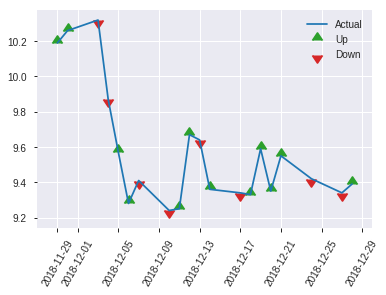


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19242245294218424
RMSE: 0.4386598373936053
LogLoss: 0.5653559083590596
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 347.9322754570597
Residual deviance: 283.8086659962479
AIC: 385.8086659962479
AUC: 0.7719075438150875
pr_auc: 0.7510102777195852
Gini: 0.543815087630175
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3504552198998467: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   62   0.5      (62.0/124.0)
1      12   115  0.0945   (12.0/127.0)
Total  74   177  0.2948   (74.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.350455     0.756579  176
max f2                       0.195495     0.859697  218
max f0point5                 0.613799     0.712909  97
max accuracy                 0.484766     0.713147  146
max precision                0.91126      1         0
max recall                   0.129986     1         239
max specificity              0.91126      1         0
max absolute_mcc             0.350455     0.444645  176
max min_per_class_accuracy   0.547792     0.692913  125
max mean_per_class_accuracy  0.484766     0.712154  146

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 51.01 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.89848            1.97638    1.97638            1                0.905977  1                           0.905977            0.023622        0.023622                   97.6378   97.6378
    2        0.0239044                   0.88975            1.97638    1.97638            1                0.893407  1                           0.899692            0.023622        0.0472441                  97.6378   97.6378
    3        0.0318725                   0.871035           1.97638    1.97638            1                0.877641  1                           0.894179            0.015748        0.0629921                  97.6378   97.6378
    4        0.0438247                   0.855541           1.31759    1.79671            0.666667         0.864276  0.909091                    0.886024            0.015748        0.0787402                  31.7585   79.6707
    5        0.0517928                   0.846658           1.97638    1.82435            1                0.854577  0.923077                    0.881186            0.015748        0.0944882                  97.6378   82.4349
    6        0.103586                    0.794625           1.52029    1.67232            0.769231         0.819756  0.846154                    0.850471            0.0787402       0.173228                   52.0291   67.232
    7        0.151394                    0.754366           1.48228    1.61231            0.75             0.774187  0.815789                    0.826381            0.0708661       0.244094                   48.2283   61.2308
    8        0.203187                    0.73227            1.36826    1.5501             0.692308         0.742172  0.784314                    0.804916            0.0708661       0.314961                   36.8262   55.01
    9        0.302789                    0.676047           1.50205    1.53429            0.76             0.702775  0.776316                    0.771317            0.149606        0.464567                   50.2047   53.4293
    10       0.40239                     0.604924           1.18583    1.44804            0.6              0.642538  0.732673                    0.739441            0.11811         0.582677                   18.5827   44.8039
    11       0.501992                    0.547792           1.10677    1.38033            0.56             0.575503  0.698413                    0.706914            0.110236        0.692913                   10.6772   38.0327
    12       0.601594                    0.460987           1.10677    1.33504            0.56             0.513366  0.675497                    0.674869            0.110236        0.80315                    10.6772   33.5037
    13       0.701195                    0.35478            0.948661   1.28015            0.48             0.40875   0.647727                    0.637068            0.0944882       0.897638                   -5.13386  28.0154
    14       0.800797                    0.259817           0.474331   1.17993            0.24             0.304793  0.597015                    0.59574             0.0472441       0.944882                   -52.5669  17.9927
    15       0.900398                    0.167251           0.474331   1.10187            0.24             0.20791   0.557522                    0.552839            0.0472441       0.992126                   -52.5669  10.1874
    16       1                           0.031576           0.0790551  1                  0.04             0.124085  0.505976                    0.

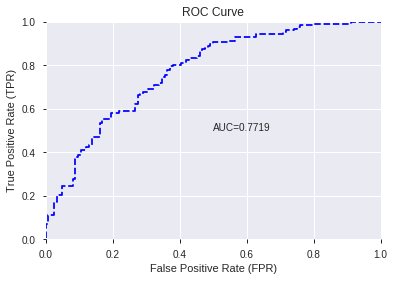

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


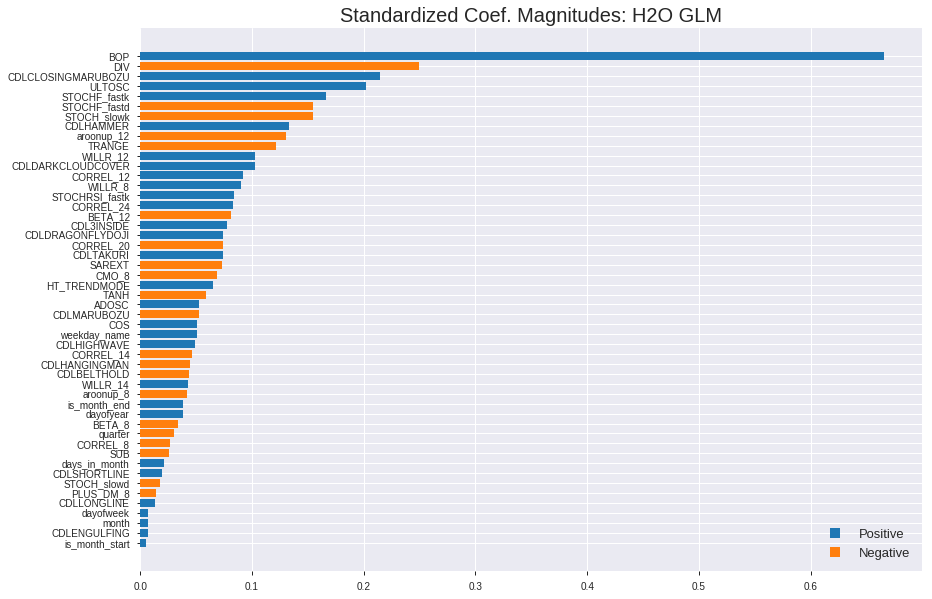

'log_likelihood'
--2019-08-26 20:26:19--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.112.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.112.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_202612_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_202612_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_8650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'DIV',
 'CDLCLOSINGMARUBOZU',
 'ULTOSC',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCH_slowk',
 'CDLHAMMER',
 'aroonup_12',
 'TRANGE',
 'WILLR_12',
 'CDLDARKCLOUDCOVER',
 'CORREL_12',
 'WILLR_8',
 'STOCHRSI_fastk',
 'CORREL_24',
 'BETA_12',
 'CDL3INSIDE',
 'CDLDRAGONFLYDOJI',
 'CORREL_20',
 'CDLTAKURI',
 'SAREXT',
 'CMO_8',
 'HT_TRENDMODE',
 'TANH',
 'ADOSC',
 'CDLMARUBOZU',
 'COS',
 'weekday_name',
 'CDLHIGHWAVE',
 'CORREL_14',
 'CDLHANGINGMAN',
 'CDLBELTHOLD',
 'WILLR_14',
 'aroonup_8',
 'is_month_end',
 'dayofyear',
 'BETA_8',
 'quarter',
 'CORREL_8',
 'SUB',
 'days_in_month',
 'CDLSHORTLINE',
 'STOCH_slowd',
 'PLUS_DM_8',
 'CDLLONGLINE',
 'dayofweek',
 'month',
 'CDLENGULFING',
 'is_month_start']

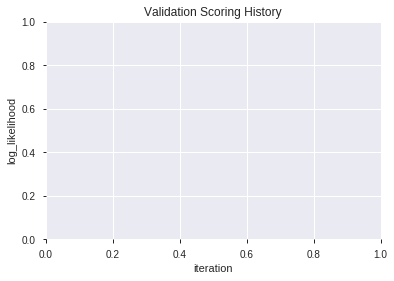

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_202630_model_1  0.767336  0.575776              0.292640  0.442349  0.195673
1  XGBoost_grid_1_AutoML_20190826_202630_model_3  0.766955  0.571534              0.305594  0.440595  0.194124
2  XGBoost_grid_1_AutoML_20190826_202630_model_6  0.765113  0.576878              0.321628  0.443358  0.196566
3               XGBoost_3_AutoML_20190826_202630  0.763970  0.573724              0.301562  0.442083  0.195438
4               XGBoost_1_AutoML_20190826_202630  0.763208  0.578154              0.296577  0.444027  0.197160
5               XGBoost_2_AutoML_20190826_202630  0.761303  0.581045              0.309531  0.445348  0.198335
6  XGBoost_grid_1_AutoML_20190826_202630_model_4  0.757811  0.581453              0.296958  0.445383  0.198366
7  XGBoost_grid_1_AutoML_20190826_202630_model_5  0.752985  0.589031              0.313468  0.449701  0.202231
8  XGBoost_grid_1_AutoML_20190826_202630_model_7  0.749428  0.588526              0.317405  0.449332  0.201899
9  XGBoost_grid_1_AutoML_20190826_202630_model_2  0.744539  0.590647              0.317310  0.449688  0.202219

variable  relative_importance  scaled_importance  percentage
0                  BOP          3562.292236           1.000000    0.395317
1                  DIV           907.550171           0.254766    0.100713
2         STOCHF_fastk           406.895752           0.114223    0.045154
3             CORREL_8           295.959381           0.083081    0.032843
4            dayofyear           291.018738           0.081694    0.032295
5              BETA_12           240.251343           0.067443    0.026661
6               BETA_8           237.850311           0.066769    0.026395
7                  SUB           202.711685           0.056905    0.022495
8            CORREL_24           197.772110           0.055518    0.021947
9          STOCH_slowk           186.063843           0.052231    0.020648
10         STOCH_slowd           173.006821           0.048566    0.019199
11            WILLR_12           159.878784           0.044881    0.017742
12              TRANGE           154.900818           0.043483    0.017190
13                 COS           145.593140           0.040871    0.016157
14                TANH           141.848038           0.039819    0.015741
15               ADOSC           138.125885           0.038774    0.015328
16              SAREXT           130.751312           0.036704    0.014510
17            WILLR_14           124.598343           0.034977    0.013827
18              ULTOSC           113.817101           0.031951    0.012631
19               CMO_8           105.971672           0.029748    0.011760
20           CORREL_20           104.684074           0.029387    0.011617
21  CDLCLOSINGMARUBOZU           103.048279           0.028928    0.011436
22           PLUS_DM_8            92.956856           0.026095    0.010316
23           CORREL_14            91.797188           0.025769    0.010187
24          aroonup_12            78.816261           0.022125    0.008746
25             WILLR_8            76.009964           0.021337    0.008435
26           aroonup_8            68.657158           0.019273    0.007619
27           dayofweek            54.279236           0.015237    0.006024
28           CORREL_12            53.035721           0.014888    0.005886
29         CDLHIGHWAVE            51.963608           0.014587    0.005767
30    CDLDRAGONFLYDOJI            46.888962           0.013163    0.005203
31      STOCHRSI_fastk            39.148567           0.010990    0.004344
32           CDLHAMMER            38.864426           0.010910    0.004313
33         CDLBELTHOLD            33.908104           0.009519    0.003763
34        STOCHF_fastd            33.294659           0.009346    0.003695
35        CDLSHORTLINE            31.788244           0.008924    0.003528
36        weekday_name            27.010483           0.007582    0.002997
37               month            18.928823           0.005314    0.002101
38       days_in_month            17.932400           0.005034    0.001990
39         CDLLONGLINE            15.381050           0.004318    0.001707
40           CDLTAKURI            12.117704           0.003402    0.001345
41        HT_TRENDMODE             3.863734           0.001085    0.000429

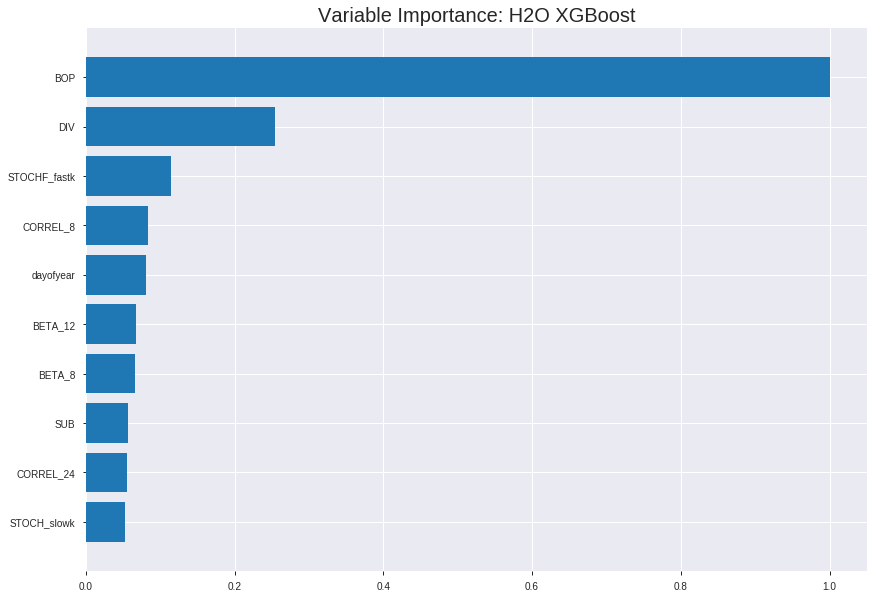

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_202630_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13917044298384626
RMSE: 0.3730555494612649
LogLoss: 0.44279653188220186
Mean Per-Class Error: 0.17625375645172214
AUC: 0.9076850361713098
pr_auc: 0.9129116368161199
Gini: 0.8153700723426196
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.500695638358593: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      671  190  0.2207   (190.0/861.0)
1      125  767  0.1401   (125.0/892.0)
Total  796  957  0.1797   (315.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.500696     0.829638  203
max f2                       0.326629     0.898123  282
max f0point5                 0.583218     0.844595  166
max accuracy                 0.535567     0.823731  187
max precision                0.937956     1         0
max recall                   0.199055     1         336
max specificity              0.937956     1         0
max absolute_mcc             0.535567     0.647422  187
max min_per_class_accuracy   0.535567     0.82287   187
max mean_per_class_accuracy  0.535567     0.823746  187

Gains/Lift Table: Avg response rate: 50.88 %, avg score: 50.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.896029           1.96525   1.96525            1                0.911218   1                           0.911218            0.0201794       0.0201794                  96.5247   96.5247
    2        0.0205362                   0.872776           1.96525   1.96525            1                0.885899   1                           0.898558            0.0201794       0.0403587                  96.5247   96.5247
    3        0.0302339                   0.8647             1.96525   1.96525            1                0.868214   1                           0.888825            0.0190583       0.059417                   96.5247   96.5247
    4        0.040502                    0.852711           1.96525   1.96525            1                0.859247   1                           0.881327            0.0201794       0.0795964                  96.5247   96.5247
    5        0.0501997                   0.84666            1.96525   1.96525            1                0.849856   1                           0.875247            0.0190583       0.0986547                  96.5247   96.5247
    6        0.100399                    0.808093           1.96525   1.96525            1                0.826469   1                           0.850858            0.0986547       0.197309                   96.5247   96.5247
    7        0.150029                    0.773034           1.94266   1.95777            0.988506         0.791503   0.996198                    0.831224            0.0964126       0.293722                   94.2658   95.7774
    8        0.200228                    0.741794           1.78659   1.91486            0.909091         0.756486   0.974359                    0.812486            0.0896861       0.383408                   78.6588   91.4856
    9        0.300057                    0.68525            1.67327   1.83448            0.851429         0.713905   0.93346                     0.779688            0.16704         0.550448                   67.3267   83.4479
    10       0.399886                    0.61484            1.43744   1.73536            0.731429         0.650794   0.883024                    0.747511            0.143498        0.693946                   43.7438   73.536
    11       0.500285                    0.539166           1.23945   1.63584            0.630682         0.576047   0.832383                    0.713101            0.124439        0.818386                   23.9445   63.5838
    12       0.600114                    0.459323           0.729949  1.48514            0.371429         0.497911   0.755703                    0.677304            0.07287         0.891256                   -27.0051  48.5144
    13       0.699943                    0.358729           0.628879  1.36302            0.32             0.40889    0.693562                    0.639021            0.0627803       0.954036                   -37.1121  36.3019
    14       0.799772                    0.25897            0.348129  1.23634            0.177143         0.305744   0.629101                    0.597421            0.0347534       0.988789                   -65.1871  23.6339
    15       0.899601                    0.150948           0.1123    1.1116             0.0571429        0.207074   0.565631                    0.554104            0.0112108       1                          -88.77    11.1604
    16       1                           0.0484582          0         1                  0                0.0988749  0.508842                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20887278765067674
RMSE: 0.45702602513497714
LogLoss: 0.6033695745495683
Mean Per-Class Error: 0.32677902621722854
AUC: 0.7252712954960145
pr_auc: 0.7345792085704973
Gini: 0.4505425909920291
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4382520914077759: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      110  124  0.5299   (124.0/234.0)
1      35   232  0.1311   (35.0/267.0)
Total  145  356  0.3174   (159.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.438252     0.744783  271
max f2                       0.135858     0.861957  374
max f0point5                 0.549699     0.690627  220
max accuracy                 0.455216     0.684631  260
max precision                0.905762     1         0
max recall                   0.113413     1         381
max specificity              0.905762     1         0
max absolute_mcc             0.438252     0.372952  271
max min_per_class_accuracy   0.574666     0.649573  198
max mean_per_class_accuracy  0.455216     0.673221  260

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 54.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.8744             1.8764    1.8764             1                0.890791  1                           0.890791            0.0224719       0.0224719                  87.6404   87.6404
    2        0.0219561                   0.864368           1.50112   1.70582            0.8              0.870379  0.909091                    0.881513            0.0149813       0.0374532                  50.1124   70.5822
    3        0.0319361                   0.855651           1.50112   1.64185            0.8              0.859019  0.875                       0.874483            0.0149813       0.0524345                  50.1124   64.1854
    4        0.0419162                   0.847804           1.8764    1.6977             1                0.850647  0.904762                    0.868808            0.0187266       0.071161                   87.6404   69.7699
    5        0.0518962                   0.833034           1.50112   1.6599             0.8              0.840719  0.884615                    0.863406            0.0149813       0.0861423                  50.1124   65.9896
    6        0.101796                    0.790165           1.50112   1.58207            0.8              0.808337  0.843137                    0.836412            0.0749064       0.161049                   50.1124   58.2067
    7        0.151697                    0.761598           1.57618   1.58013            0.84             0.777331  0.842105                    0.816977            0.0786517       0.2397                     57.618    58.013
    8        0.201597                    0.731161           1.42607   1.542              0.76             0.744736  0.821782                    0.799096            0.071161        0.310861                   42.6067   54.1996
    9        0.301397                    0.680072           1.05079   1.37934            0.56             0.705144  0.735099                    0.767986            0.104869        0.41573                    5.07865   37.9344
    10       0.401198                    0.633955           1.01326   1.28828            0.54             0.660648  0.686567                    0.741285            0.101124        0.516854                   1.32584   28.8278
    11       0.500998                    0.577382           1.23843   1.27835            0.66             0.606133  0.681275                    0.714362            0.123596        0.640449                   23.8427   27.8347
    12       0.600798                    0.527976           1.16337   1.25925            0.62             0.558569  0.671096                    0.688483            0.116105        0.756554                   16.3371   25.9248
    13       0.700599                    0.442971           0.97573   1.21886            0.52             0.486259  0.649573                    0.659676            0.0973783       0.853933                   -2.42697  21.8861
    14       0.800399                    0.333213           0.675506  1.15111            0.36             0.386575  0.613466                    0.625624            0.0674157       0.921348                   -32.4494  15.1111
    15       0.9002                      0.210985           0.487865  1.07758            0.26             0.272223  0.574279                    0.586444            0.0486891       0.970037                   -51.2135  7.75804
    16       1                           0.0461821          0.300225  1                  0.16             0.133128  0.532934                    0.541203          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 20:26:35  0.013 sec   0                  0.5              0.693147            0.5             0                  1                0.491158                         0.5                0.693147              0.5               0                    1                  0.467066
    2019-08-26 20:26:35  0.137 sec   5                  0.468791         0.632209            0.841311        0.836386           1.96525          0.253851                         0.483179           0.659839              0.700503          0.681074             1.25094            0.331337
    2019-08-26 20:26:35  0.212 sec   10                 0.446431         0.589346            0.852825        0.848934           1.96525          0.24073                          0.472659           0.638868              0.712355          0.70926              1.56367            0.353293
    2019-08-26 20:26:35  0.285 sec   15                 0.430011         0.557626            0.860662        0.85949            1.96525          0.223617                         0.465975           0.625184              0.71618           0.707341             1.56367            0.331337
    2019-08-26 20:26:35  0.356 sec   20                 0.418147         0.534079            0.865867        0.865269           1.96525          0.220194                         0.461341           0.615351              0.723703          0.71532              1.56367            0.333333
    2019-08-26 20:26:36  0.442 sec   25                 0.408891         0.515131            0.87205         0.871674           1.96525          0.221905                         0.458688           0.609271              0.727128          0.724878             1.56367            0.321357
    2019-08-26 20:26:36  0.518 sec   30                 0.400383         0.49786             0.880428        0.882424           1.96525          0.219053                         0.458221           0.607499              0.724007          0.725302             1.8764             0.321357
    2019-08-26 20:26:36  0.588 sec   35                 0.394544         0.485638            0.88527         0.8883             1.96525          0.196805                         0.457516           0.605384              0.724895          0.72953              1.56367            0.347305
    2019-08-26 20:26:36  0.659 sec   40                 0.389211         0.474798            0.890639        0.895129           1.96525          0.192242                         0.45718            0.604521              0.724967          0.729875             1.8764             0.341317
    2019-08-26 20:26:36  0.725 sec   45                 0.384412         0.465134            0.895561        0.900305           1.96525          0.185967                         0.456929           0.603848              0.725207          0.726991             1.56367            0.311377
    2019-08-26 20:26:36  0.794 sec   50                 0.379678         0.45576             0.900598        0.904718           1.96525          0.179692                         0.456867           0.603313              0.724815          0.727823             1.56367            0.311377
    2019-08-26 20:26:36  0.858 sec   55                 0.376877         0.44995             0.902954        0.907885           1.96525          0.183115                         0.457447           0.604072              0.723471          0

Variable Importances: 


variable       relative_importance    scaled_importance     percentage
-------------  ---------------------  --------------------  ----------------------
BOP            3562.292236328125      1.0                   0.39531684986994603
DIV            907.5501708984375      0.25476578300996033   0.10071320679414775
STOCHF_fastk   406.895751953125       0.11422301286896597   0.045154281630013934
CORREL_8       295.9593811035156      0.08308116276518045   0.03284338354786339
dayofyear      291.01873779296875     0.08169423463498317   0.03229510748843779
---            ---                    ---                   ---
month          18.928823471069336     0.005313663847686018  0.0021005808535350537
days_in_month  17.93239974975586      0.005033949648173697  0.0019900051173199493
CDLLONGLINE    15.381050109863281     0.004317739559098465  0.0017068752010616546
CDLTAKURI      12.117704391479492     0.003401659265318996  0.0013447332250968204
HT_TRENDMODE   3.8637337684631348     0.001084620101927888  0.00042876860199975245


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7131474103585658)

('F1', 0.7491408934707903)

('auc', 0.7673355346710693)

('logloss', 0.5757763265619309)

('mean_per_class_error', 0.2876555753111507)

('rmse', 0.44234921949641043)

('mse', 0.19567283198908347)

xgboost prediction progress: |████████████████████████████████████████████| 100%


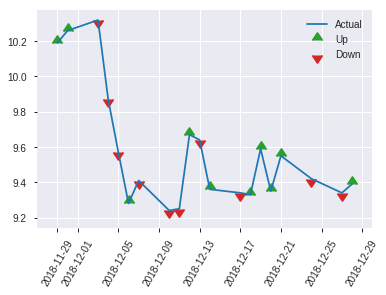


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19567283198908347
RMSE: 0.44234921949641043
LogLoss: 0.5757763265619309
Mean Per-Class Error: 0.2876555753111507
AUC: 0.7673355346710693
pr_auc: 0.7407822868143817
Gini: 0.5346710693421386
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43446245789527893: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      69   55   0.4435   (55.0/124.0)
1      18   109  0.1417   (18.0/127.0)
Total  87   164  0.2908   (73.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.434462     0.749141  163
max f2                       0.19464      0.85282   218
max f0point5                 0.619513     0.712831  90
max accuracy                 0.48462      0.713147  142
max precision                0.90818      1         0
max recall                   0.0560642    1         246
max specificity              0.90818      1         0
max absolute_mcc             0.434462     0.435698  163
max min_per_class_accuracy   0.542318     0.692913  122
max mean_per_class_accuracy  0.48462      0.712344  142

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 49.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.879819           1.97638   1.97638            1                0.892432   1                           0.892432            0.023622        0.023622                   97.6378   97.6378
    2        0.0239044                   0.876983           1.97638   1.97638            1                0.877712   1                           0.885072            0.023622        0.0472441                  97.6378   97.6378
    3        0.0318725                   0.83631            0         1.48228            0                0.855704   0.75                        0.87773             0               0.0472441                  -100      48.2283
    4        0.0438247                   0.826453           1.97638   1.61704            1                0.830463   0.818182                    0.864839            0.023622        0.0708661                  97.6378   61.7037
    5        0.0517928                   0.821225           1.97638   1.67232            1                0.823232   0.846154                    0.858438            0.015748        0.0866142                  97.6378   67.232
    6        0.103586                    0.776973           1.67232   1.67232            0.846154         0.79971    0.846154                    0.829074            0.0866142       0.173228                   67.232    67.232
    7        0.151394                    0.751646           1.48228   1.61231            0.75             0.762307   0.815789                    0.80799             0.0708661       0.244094                   48.2283   61.2308
    8        0.203187                    0.718004           1.21623   1.51135            0.615385         0.732579   0.764706                    0.788767            0.0629921       0.307087                   21.6233   51.1348
    9        0.302789                    0.649236           1.5811    1.53429            0.8              0.676984   0.776316                    0.751997            0.15748         0.464567                   58.1102   53.4293
    10       0.40239                     0.590383           1.10677   1.42847            0.56             0.622849   0.722772                    0.720029            0.110236        0.574803                   10.6772   42.8471
    11       0.501992                    0.534403           1.18583   1.38033            0.6              0.559582   0.698413                    0.688195            0.11811         0.692913                   18.5827   38.0327
    12       0.601594                    0.471613           1.10677   1.33504            0.56             0.499872   0.675497                    0.657015            0.110236        0.80315                    10.6772   33.5037
    13       0.701195                    0.382025           0.790551  1.2577             0.4              0.433271   0.636364                    0.625234            0.0787402       0.88189                    -20.9449  25.7695
    14       0.800797                    0.252466           0.553386  1.17009            0.28             0.290241   0.59204                     0.583568            0.0551181       0.937008                   -44.6614  17.0094
    15       0.900398                    0.148695           0.395276  1.08438            0.2              0.209575   0.548673                    0.542197            0.0393701       0.976378                   -60.4724  8.43844
    16       1                           0.0471704          0.237165  1                  0.12             0.0870363  0.505976                    0

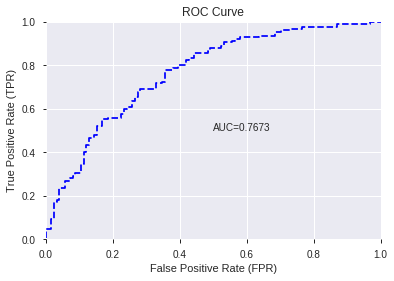

This function is available for GLM models only


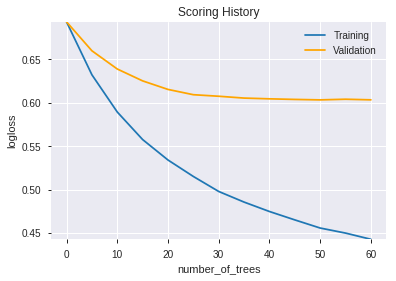

--2019-08-26 20:26:52--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.81.80
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.81.80|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.jav

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_202630_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_202630_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_8650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'STOCHF_fastk',
 'CORREL_8',
 'dayofyear',
 'BETA_12',
 'BETA_8',
 'SUB',
 'CORREL_24',
 'STOCH_slowk',
 'STOCH_slowd',
 'WILLR_12',
 'TRANGE',
 'COS',
 'TANH',
 'ADOSC',
 'SAREXT',
 'WILLR_14',
 'ULTOSC',
 'CMO_8',
 'CORREL_20',
 'CDLCLOSINGMARUBOZU',
 'PLUS_DM_8',
 'CORREL_14',
 'aroonup_12',
 'WILLR_8',
 'aroonup_8',
 'dayofweek',
 'CORREL_12',
 'CDLHIGHWAVE',
 'CDLDRAGONFLYDOJI',
 'STOCHRSI_fastk',
 'CDLHAMMER',
 'CDLBELTHOLD',
 'STOCHF_fastd',
 'CDLSHORTLINE',
 'weekday_name',
 'month',
 'days_in_month',
 'CDLLONGLINE',
 'CDLTAKURI',
 'HT_TRENDMODE']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

62

['BOP',
 'CCI_8',
 'CMO_8',
 'MINUS_DI_8',
 'MINUS_DM_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'MINUS_DI_12',
 'MOM_12',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'MOM_14',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'RSI_14',
 'WILLR_14',
 'CCI_20',
 'CMO_20',
 'ROC_20',
 'ROCP_20',
 'ROCR_20',
 'ROCR100_20',
 'RSI_20',
 'WILLR_20',
 'CCI_24',
 'CMO_24',
 'RSI_24',
 'WILLR_24',
 'CMO_30',
 'RSI_30',
 'WILLR_30',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_202703_model_9  0.778575  0.563173              0.305594  0.437720  0.191599
1  DeepLearning_grid_1_AutoML_20190826_202703_model_8  0.751873  0.634631              0.313659  0.458374  0.210107
2  DeepLearning_grid_1_AutoML_20190826_202703_model_6  0.747841  0.605758              0.296958  0.454210  0.206307
3  DeepLearning_grid_1_AutoML_20190826_202703_model_3  0.742062  0.619751              0.313659  0.460545  0.212101
4  DeepLearning_grid_1_AutoML_20190826_202703_model_7  0.739967  0.650150              0.317501  0.462810  0.214193
5  DeepLearning_grid_1_AutoML_20190826_202703_model_5  0.731521  0.600146              0.317691  0.455403  0.207392
6               DeepLearning_1_AutoML_20190826_202703  0.723012  0.629140              0.309531  0.463239  0.214590
7  DeepLearning_grid_1_AutoML_20190826_202703_model_4  0.722949  0.717711              0.321533  0.488532  0.238663
8  DeepLearning_grid_1_AutoML_20190826_202703_model_2  0.701994  0.707358              0.386621  0.490201  0.240297
9  DeepLearning_grid_1_AutoML_20190826_202703_model_1  0.669672  0.932265              0.357728  0.527004  0.277733

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.044583
1   CDLCLOSINGMARUBOZU             0.837580           0.837580    0.037342
2          CDLLONGLINE             0.691707           0.691707    0.030839
3         CDLSHORTLINE             0.589046           0.589046    0.026262
4          CDLBELTHOLD             0.560244           0.560244    0.024977
..                 ...                  ...                ...         ...
57               RSI_8             0.279763           0.279763    0.012473
58              ROC_14             0.278120           0.278120    0.012399
59              MOM_14             0.277381           0.277381    0.012367
60              RSI_14             0.275381           0.275381    0.012277
61              MOM_12             0.273629           0.273629    0.012199

[62 rows x 4 columns]

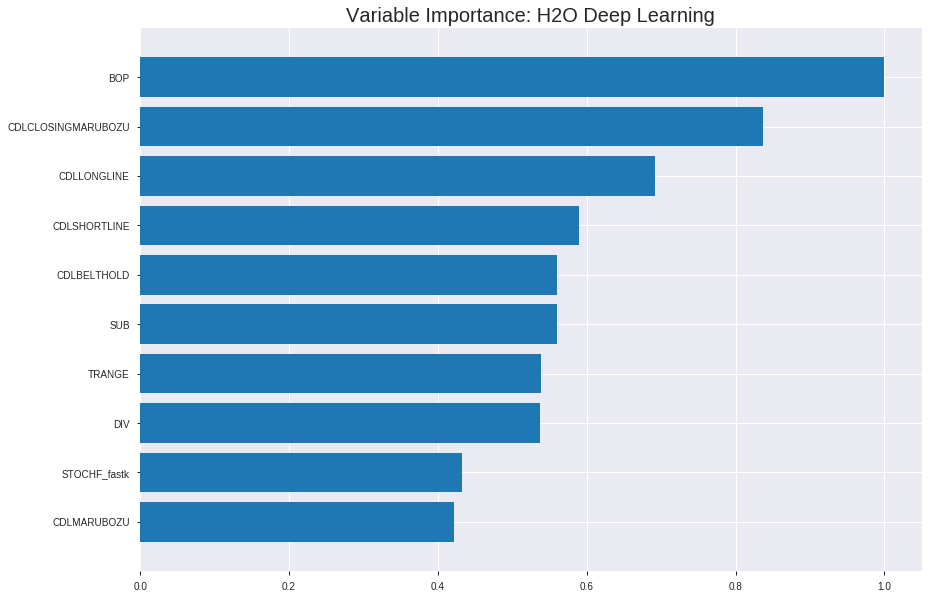

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_202703_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19582047797790947
RMSE: 0.4425160765191582
LogLoss: 0.575395037607584
Mean Per-Class Error: 0.3020408535283303
AUC: 0.7713069587454363
pr_auc: 0.7592047744867025
Gini: 0.5426139174908726
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4603284317881253: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      456  405   0.4704   (405.0/861.0)
1      120  772   0.1345   (120.0/892.0)
Total  576  1177  0.2995   (525.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.460328     0.746254  235
max f2                       0.20843      0.848561  345
max f0point5                 0.691428     0.714717  114
max accuracy                 0.460328     0.700513  235
max precision                0.887148     1         0
max recall                   0.0853286    1         397
max specificity              0.887148     1         0
max absolute_mcc             0.460328     0.420512  235
max min_per_class_accuracy   0.558223     0.691704  179
max mean_per_class_accuracy  0.619083     0.697959  147

Gains/Lift Table: Avg response rate: 50.88 %, avg score: 54.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.870326           1.63771   1.63771            0.833333         0.878056  0.833333                    0.878056            0.0168161       0.0168161                  63.7706    63.7706
    2        0.0205362                   0.857877           1.85607   1.74689            0.944444         0.863856  0.888889                    0.870956            0.0190583       0.0358744                  85.6066    74.6886
    3        0.0302339                   0.849223           1.84964   1.77985            0.941176         0.853825  0.90566                     0.865462            0.0179372       0.0538117                  84.9644    77.9846
    4        0.040502                    0.841146           1.63771   1.74381            0.833333         0.844753  0.887324                    0.860212            0.0168161       0.0706278                  63.7706    74.381
    5        0.0501997                   0.837148           1.73404   1.74192            0.882353         0.839847  0.886364                    0.856278            0.0168161       0.0874439                  73.4041    74.1923
    6        0.100399                    0.816206           1.74192   1.74192            0.886364         0.825175  0.886364                    0.840726            0.0874439       0.174888                   74.1923    74.1923
    7        0.150029                    0.797744           1.46829   1.6514             0.747126         0.807727  0.840304                    0.82981             0.07287         0.247758                   46.8288    65.1405
    8        0.200228                    0.776623           1.47393   1.60691            0.75             0.78656   0.817664                    0.818967            0.073991        0.321749                   47.3935    60.6911
    9        0.300057                    0.720214           1.42621   1.54679            0.725714         0.752033  0.787072                    0.796698            0.142377        0.464126                   42.6208    54.6791
    10       0.399886                    0.638433           1.24653   1.47183            0.634286         0.6837    0.74893                     0.768489            0.124439        0.588565                   24.6528    47.1832
    11       0.500285                    0.559481           0.993789  1.3759             0.505682         0.595088  0.700114                    0.73369             0.0997758       0.688341                   -0.621051  37.5897
    12       0.600114                    0.512439           0.965778  1.30767            0.491429         0.534803  0.665399                    0.700605            0.0964126       0.784753                   -3.42217   30.7674
    13       0.699943                    0.428186           1.0107    1.26532            0.514286         0.476762  0.643847                    0.66868             0.100897        0.88565                    1.06983    26.5318
    14       0.799772                    0.303203           0.516579  1.17186            0.262857         0.366755  0.596291                    0.630993            0.0515695       0.93722                    -48.3421   17.1859
    15       0.899601                    0.207503           0.415509  1.08793            0.211429         0.252339  0.553583                    0.588974            0.0414798       0.9787                     -58.4491   8.79266
    16       1                           0.0560039          0.212157  1                  0.107955         0.162865  0.508842                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19912652320114577
RMSE: 0.4462359501442547
LogLoss: 0.5827634460171865
Mean Per-Class Error: 0.31136560069144337
AUC: 0.7608038029386344
pr_auc: 0.7576981699312487
Gini: 0.5216076058772687
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48183773702443217: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      101  133  0.5684   (133.0/234.0)
1      22   245  0.0824   (22.0/267.0)
Total  123  378  0.3094   (155.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.481838     0.75969   285
max f2                       0.377335     0.868243  315
max f0point5                 0.669526     0.710254  146
max accuracy                 0.524887     0.698603  251
max precision                0.889995     1         0
max recall                   0.134209     1         390
max specificity              0.889995     1         0
max absolute_mcc             0.481838     0.40483   285
max min_per_class_accuracy   0.585166     0.677903  195
max mean_per_class_accuracy  0.55498      0.688634  216

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 57.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.880177           1.8764    1.8764             1                0.884676  1                           0.884676            0.0224719       0.0224719                  87.6404   87.6404
    2        0.0219561                   0.870069           0.750562  1.36466            0.4              0.872683  0.727273                    0.879224            0.00749064      0.0299625                  -24.9438  36.4658
    3        0.0319361                   0.863038           1.8764    1.52458            1                0.866261  0.8125                      0.875173            0.0187266       0.0486891                  87.6404   52.4579
    4        0.0419162                   0.850179           1.8764    1.60835            1                0.857543  0.857143                    0.870976            0.0187266       0.0674157                  87.6404   60.8347
    5        0.0518962                   0.837947           1.8764    1.6599             1                0.843778  0.884615                    0.865745            0.0187266       0.0861423                  87.6404   65.9896
    6        0.101796                    0.813987           1.72629   1.69244            0.92             0.823709  0.901961                    0.845139            0.0861423       0.172285                   72.6292   69.2443
    7        0.151697                    0.792283           1.57618   1.6542             0.84             0.802745  0.881579                    0.831194            0.0786517       0.250936                   57.618    65.4199
    8        0.201597                    0.777253           1.35101   1.57915            0.72             0.782996  0.841584                    0.819264            0.0674157       0.318352                   35.1011   57.9152
    9        0.301397                    0.730188           1.2009    1.4539             0.64             0.756768  0.774834                    0.79857             0.11985         0.438202                   20.0899   45.3903
    10       0.401198                    0.664753           1.27596   1.40964            0.68             0.698237  0.751244                    0.773611            0.127341        0.565543                   27.5955   40.9637
    11       0.500998                    0.596048           0.938202  1.31573            0.5              0.628971  0.701195                    0.744799            0.093633        0.659176                   -6.17978  31.5726
    12       0.600798                    0.546647           1.05079   1.27172            0.56             0.564295  0.677741                    0.714815            0.104869        0.764045                   5.07865   27.1716
    13       0.700599                    0.514266           1.05079   1.24024            0.56             0.53112   0.660969                    0.688647            0.104869        0.868914                   5.07865   24.0245
    14       0.800399                    0.415026           0.750562  1.17919            0.4              0.475272  0.628429                    0.662042            0.0749064       0.94382                    -24.9438  17.9187
    15       0.9002                      0.249406           0.412809  1.09422            0.22             0.322012  0.583149                    0.624345            0.0411985       0.985019                   -58.7191  9.42226
    16       1                           0.0654985          0.150112  1                  0.08             0.179117  0.532934                    0.579911         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 20:34:12  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 20:34:14  2 min 31.763 sec  564 obs/sec       0.583571  1             1023       0.492836         0.706474            0.0281469      0.754747        0.747439           1.96525          0.332573                         0.488478           0.68951               0.041398         0.750136          0.751803             1.25094            0.323353
    2019-08-26 20:34:23  2 min 41.261 sec  898 obs/sec       5.35026   9             9379       0.448504         0.587442            0.195124       0.762621        0.747073           1.85607          0.321734                         0.458294           0.607291              0.156205         0.728769          0.718432             1.25094            0.357285
    2019-08-26 20:34:32  2 min 50.415 sec  1064 obs/sec      11.3548   19            19905      0.444747         0.580871            0.208553       0.771476        0.757026           1.85607          0.3166                           0.450784           0.592568              0.183633         0.753769          0.744434             1.25094            0.323353
    2019-08-26 20:34:42  2 min 59.815 sec  1191 obs/sec      18.5163   31            32459      0.439823         0.57094             0.225981       0.778043        0.756387           1.41934          0.311466                         0.446982           0.584298              0.197348         0.756082          0.760838             1.8764             0.335329
    2019-08-26 20:34:51  3 min  8.939 sec  1294 obs/sec      26.2402   44            45999      0.442516         0.575395            0.216473       0.771307        0.759205           1.63771          0.299487                         0.446236           0.582763              0.200023         0.760804          0.757698             1.8764             0.309381
    2019-08-26 20:34:59  3 min 17.637 sec  1372 obs/sec      33.9652   57            59541      0.442856         0.578099            0.215267       0.785145        0.77199            1.85607          0.281803                         0.449822           0.591699              0.187112         0.763509          0.763305             1.56367            0.327345
    2019-08-26 20:35:08  3 min 26.357 sec  1446 obs/sec      42.2584   71            74079      0.438454         0.568469            0.230792       0.789171        0.777736           1.85607          0.296064                         0.447358           0.585697              0.195996         0.759307          0.762745             1.8764             0.329341
    2019-08-26 20:35:09  3 min 27.254 sec  1445 obs/sec      42.2584   71            74079      0.442516         0.575395            0.216473       0.771307        0.759205           1.63771          0.299487                         0.446236           0.582763              0.200023         0.760804          0.757698             1.8764             0.309381

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.044583214256733804
CDLCLOSINGMARUBOZU  0.8375795483589172     0.8375795483589172   0.03734198846154394
CDLLONGLINE         0.6917068958282471     0.6917068958282471   0.030838516739570988
CDLSHORTLINE        0.5890459418296814     0.5890459418296814   0.026261561431652244
CDLBELTHOLD         0.5602441430091858     0.5602441430091858   0.024977484663858743
---                 ---                    ---                  ---
RSI_8               0.2797626852989197     0.2797626852989197   0.012472719739720929
ROC_14              0.27811965346336365    0.27811965346336365  0.0123994680993657
MOM_14              0.2773805260658264     0.2773805260658264   0.012366515424238275
RSI_14              0.2753808796405792     0.2753808796405792   0.012277364759223768
MOM_12              0.27362948656082153    0.27362948656082153  0.01219928202630117


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.701195219123506)

('F1', 0.7564102564102564)

('auc', 0.7785750571501143)

('logloss', 0.5631726196297198)

('mean_per_class_error', 0.29889509779019563)

('rmse', 0.43772037033748845)

('mse', 0.19159912260838802)

deeplearning prediction progress: |███████████████████████████████████████| 100%


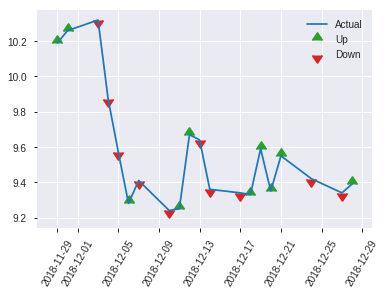


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19159912260838802
RMSE: 0.43772037033748845
LogLoss: 0.5631726196297198
Mean Per-Class Error: 0.29889509779019563
AUC: 0.7785750571501143
pr_auc: 0.7695875399005485
Gini: 0.5571501143002286
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3205682880518621: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      57   67   0.5403   (67.0/124.0)
1      9    118  0.0709   (9.0/127.0)
Total  66   185  0.3028   (76.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.320568     0.75641   184
max f2                       0.235477     0.86351   209
max f0point5                 0.69082      0.725275  81
max accuracy                 0.531979     0.701195  127
max precision                0.875026     1         0
max recall                   0.164289     1         239
max specificity              0.875026     1         0
max absolute_mcc             0.320568     0.441564  184
max min_per_class_accuracy   0.53299      0.693548  126
max mean_per_class_accuracy  0.531979     0.701105  127

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 52.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.868544           1.97638   1.97638            1                0.872681  1                           0.872681            0.023622        0.023622                   97.6378   97.6378
    2        0.0239044                   0.858847           1.97638   1.97638            1                0.862514  1                           0.867597            0.023622        0.0472441                  97.6378   97.6378
    3        0.0318725                   0.853449           1.97638   1.97638            1                0.854454  1                           0.864312            0.015748        0.0629921                  97.6378   97.6378
    4        0.0438247                   0.849066           1.97638   1.97638            1                0.851026  1                           0.860688            0.023622        0.0866142                  97.6378   97.6378
    5        0.0517928                   0.840909           1.97638   1.97638            1                0.843947  1                           0.858113            0.015748        0.102362                   97.6378   97.6378
    6        0.103586                    0.814395           1.52029   1.74833            0.769231         0.827696  0.884615                    0.842904            0.0787402       0.181102                   52.0291   74.8334
    7        0.151394                    0.787085           1.48228   1.66432            0.75             0.802662  0.842105                    0.830196            0.0708661       0.251969                   48.2283   66.4318
    8        0.203187                    0.766845           1.82435   1.70511            0.923077         0.779598  0.862745                    0.817298            0.0944882       0.346457                   82.4349   70.511
    9        0.302789                    0.706846           1.34394   1.5863             0.68             0.741494  0.802632                    0.792363            0.133858        0.480315                   34.3937   58.6303
    10       0.40239                     0.606821           0.948661  1.42847            0.48             0.650031  0.722772                    0.757132            0.0944882       0.574803                   -5.13386  42.8471
    11       0.501992                    0.534502           1.18583   1.38033            0.6              0.5627    0.698413                    0.718554            0.11811         0.692913                   18.5827   38.0327
    12       0.601594                    0.464116           1.02772   1.32195            0.52             0.500142  0.668874                    0.682393            0.102362        0.795276                   2.77165   32.1948
    13       0.701195                    0.372769           0.869606  1.2577             0.44             0.431311  0.636364                    0.646728            0.0866142       0.88189                    -13.0394  25.7695
    14       0.800797                    0.263018           0.790551  1.19959            0.4              0.304173  0.606965                    0.604122            0.0787402       0.96063                    -20.9449  19.9593
    15       0.900398                    0.187761           0.237165  1.09313            0.12             0.223473  0.553097                    0.562015            0.023622        0.984252                   -76.2835  9.31294
    16       1                           0.0982561          0.15811   1                  0.08             0.155986  0.505976                    0.521574          

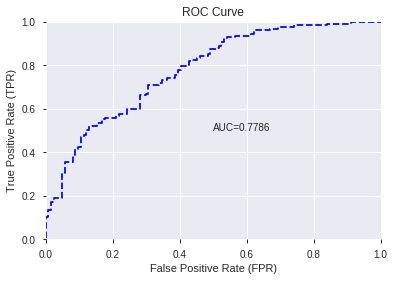

This function is available for GLM models only


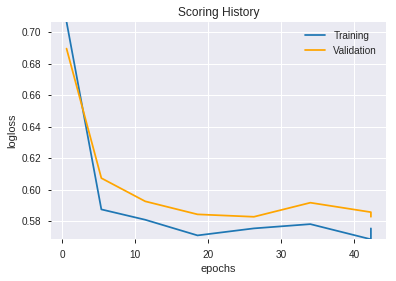

--2019-08-26 20:35:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.228.168
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.228.168|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_202703_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_202703_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_8650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'CDLBELTHOLD',
 'SUB',
 'TRANGE',
 'DIV',
 'STOCHF_fastk',
 'CDLMARUBOZU',
 'CDLENGULFING',
 'STOCHRSI_fastk',
 'MINUS_DM_8',
 'CCI_8',
 'ULTOSC',
 'WILLR_12',
 'STOCH_slowk',
 'STOCHRSI_fastd',
 'STOCHF_fastd',
 'WILLR_8',
 'RSI_24',
 'CMO_30',
 'RSI_30',
 'CCI_12',
 'ROCR_8',
 'CMO_24',
 'CCI_14',
 'ADOSC',
 'WILLR_30',
 'WILLR_24',
 'RSI_20',
 'CCI_20',
 'ROC_12',
 'ROC_20',
 'WILLR_14',
 'CCI_24',
 'ROC_8',
 'CMO_8',
 'ROCP_8',
 'ROCR100_8',
 'CMO_14',
 'MOM_8',
 'ROCP_20',
 'CMO_12',
 'ROCR100_14',
 'ROCR_12',
 'ROCR_14',
 'MINUS_DI_8',
 'ROCR100_20',
 'RSI_12',
 'CMO_20',
 'MINUS_DI_12',
 'ROCR100_12',
 'ROCR_20',
 'ROCP_12',
 'ROCP_14',
 'WILLR_20',
 'RSI_8',
 'ROC_14',
 'MOM_14',
 'RSI_14',
 'MOM_12']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_203527_model_1  0.772289  0.564836               0.28429  0.439415  0.193086

variable  relative_importance  scaled_importance  percentage
0            BOP             0.814164           1.000000    0.106616
1          CCI_8             0.452848           0.556212    0.059301
2     MINUS_DM_8             0.422854           0.519372    0.055374
3        WILLR_8             0.393050           0.482765    0.051471
4   STOCHF_fastk             0.315598           0.387635    0.041328
..           ...                  ...                ...         ...
57        ROC_14             0.016669           0.020474    0.002183
58    MINUS_DI_8             0.012652           0.015540    0.001657
59        CCI_20             0.006811           0.008366    0.000892
60        CMO_30             0.005225           0.006418    0.000684
61        RSI_30             0.002027           0.002490    0.000266

[62 rows x 4 columns]

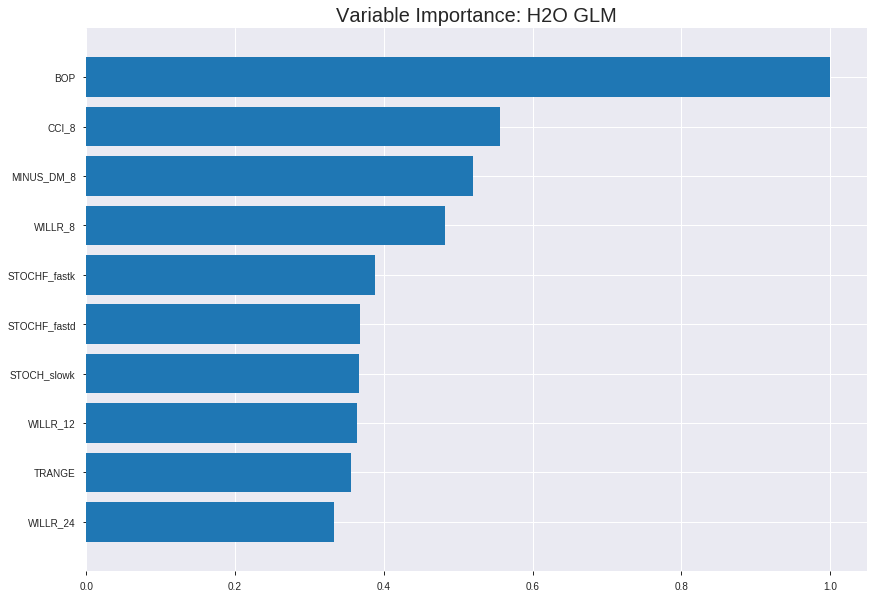

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_203527_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18786315832350192
RMSE: 0.43343183815163133
LogLoss: 0.5556655101792636
Null degrees of freedom: 1752
Residual degrees of freedom: 1690
Null deviance: 2429.6257833865593
Residual deviance: 1948.163278688498
AIC: 2074.163278688498
AUC: 0.7866035947354989
pr_auc: 0.7734250867743647
Gini: 0.5732071894709978
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43669177946063326: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      545  316   0.367    (316.0/861.0)
1      174  718   0.1951   (174.0/892.0)
Total  719  1034  0.2795   (490.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.436692     0.745587  225
max f2                       0.140063     0.852601  358
max f0point5                 0.607224     0.727273  149
max accuracy                 0.504509     0.722761  195
max precision                0.935851     1         0
max recall                   0.0629361    1         387
max specificity              0.935851     1         0
max absolute_mcc             0.447171     0.445346  221
max min_per_class_accuracy   0.51117      0.718931  191
max mean_per_class_accuracy  0.504509     0.722553  195

Gains/Lift Table: Avg response rate: 50.88 %, avg score: 50.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.909325           1.96525   1.96525            1                0.920787  1                           0.920787            0.0201794       0.0201794                  96.5247   96.5247
    2        0.0205362                   0.897519           1.63771   1.80148            0.833333         0.903067  0.916667                    0.911927            0.0168161       0.0369955                  63.7706   80.1476
    3        0.0302339                   0.884205           1.73404   1.77985            0.882353         0.891145  0.90566                     0.905261            0.0168161       0.0538117                  73.4041   77.9846
    4        0.040502                    0.871155           1.63771   1.74381            0.833333         0.87706   0.887324                    0.898111            0.0168161       0.0706278                  63.7706   74.381
    5        0.0501997                   0.864162           1.73404   1.74192            0.882353         0.867757  0.886364                    0.892248            0.0168161       0.0874439                  73.4041   74.1923
    6        0.100399                    0.818894           1.80892   1.77542            0.920455         0.840678  0.903409                    0.866463            0.0908072       0.178251                   80.892    77.5422
    7        0.150029                    0.783466           1.33275   1.62899            0.678161         0.800202  0.828897                    0.844544            0.0661435       0.244395                   33.2753   62.8988
    8        0.200228                    0.754521           1.63026   1.62931            0.829545         0.768575  0.82906                     0.825497            0.0818386       0.326233                   63.0261   62.9307
    9        0.300057                    0.694602           1.41498   1.558              0.72             0.725142  0.792776                    0.792109            0.141256        0.467489                   41.4978   55.8
    10       0.399886                    0.6142             1.32514   1.49987            0.674286         0.654789  0.763195                    0.757828            0.132287        0.599776                   32.5138   49.9867
    11       0.500285                    0.514121           1.13895   1.42744            0.579545         0.565447  0.72634                     0.71922             0.11435         0.714126                   13.895    42.7437
    12       0.600114                    0.42861            0.965778  1.35064            0.491429         0.472918  0.687262                    0.678248            0.0964126       0.810538                   -3.42217  35.064
    13       0.699943                    0.346155           0.741179  1.26372            0.377143         0.385657  0.643032                    0.636517            0.073991        0.884529                   -25.8821  26.3716
    14       0.799772                    0.265081           0.595189  1.18027            0.302857         0.31015   0.600571                    0.59578             0.059417        0.943946                   -40.4811  18.0269
    15       0.899601                    0.164288           0.370589  1.09042            0.188571         0.215689  0.554851                    0.553601            0.0369955       0.980942                   -62.9411  9.0419
    16       1                           0.0109694          0.189825  1                  0.0965909        0.107792  0.508842                    0.508842            0.0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19527611577459664
RMSE: 0.4419005722723118
LogLoss: 0.5719177076396039
Null degrees of freedom: 500
Residual degrees of freedom: 438
Null deviance: 693.5229098211739
Residual deviance: 573.0615430548831
AIC: 699.0615430548831
AUC: 0.7679503185121163
pr_auc: 0.7720068415454872
Gini: 0.5359006370242325
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3312953201856066: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      88   146  0.6239   (146.0/234.0)
1      21   246  0.0787   (21.0/267.0)
Total  109  392  0.3333   (167.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.331295     0.746586  304
max f2                       0.195719     0.865007  359
max f0point5                 0.650302     0.747801  146
max accuracy                 0.641999     0.702595  151
max precision                0.932583     1         0
max recall                   0.0910516    1         386
max specificity              0.932583     1         0
max absolute_mcc             0.650302     0.431483  146
max min_per_class_accuracy   0.563146     0.692308  193
max mean_per_class_accuracy  0.641999     0.71041   151

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 54.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.917026           1.8764    1.8764             1                0.92232   1                           0.92232             0.0224719       0.0224719                  87.6404   87.6404
    2        0.0219561                   0.907527           1.12584   1.53524            0.6              0.910721  0.818182                    0.917048            0.011236        0.0337079                  12.5843   53.524
    3        0.0319361                   0.887847           1.8764    1.64185            1                0.89833   0.875                       0.911198            0.0187266       0.0524345                  87.6404   64.1854
    4        0.0419162                   0.883127           1.8764    1.6977             1                0.884927  0.904762                    0.904943            0.0187266       0.071161                   87.6404   69.7699
    5        0.0518962                   0.869795           1.8764    1.73207            1                0.876547  0.923077                    0.899482            0.0187266       0.0898876                  87.6404   73.2066
    6        0.101796                    0.83103            1.65124   1.69244            0.88             0.84726   0.901961                    0.873883            0.082397        0.172285                   65.1236   69.2443
    7        0.151697                    0.79694            1.57618   1.6542             0.84             0.8119    0.881579                    0.853494            0.0786517       0.250936                   57.618    65.4199
    8        0.201597                    0.766894           1.12584   1.52342            0.6              0.782008  0.811881                    0.835799            0.0561798       0.307116                   12.5843   52.3418
    9        0.301397                    0.697089           1.42607   1.49118            0.76             0.727876  0.794702                    0.800063            0.142322        0.449438                   42.6067   49.1182
    10       0.401198                    0.637184           1.50112   1.49366            0.8              0.666424  0.79602                     0.76682             0.149813        0.599251                   50.1124   49.3655
    11       0.500998                    0.570676           0.863146  1.36806            0.46             0.605286  0.729084                    0.734642            0.0861423       0.685393                   -13.6854  36.8056
    12       0.600798                    0.497318           0.863146  1.28418            0.46             0.531366  0.684385                    0.700875            0.0861423       0.771536                   -13.6854  28.4184
    13       0.700599                    0.402569           0.863146  1.22421            0.46             0.450767  0.652422                    0.665247            0.0861423       0.857678                   -13.6854  22.4207
    14       0.800399                    0.312762           0.750562  1.16515            0.4              0.363102  0.620948                    0.627573            0.0749064       0.932584                   -24.9438  16.5149
    15       0.9002                      0.220283           0.412809  1.08174            0.22             0.27204   0.576497                    0.588157            0.0411985       0.973783                   -58.7191  8.1741
    16       1                           0.000507205        0.262697  1                  0.14             0.128541  0.532934                    0.542287           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-26 20:35:28  0.000 sec   2            .22E2     63            1.360910837471418   1.3542325979496233
     2019-08-26 20:35:28  0.017 sec   4            .14E2     63            1.3510137275780252  1.3429541283279474
     2019-08-26 20:35:28  0.032 sec   6            .84E1     63            1.3385341844999068  1.329332034373016
     2019-08-26 20:35:28  0.048 sec   8            .52E1     63            1.3229734463098795  1.3132031474270878
     2019-08-26 20:35:28  0.062 sec   10           .32E1     63            1.303851340879885   1.2944119571978114
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-26 20:35:28  0.346 sec   40           .25E-2    63            1.1093477781516017  1.1439344682280947
     2019-08-26 20:35:28  0.362 sec   42           .16E-2    63            1.108013335314092   1.1441067957796776
     2019-08-26 20:35:28  0.383 sec   44           .98E-3    63            1.106790994661753   1.1456289665392685
     2019-08-26 20:35:28  0.398 sec   46           .61E-3    63            1.106160031998213   1.1466943207438733
     2019-08-26 20:35:28  0.408 sec   47           .38E-3    63            1.1056559247673377  1.1483504626695387


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7171314741035857)

('F1', 0.7491166077738516)

('auc', 0.7722885445770892)

('logloss', 0.5648361505599965)

('mean_per_class_error', 0.28429006858013717)

('rmse', 0.43941541561281644)

('mse', 0.1930859074781842)

glm prediction progress: |████████████████████████████████████████████████| 100%


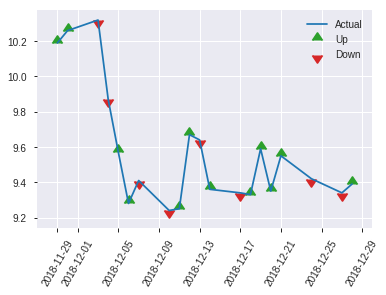


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1930859074781842
RMSE: 0.43941541561281644
LogLoss: 0.5648361505599965
Null degrees of freedom: 250
Residual degrees of freedom: 188
Null deviance: 347.9322754570597
Residual deviance: 283.54774758111824
AIC: 409.54774758111824
AUC: 0.7722885445770892
pr_auc: 0.7496885276153066
Gini: 0.5445770891541784
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43214181250156686: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      74   50   0.4032   (50.0/124.0)
1      21   106  0.1654   (21.0/127.0)
Total  95   156  0.2829   (71.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.432142     0.749117  155
max f2                       0.232504     0.861345  205
max f0point5                 0.566893     0.711948  120
max accuracy                 0.432142     0.717131  155
max precision                0.93704      1         0
max recall                   0.11092      1         232
max specificity              0.93704      1         0
max absolute_mcc             0.432142     0.444722  155
max min_per_class_accuracy   0.55725      0.700787  125
max mean_per_class_accuracy  0.432142     0.71571   155

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 51.13 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.898061           1.97638    1.97638            1                0.921353   1                           0.921353            0.023622        0.023622                   97.6378   97.6378
    2        0.0239044                   0.89025            1.97638    1.97638            1                0.891865   1                           0.906609            0.023622        0.0472441                  97.6378   97.6378
    3        0.0318725                   0.872721           1.97638    1.97638            1                0.879091   1                           0.89973             0.015748        0.0629921                  97.6378   97.6378
    4        0.0438247                   0.859206           1.31759    1.79671            0.666667         0.863164   0.909091                    0.889757            0.015748        0.0787402                  31.7585   79.6707
    5        0.0517928                   0.849738           1.97638    1.82435            1                0.85025    0.923077                    0.883679            0.015748        0.0944882                  97.6378   82.4349
    6        0.103586                    0.818197           1.52029    1.67232            0.769231         0.834249   0.846154                    0.858964            0.0787402       0.173228                   52.0291   67.232
    7        0.151394                    0.776456           1.31759    1.5603             0.666667         0.794001   0.789474                    0.838449            0.0629921       0.23622                    31.7585   56.0298
    8        0.203187                    0.747991           1.36826    1.51135            0.692308         0.761473   0.764706                    0.818828            0.0708661       0.307087                   36.8262   51.1348
    9        0.302789                    0.688862           1.66016    1.5603             0.84             0.721205   0.789474                    0.786715            0.165354        0.472441                   66.0157   56.0298
    10       0.40239                     0.620136           1.02772    1.42847            0.52             0.652706   0.722772                    0.753544            0.102362        0.574803                   2.77165   42.8471
    11       0.501992                    0.55725            1.26488    1.39601            0.64             0.585943   0.706349                    0.72029             0.125984        0.700787                   26.4882   39.6013
    12       0.601594                    0.463114           1.02772    1.33504            0.52             0.507222   0.675497                    0.685014            0.102362        0.80315                    2.77165   33.5037
    13       0.701195                    0.352426           0.711496   1.24647            0.36             0.405619   0.630682                    0.645327            0.0708661       0.874016                   -28.8504  24.6466
    14       0.800797                    0.243692           0.790551   1.18976            0.4              0.291205   0.60199                     0.601282            0.0787402       0.952756                   -20.9449  18.976
    15       0.900398                    0.176763           0.395276   1.10187            0.2              0.206045   0.557522                    0.557561            0.0393701       0.992126                   -60.4724  10.1874
    16       1                           0.0159358          0.0790551  1                  0.04             0.0932412  0.505976   

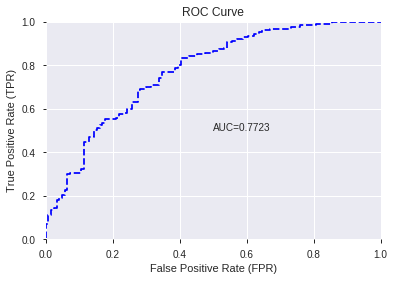

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


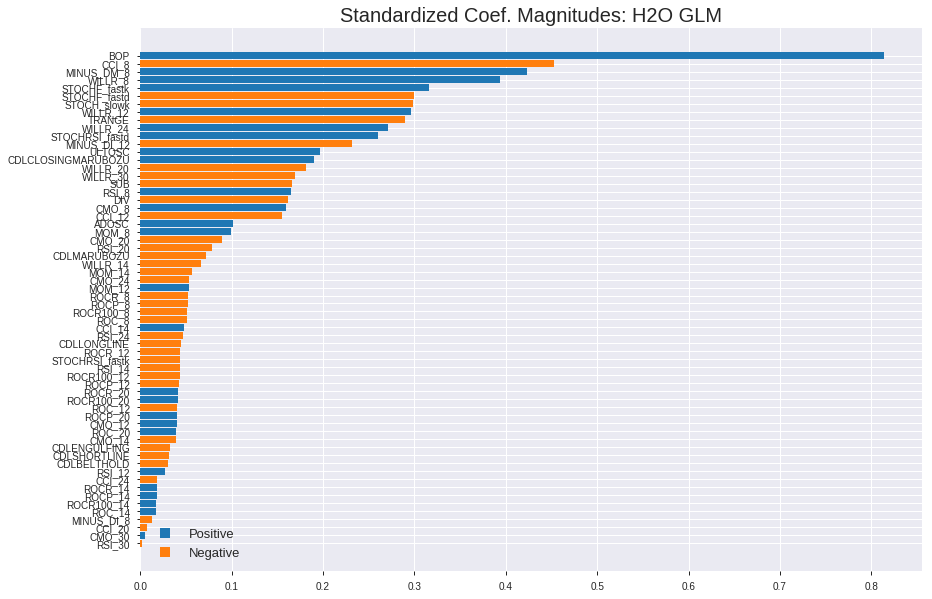

'log_likelihood'
--2019-08-26 20:35:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.128.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.128.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_203527_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_203527_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_8650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'CCI_8',
 'MINUS_DM_8',
 'WILLR_8',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCH_slowk',
 'WILLR_12',
 'TRANGE',
 'WILLR_24',
 'STOCHRSI_fastd',
 'MINUS_DI_12',
 'ULTOSC',
 'CDLCLOSINGMARUBOZU',
 'WILLR_20',
 'WILLR_30',
 'SUB',
 'RSI_8',
 'DIV',
 'CMO_8',
 'CCI_12',
 'ADOSC',
 'MOM_8',
 'CMO_20',
 'RSI_20',
 'CDLMARUBOZU',
 'WILLR_14',
 'MOM_14',
 'CMO_24',
 'MOM_12',
 'ROCR_8',
 'ROCP_8',
 'ROCR100_8',
 'ROC_8',
 'CCI_14',
 'RSI_24',
 'CDLLONGLINE',
 'ROCR_12',
 'STOCHRSI_fastk',
 'RSI_14',
 'ROCR100_12',
 'ROCP_12',
 'ROCR_20',
 'ROCR100_20',
 'ROC_12',
 'ROCP_20',
 'CMO_12',
 'ROC_20',
 'CMO_14',
 'CDLENGULFING',
 'CDLSHORTLINE',
 'CDLBELTHOLD',
 'RSI_12',
 'CCI_24',
 'ROCR_14',
 'ROCP_14',
 'ROCR100_14',
 'ROC_14',
 'MINUS_DI_8',
 'CCI_20',
 'CMO_30',
 'RSI_30']

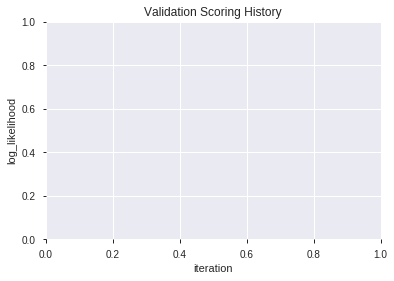

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190826_203544  0.766701  0.573531              0.293021  0.441297  0.194743
1  XGBoost_grid_1_AutoML_20190826_203544_model_4  0.764986  0.577620              0.321723  0.443597  0.196779
2  XGBoost_grid_1_AutoML_20190826_203544_model_5  0.764669  0.574245              0.280829  0.442721  0.196002
3  XGBoost_grid_1_AutoML_20190826_203544_model_3  0.763399  0.574761              0.337948  0.443552  0.196739
4  XGBoost_grid_1_AutoML_20190826_203544_model_6  0.757620  0.580792              0.313945  0.445911  0.198837
5               XGBoost_1_AutoML_20190826_203544  0.754826  0.583054              0.281115  0.446837  0.199663
6  XGBoost_grid_1_AutoML_20190826_203544_model_7  0.753810  0.586818              0.313468  0.449630  0.202167
7  XGBoost_grid_1_AutoML_20190826_203544_model_2  0.752286  0.583796              0.285147  0.446835  0.199661
8               XGBoost_3_AutoML_20190826_203544  0.750381  0.587785              0.309341  0.449163  0.201748
9  XGBoost_grid_1_AutoML_20190826_203544_model_1  0.746126  0.589157              0.325946  0.450502  0.202952

variable  relative_importance  scaled_importance  percentage
0                  BOP          2072.709473           1.000000    0.292871
1                  DIV           504.318420           0.243314    0.071260
2         STOCHF_fastk           480.639801           0.231890    0.067914
3                  SUB           289.503235           0.139674    0.040906
4                CCI_8           191.143433           0.092219    0.027008
5               TRANGE           187.557526           0.090489    0.026502
6           MINUS_DM_8           172.288925           0.083123    0.024344
7               CCI_12           162.854950           0.078571    0.023011
8               ULTOSC           158.365341           0.076405    0.022377
9               ROC_14           155.211594           0.074883    0.021931
10         MINUS_DI_12           140.554672           0.067812    0.019860
11             WILLR_8           134.343582           0.064815    0.018983
12         STOCH_slowk           131.997833           0.063684    0.018651
13               MOM_8           125.060783           0.060337    0.017671
14              CMO_24           109.637779           0.052896    0.015492
15               ROC_8           107.855972           0.052036    0.015240
16      STOCHRSI_fastk           107.685730           0.051954    0.015216
17               ADOSC           100.436295           0.048457    0.014192
18              CCI_20           100.249336           0.048366    0.014165
19      STOCHRSI_fastd            94.357529           0.045524    0.013333
20              MOM_14            93.239029           0.044984    0.013175
21            WILLR_14            91.233978           0.044017    0.012891
22            WILLR_12            90.669525           0.043744    0.012811
23              CMO_30            79.720940           0.038462    0.011264
24              CCI_14            75.537613           0.036444    0.010673
25              ROC_20            75.406784           0.036381    0.010655
26          MINUS_DI_8            73.582657           0.035501    0.010397
27            WILLR_20            73.207664           0.035320    0.010344
28         CDLLONGLINE            70.378601           0.033955    0.009944
29              ROC_12            70.133652           0.033837    0.009910
30               CMO_8            62.479660           0.030144    0.008828
31            WILLR_24            57.219719           0.027606    0.008085
32              CCI_24            55.907204           0.026973    0.007900
33            WILLR_30            53.076965           0.025608    0.007500
34              MOM_12            49.809322           0.024031    0.007038
35             ROCP_20            47.710926           0.023019    0.006741
36        STOCHF_fastd            43.673973           0.021071    0.006171
37             ROCP_12            38.268272           0.018463    0.005407
38              CMO_20            34.406799           0.016600    0.004862
39             ROCP_14            30.594721           0.014761    0.004323
40  CDLCLOSINGMARUBOZU            27.810722           0.013418    0.003930
41              ROCP_8            25.730667           0.012414    0.003636
42              CMO_12            25.245369           0.012180    0.003567
43              RSI_30            24.705521           0.011919    0.003491
44               RSI_8            23.189709           0.011188    0.003277
45              RSI_14            20.448713           0.009866    0.002889
46         CDLBELTHOLD            18.507822           0.008929    0.002615
47             ROCR_20            17.191925           0.008294    0.002429
48           ROCR100_8            16.633686           0.008025    0.002350
49              RSI_12            15.262119           0.007363    0.002157
50        CDLSHORTLINE            14.244175           0.006872    0.002013
51              RSI_24            13.493667           0.006510    0.001907
52              CMO_14            13.35

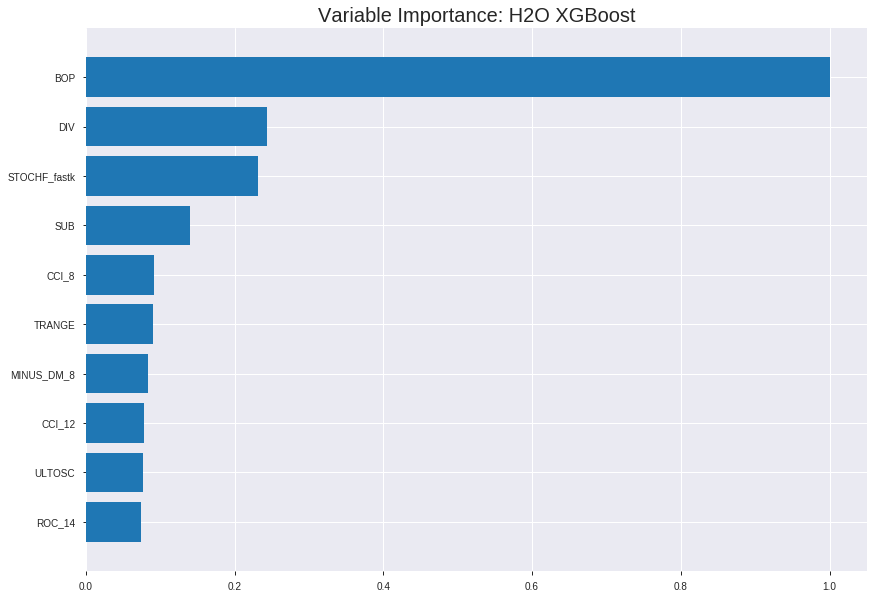

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190826_203544


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14540347851164626
RMSE: 0.38131808049402305
LogLoss: 0.45938886766969117
Mean Per-Class Error: 0.18151604402014554
AUC: 0.8944274308213935
pr_auc: 0.8978021650725962
Gini: 0.7888548616427871
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4591394901275635: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      614  247   0.2869   (247.0/861.0)
1      101  791   0.1132   (101.0/892.0)
Total  715  1038  0.1985   (348.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.459139     0.819689  219
max f2                       0.309232     0.881811  284
max f0point5                 0.594631     0.836387  155
max accuracy                 0.55309      0.818026  175
max precision                0.904013     1         0
max recall                   0.139194     1         365
max specificity              0.904013     1         0
max absolute_mcc             0.55309      0.637391  175
max min_per_class_accuracy   0.528885     0.809417  186
max mean_per_class_accuracy  0.55309      0.818484  175

Gains/Lift Table: Avg response rate: 50.88 %, avg score: 50.89 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.873267           1.96525    1.96525            1                0.887494  1                           0.887494            0.0201794       0.0201794                  96.5247   96.5247
    2        0.0205362                   0.863916           1.96525    1.96525            1                0.869294  1                           0.878394            0.0201794       0.0403587                  96.5247   96.5247
    3        0.0302339                   0.849338           1.96525    1.96525            1                0.855966  1                           0.8712              0.0190583       0.059417                   96.5247   96.5247
    4        0.040502                    0.84156            1.96525    1.96525            1                0.845201  1                           0.864609            0.0201794       0.0795964                  96.5247   96.5247
    5        0.0501997                   0.833649           1.96525    1.96525            1                0.838205  1                           0.859508            0.0190583       0.0986547                  96.5247   96.5247
    6        0.100399                    0.805304           1.92058    1.94291            0.977273         0.819527  0.988636                    0.839518            0.0964126       0.195067                   92.0582   94.2914
    7        0.150029                    0.77941            1.80712    1.89799            0.91954          0.792533  0.965779                    0.823975            0.0896861       0.284753                   80.7123   89.7995
    8        0.200228                    0.749483           1.85358    1.88686            0.943182         0.76533   0.960114                    0.809272            0.0930493       0.377803                   85.3585   88.6861
    9        0.300057                    0.681601           1.67327    1.8158             0.851429         0.715833  0.923954                    0.778185            0.16704         0.544843                   67.3267   81.5798
    10       0.399886                    0.61086            1.44867    1.72415            0.737143         0.648087  0.877318                    0.745707            0.144619        0.689462                   44.8668   72.4146
    11       0.500285                    0.531561           1.17245    1.61343            0.596591         0.572273  0.820981                    0.710901            0.117713        0.807175                   17.2448   61.3429
    12       0.600114                    0.449908           0.831019   1.48328            0.422857         0.491067  0.754753                    0.674332            0.0829596       0.890135                   -16.8981  48.3276
    13       0.699943                    0.355534           0.505349   1.3438             0.257143         0.40376   0.683782                    0.635742            0.0504484       0.940583                   -49.4651  34.3799
    14       0.799772                    0.263721           0.381819   1.22372            0.194286         0.30767   0.622682                    0.594791            0.0381166       0.9787                     -61.8181  22.3723
    15       0.899601                    0.163305           0.17968    1.10787            0.0914286        0.213202  0.563729                    0.552446            0.0179372       0.996637                   -82.032   10.7866
    16       1                           0.0542881          0.0334985  1                  0.0170455        0.118769  0.508842                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20553199519023105
RMSE: 0.4533563666589795
LogLoss: 0.5961172340888188
Mean Per-Class Error: 0.3290358206088543
AUC: 0.7368193604148661
pr_auc: 0.7338124921091748
Gini: 0.47363872082973213
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3738084137439728: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      85   149  0.6368   (149.0/234.0)
1      19   248  0.0712   (19.0/267.0)
Total  104  397  0.3353   (168.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.373808     0.746988  305
max f2                       0.14252      0.864078  375
max f0point5                 0.574941     0.693665  188
max accuracy                 0.521753     0.674651  221
max precision                0.894334     1         0
max recall                   0.14252      1         375
max specificity              0.894334     1         0
max absolute_mcc             0.373808     0.359305  305
max min_per_class_accuracy   0.569994     0.662921  194
max mean_per_class_accuracy  0.549189     0.670964  207

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 54.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.863405           1.25094   1.25094            0.666667         0.880164  0.666667                    0.880164            0.0149813       0.0149813                  25.0936   25.0936
    2        0.0219561                   0.853507           1.50112   1.36466            0.8              0.857748  0.727273                    0.869975            0.0149813       0.0299625                  50.1124   36.4658
    3        0.0319361                   0.845272           1.50112   1.4073             0.8              0.84841   0.75                        0.863236            0.0149813       0.0449438                  50.1124   40.7303
    4        0.0419162                   0.832573           1.8764    1.51899            1                0.837817  0.809524                    0.857184            0.0187266       0.0636704                  87.6404   51.8994
    5        0.0518962                   0.824519           1.8764    1.58773            1                0.828379  0.846154                    0.851644            0.0187266       0.082397                   87.6404   58.7727
    6        0.101796                    0.785181           1.50112   1.54527            0.8              0.801376  0.823529                    0.827003            0.0749064       0.157303                   50.1124   54.5274
    7        0.151697                    0.760285           1.50112   1.53075            0.8              0.769502  0.815789                    0.808088            0.0749064       0.23221                    50.1124   53.0751
    8        0.201597                    0.733467           1.57618   1.542              0.84             0.746746  0.821782                    0.792904            0.0786517       0.310861                   57.618    54.1996
    9        0.301397                    0.672124           1.27596   1.4539             0.68             0.701509  0.774834                    0.762641            0.127341        0.438202                   27.5955   45.3903
    10       0.401198                    0.625161           1.12584   1.3723             0.6              0.647401  0.731343                    0.733974            0.11236         0.550562                   12.5843   37.2296
    11       0.500998                    0.570474           1.05079   1.30825            0.56             0.594491  0.697211                    0.706189            0.104869        0.655431                   5.07865   30.825
    12       0.600798                    0.507448           0.900674  1.24055            0.48             0.537036  0.66113                     0.67809             0.0898876       0.745318                   -9.93258  24.0546
    13       0.700599                    0.436949           0.97573   1.20282            0.52             0.474689  0.641026                    0.649116            0.0973783       0.842697                   -2.42697  20.2823
    14       0.800399                    0.366352           0.863146  1.16047            0.46             0.403036  0.618454                    0.618432            0.0861423       0.928839                   -13.6854  16.047
    15       0.9002                      0.248818           0.412809  1.07758            0.22             0.29938   0.574279                    0.583061            0.0411985       0.970037                   -58.7191  7.75804
    16       1                           0.0646948          0.300225  1                  0.16             0.157373  0.532934                    0.540577           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 20:35:46  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.491158                         0.5                0.693147              0.5               0                    1                  0.467066
    2019-08-26 20:35:46  0.068 sec   5                  0.475147         0.644404            0.821439        0.808406           1.85607          0.268682                         0.483364           0.660253              0.736099          0.740861             1.56367            0.329341
    2019-08-26 20:35:46  0.121 sec   10                 0.455661         0.60686             0.830936        0.827941           1.85607          0.257844                         0.471803           0.637451              0.742958          0.734432             1.25094            0.327345
    2019-08-26 20:35:47  0.191 sec   15                 0.441261         0.579002            0.839491        0.840821           1.85607          0.243012                         0.463866           0.621542              0.747583          0.73845              1.25094            0.313373
    2019-08-26 20:35:47  0.249 sec   20                 0.430296         0.557403            0.846163        0.84546            1.96525          0.232744                         0.459506           0.612274              0.746255          0.740501             1.25094            0.357285
    2019-08-26 20:35:47  0.309 sec   25                 0.420942         0.538658            0.853322        0.854512           1.96525          0.22818                          0.456289           0.605108              0.746879          0.7451               1.56367            0.345309
    2019-08-26 20:35:47  0.373 sec   30                 0.413783         0.524265            0.858882        0.859268           1.96525          0.233314                         0.454546           0.60106               0.744206          0.740925             1.25094            0.335329
    2019-08-26 20:35:47  0.435 sec   35                 0.406907         0.510446            0.866143        0.869551           1.96525          0.226469                         0.453937           0.59945               0.742261          0.735546             1.25094            0.339321
    2019-08-26 20:35:47  0.503 sec   40                 0.401108         0.498269            0.869746        0.873316           1.96525          0.225898                         0.454198           0.599085              0.737011          0.731865             1.56367            0.343313
    2019-08-26 20:35:47  0.572 sec   45                 0.395693         0.487533            0.877088        0.882919           1.96525          0.220764                         0.455013           0.600386              0.733842          0.729802             1.56367            0.347305
    2019-08-26 20:35:47  0.641 sec   50                 0.391005         0.477979            0.881707        0.887061           1.96525          0.213919                         0.453698           0.59731               0.736547          0.731722             1.56367            0.341317
    2019-08-26 20:35:47  0.709 sec   55                 0.386149         0.468568            0.887777        0.892122           1.96525          0.204221                         0.453776           0.597304              0.737171          0

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ----------------------
BOP           2072.70947265625       1.0                    0.2928711240099608
DIV           504.31842041015625     0.24331360813624037    0.07125952990177986
STOCHF_fastk  480.6398010253906      0.23188961471258865    0.06791377210711258
SUB           289.50323486328125     0.13967381279551574    0.04090642654817954
CCI_8         191.1434326171875      0.09221911470893722    0.02700831578000995
---           ---                    ---                    ---
ROCR_14       10.69764518737793      0.005161188930964127   0.0015115632034392317
RSI_20        7.4339447021484375     0.0035865830692719206  0.0010504066148527625
ROCR100_12    6.29074764251709       0.0030350358916704694  0.0008888743730041038
ROCR_12       3.56453275680542       0.00171974548475303    0.0005036637931306747
ROCR_8        0.36733245849609375    0.0001772233221018401  5.1903593544745235e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7330677290836654)

('F1', 0.7558528428093645)

('auc', 0.7667005334010668)

('logloss', 0.5735306040770145)

('mean_per_class_error', 0.26768478536957074)

('rmse', 0.4412969071416964)

('mse', 0.194742960252827)

xgboost prediction progress: |████████████████████████████████████████████| 100%


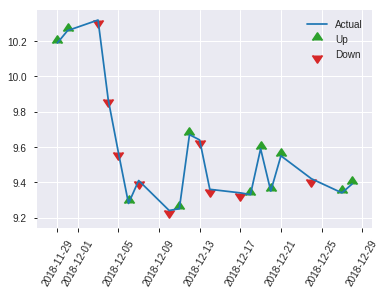


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.194742960252827
RMSE: 0.4412969071416964
LogLoss: 0.5735306040770145
Mean Per-Class Error: 0.26768478536957074
AUC: 0.7667005334010668
pr_auc: 0.7070438958609876
Gini: 0.5334010668021336
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3687779903411865: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      65   59   0.4758   (59.0/124.0)
1      14   113  0.1102   (14.0/127.0)
Total  79   172  0.2908   (73.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.368778     0.755853  171
max f2                       0.147079     0.855978  227
max f0point5                 0.48051      0.726619  141
max accuracy                 0.48051      0.733068  141
max precision                0.899701     1         0
max recall                   0.12452      1         236
max specificity              0.899701     1         0
max absolute_mcc             0.48051      0.468665  141
max min_per_class_accuracy   0.532926     0.716535  125
max mean_per_class_accuracy  0.48051      0.732315  141

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 49.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.872699           1.31759   1.31759            0.666667         0.882994  0.666667                    0.882994            0.015748        0.015748                   31.7585   31.7585
    2        0.0239044                   0.863487           1.31759   1.31759            0.666667         0.866311  0.666667                    0.874653            0.015748        0.0314961                  31.7585   31.7585
    3        0.0318725                   0.835981           1.97638   1.48228            1                0.851274  0.75                        0.868808            0.015748        0.0472441                  97.6378   48.2283
    4        0.0438247                   0.8148             1.31759   1.43737            0.666667         0.823688  0.727273                    0.856503            0.015748        0.0629921                  31.7585   43.7366
    5        0.0517928                   0.81002            0.988189  1.36826            0.5              0.813233  0.692308                    0.849846            0.00787402      0.0708661                  -1.1811   36.8262
    6        0.103586                    0.777844           1.52029   1.44428            0.769231         0.792146  0.730769                    0.820996            0.0787402       0.149606                   52.0291   44.4276
    7        0.151394                    0.746059           1.48228   1.45628            0.75             0.763758  0.736842                    0.802921            0.0708661       0.220472                   48.2283   45.6278
    8        0.203187                    0.728285           1.52029   1.4726             0.769231         0.734983  0.745098                    0.785603            0.0787402       0.299213                   52.0291   47.2595
    9        0.302789                    0.669162           1.5811    1.50829            0.8              0.695487  0.763158                    0.75596             0.15748         0.456693                   58.1102   50.8288
    10       0.40239                     0.602008           1.18583   1.42847            0.6              0.632369  0.722772                    0.725368            0.11811         0.574803                   18.5827   42.8471
    11       0.501992                    0.532926           1.42299   1.42738            0.72             0.567974  0.722222                    0.694139            0.141732        0.716535                   42.2992   42.7384
    12       0.601594                    0.44385            0.869606  1.33504            0.44             0.488163  0.675497                    0.660037            0.0866142       0.80315                    -13.0394  33.5037
    13       0.701195                    0.360406           0.948661  1.28015            0.48             0.397313  0.647727                    0.622718            0.0944882       0.897638                   -5.13386  28.0154
    14       0.800797                    0.254491           0.553386  1.18976            0.28             0.303374  0.60199                     0.582999            0.0551181       0.952756                   -44.6614  18.976
    15       0.900398                    0.152241           0.31622   1.09313            0.16             0.194322  0.553097                    0.540004            0.0314961       0.984252                   -68.378   9.31294
    16       1                           0.0706829          0.15811   1                  0.08             0.112598  0.505976                    0.497433          

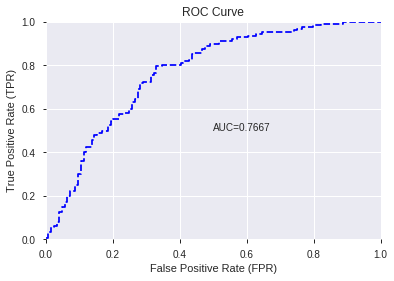

This function is available for GLM models only


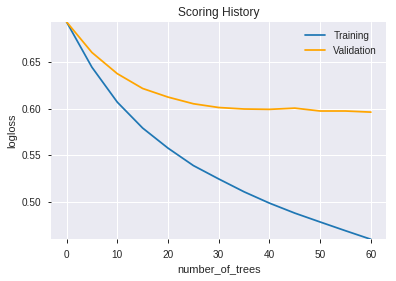

--2019-08-26 20:36:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


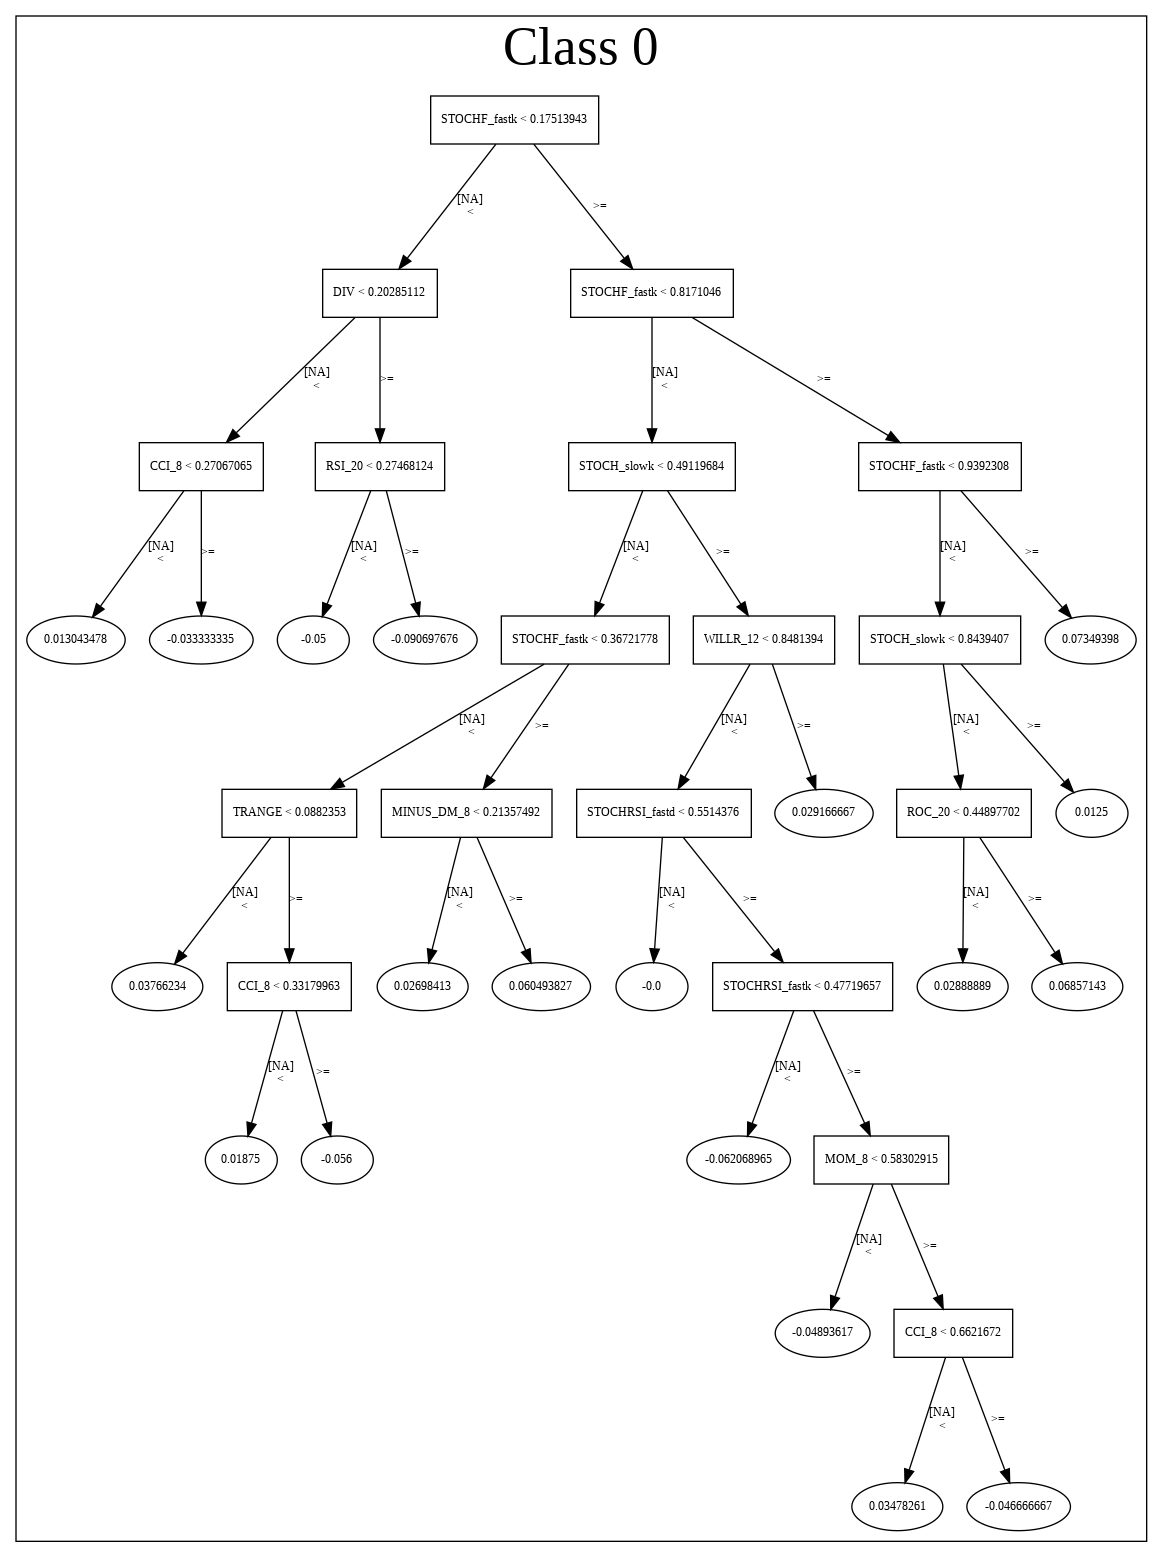

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190826_203544',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190826_203544',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_8650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_8650',
   'type

['BOP',
 'DIV',
 'STOCHF_fastk',
 'SUB',
 'CCI_8',
 'TRANGE',
 'MINUS_DM_8',
 'CCI_12',
 'ULTOSC',
 'ROC_14',
 'MINUS_DI_12',
 'WILLR_8',
 'STOCH_slowk',
 'MOM_8',
 'CMO_24',
 'ROC_8',
 'STOCHRSI_fastk',
 'ADOSC',
 'CCI_20',
 'STOCHRSI_fastd',
 'MOM_14',
 'WILLR_14',
 'WILLR_12',
 'CMO_30',
 'CCI_14',
 'ROC_20',
 'MINUS_DI_8',
 'WILLR_20',
 'CDLLONGLINE',
 'ROC_12',
 'CMO_8',
 'WILLR_24',
 'CCI_24',
 'WILLR_30',
 'MOM_12',
 'ROCP_20',
 'STOCHF_fastd',
 'ROCP_12',
 'CMO_20',
 'ROCP_14',
 'CDLCLOSINGMARUBOZU',
 'ROCP_8',
 'CMO_12',
 'RSI_30',
 'RSI_8',
 'RSI_14',
 'CDLBELTHOLD',
 'ROCR_20',
 'ROCR100_8',
 'RSI_12',
 'CDLSHORTLINE',
 'RSI_24',
 'CMO_14',
 'ROCR_14',
 'RSI_20',
 'ROCR100_12',
 'ROCR_12',
 'ROCR_8']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

669

['MA_12_0',
 'MAVP_12_0',
 'BBANDS_upperband_12_0_2',
 'BBANDS_middleband_12_0_2',
 'BBANDS_lowerband_12_0_2',
 'BBANDS_upperband_12_0_3',
 'BBANDS_middleband_12_0_3',
 'BBANDS_lowerband_12_0_3',
 'BBANDS_upperband_12_0_4',
 'BBANDS_middleband_12_0_4',
 'BBANDS_lowerband_12_0_4',
 'BBANDS_upperband_12_0_5',
 'BBANDS_middleband_12_0_5',
 'BBANDS_lowerband_12_0_5',
 'MA_12_1',
 'MAVP_12_1',
 'BBANDS_upperband_12_1_2',
 'BBANDS_middleband_12_1_2',
 'BBANDS_lowerband_12_1_2',
 'BBANDS_upperband_12_1_3',
 'BBANDS_middleband_12_1_3',
 'BBANDS_lowerband_12_1_3',
 'BBANDS_upperband_12_1_4',
 'BBANDS_middleband_12_1_4',
 'BBANDS_lowerband_12_1_4',
 'BBANDS_upperband_12_1_5',
 'BBANDS_middleband_12_1_5',
 'BBANDS_lowerband_12_1_5',
 'MA_12_2',
 'MAVP_12_2',
 'BBANDS_upperband_12_2_2',
 'BBANDS_middleband_12_2_2',
 'BBANDS_lowerband_12_2_2',
 'BBANDS_upperband_12_2_3',
 'BBANDS_middleband_12_2_3',
 'BBANDS_lowerband_12_2_3',
 'BBANDS_upperband_12_2_4',
 'BBANDS_middleband_12_2_4',
 'BBANDS_lowerb

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_203717_model_4  0.737173  0.750449              0.307817  0.484300  0.234546
1  DeepLearning_grid_1_AutoML_20190826_203717_model_6  0.731585  0.605574              0.332677  0.458008  0.209772
2  DeepLearning_grid_1_AutoML_20190826_203717_model_3  0.728029  0.637797              0.374333  0.465517  0.216706
3  DeepLearning_grid_1_AutoML_20190826_203717_model_5  0.726822  0.618815              0.316739  0.462844  0.214224
4  DeepLearning_grid_1_AutoML_20190826_203717_model_9  0.725044  0.618352              0.312325  0.462920  0.214295
5  DeepLearning_grid_1_AutoML_20190826_203717_model_8  0.717424  0.615879              0.336614  0.462770  0.214156
6  DeepLearning_grid_1_AutoML_20190826_203717_model_7  0.691072  0.745822              0.423101  0.496893  0.246903
7  DeepLearning_grid_1_AutoML_20190826_203717_model_2  0.679578  0.840077              0.389796  0.511644  0.261779
8  DeepLearning_grid_1_AutoML_20190826_203717_model_1  0.601283  3.385661              0.381255  0.611316  0.373707
9               DeepLearning_1_AutoML_20190826_203717  0.571946  0.789436              0.479743  0.521037  0.271479

variable  relative_importance  scaled_importance  percentage
0                         BOP             1.000000           1.000000    0.002879
1                 CDLPIERCING             0.957888           0.957888    0.002757
2           CDL3WHITESOLDIERS             0.946965           0.946965    0.002726
3              CDLEVENINGSTAR             0.941718           0.941718    0.002711
4           CDLSTALLEDPATTERN             0.930541           0.930541    0.002679
..                        ...                  ...                ...         ...
664  BBANDS_middleband_14_0_4             0.468318           0.468318    0.001348
665                 MAVP_14_5             0.466260           0.466260    0.001342
666                   MA_30_5             0.464806           0.464806    0.001338
667                MACDFIX_12             0.458913           0.458913    0.001321
668   BBANDS_lowerband_20_3_4             0.453767           0.453767    0.001306

[669 rows x 4 columns]

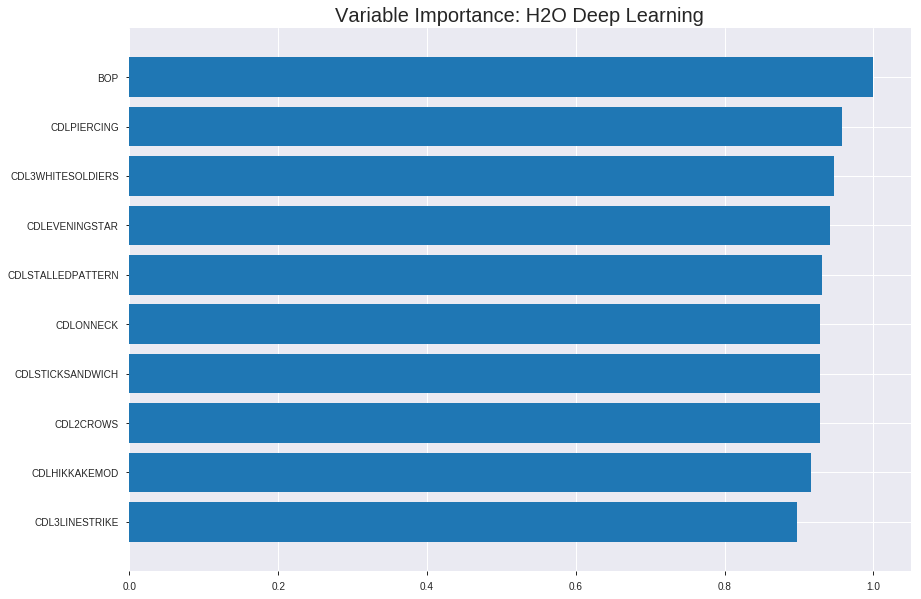

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_203717_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17359216158025553
RMSE: 0.4166439266091077
LogLoss: 0.5618276592678413
Mean Per-Class Error: 0.23405428561012065
AUC: 0.8349185950219528
pr_auc: 0.8060661450828238
Gini: 0.6698371900439055
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3911240625484899: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      559  302   0.3508   (302.0/861.0)
1      129  763   0.1446   (129.0/892.0)
Total  688  1065  0.2459   (431.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.391124     0.779765  242
max f2                       0.0568764    0.854667  363
max f0point5                 0.81861      0.781613  97
max accuracy                 0.647736     0.765545  159
max precision                0.993069     0.935484  8
max recall                   0.00625976   1         395
max specificity              0.999779     0.997677  0
max absolute_mcc             0.647736     0.532152  159
max min_per_class_accuracy   0.609074     0.758969  173
max mean_per_class_accuracy  0.647736     0.765946  159

Gains/Lift Table: Avg response rate: 50.88 %, avg score: 54.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.999678           1.85607   1.85607            0.944444         0.999843   0.944444                    0.999843            0.0190583       0.0190583                  85.6066   85.6066
    2        0.0205362                   0.999149           1.74689   1.80148            0.888889         0.999406   0.916667                    0.999625            0.0179372       0.0369955                  74.6886   80.1476
    3        0.0302339                   0.997871           1.73404   1.77985            0.882353         0.998523   0.90566                     0.999271            0.0168161       0.0538117                  73.4041   77.9846
    4        0.040502                    0.996774           1.85607   1.79917            0.944444         0.997334   0.915493                    0.99878             0.0190583       0.07287                    85.6066   79.9169
    5        0.0501997                   0.995704           1.96525   1.83125            1                0.996231   0.931818                    0.998288            0.0190583       0.0919283                  96.5247   83.1253
    6        0.100399                    0.984841           1.80892   1.82009            0.920455         0.991149   0.926136                    0.994718            0.0908072       0.182735                   80.892    82.0086
    7        0.150029                    0.969615           1.67159   1.77096            0.850575         0.97712    0.901141                    0.988897            0.0829596       0.265695                   67.1589   77.0964
    8        0.200228                    0.949293           1.71959   1.75808            0.875            0.960167   0.894587                    0.981694            0.0863229       0.352018                   71.9591   75.8084
    9        0.300057                    0.880434           1.59466   1.70371            0.811429         0.916983   0.86692                     0.960165            0.159193        0.511211                   59.4657   70.3712
    10       0.399886                    0.767934           1.35883   1.61761            0.691429         0.830126   0.82311                     0.927701            0.13565         0.646861                   35.8828   61.7614
    11       0.500285                    0.614952           1.09429   1.51259            0.556818         0.695824   0.769669                    0.881167            0.109865        0.756726                   9.42851   51.259
    12       0.600114                    0.399398           0.920858  1.41416            0.468571         0.508895   0.719582                    0.81924             0.0919283       0.848655                   -7.91416  41.4156
    13       0.699943                    0.230989           0.561499  1.29255            0.285714         0.313348   0.657702                    0.747087            0.0560538       0.904709                   -43.8501  29.2546
    14       0.799772                    0.112467           0.381819  1.17887            0.194286         0.164222   0.599857                    0.674333            0.0381166       0.942825                   -61.8181  17.8868
    15       0.899601                    0.0344285          0.393049  1.09167            0.2              0.0685627  0.555485                    0.607111            0.0392377       0.982063                   -60.6951  9.16652
    16       1                           6.20188e-05        0.178659  1                  0.0909091        0.0156035  0.508842                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2506032543434786
RMSE: 0.5006028908660821
LogLoss: 0.8080554474575301
Mean Per-Class Error: 0.3421924517430135
AUC: 0.7006626332469029
pr_auc: 0.7117918026554697
Gini: 0.40132526649380584
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.06411422226373734: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      34   200  0.8547   (200.0/234.0)
1      5    262  0.0187   (5.0/267.0)
Total  39   462  0.4092   (205.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0641142    0.718793  368
max f2                       0.042126     0.857143  377
max f0point5                 0.641999     0.682008  161
max accuracy                 0.566549     0.656687  199
max precision                0.999868     1         0
max recall                   0.000560761  1         398
max specificity              0.999868     1         0
max absolute_mcc             0.641999     0.315792  161
max min_per_class_accuracy   0.602788     0.644195  181
max mean_per_class_accuracy  0.641999     0.657808  161

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 57.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.999568           1.8764    1.8764             1                0.999683   1                           0.999683            0.0224719       0.0224719                  87.6404   87.6404
    2        0.0219561                   0.998783           1.50112   1.70582            0.8              0.999232   0.909091                    0.999478            0.0149813       0.0374532                  50.1124   70.5822
    3        0.0319361                   0.997041           1.50112   1.64185            0.8              0.997785   0.875                       0.998949            0.0149813       0.0524345                  50.1124   64.1854
    4        0.0419162                   0.995945           1.12584   1.51899            0.6              0.996578   0.809524                    0.998384            0.011236        0.0636704                  12.5843   51.8994
    5        0.0518962                   0.994667           1.50112   1.51556            0.8              0.994915   0.807692                    0.997717            0.0149813       0.0786517                  50.1124   51.5557
    6        0.101796                    0.985227           1.50112   1.50848            0.8              0.990573   0.803922                    0.994215            0.0749064       0.153558                   50.1124   50.8482
    7        0.151697                    0.97324            1.65124   1.55544            0.88             0.980396   0.828947                    0.989669            0.082397        0.235955                   65.1236   55.5441
    8        0.201597                    0.945868           1.2009    1.46768            0.64             0.957902   0.782178                    0.981806            0.0599251       0.29588                    20.0899   46.7683
    9        0.301397                    0.879376           1.2009    1.37934            0.64             0.92021    0.735099                    0.96141             0.11985         0.41573                    20.0899   37.9344
    10       0.401198                    0.719699           1.01326   1.28828            0.54             0.795102   0.686567                    0.92004             0.101124        0.516854                   1.32584   28.8278
    11       0.500998                    0.610322           1.16337   1.2634             0.62             0.654887   0.673307                    0.867221            0.116105        0.632959                   16.3371   26.3396
    12       0.600798                    0.496679           1.01326   1.22184            0.54             0.559114   0.651163                    0.81604             0.101124        0.734082                   1.32584   22.1845
    13       0.700599                    0.312845           0.78809   1.16006            0.42             0.408663   0.618234                    0.758009            0.0786517       0.812734                   -21.191   16.0056
    14       0.800399                    0.185673           0.825618  1.11836            0.44             0.242244   0.59601                     0.693699            0.082397        0.895131                   -17.4382  11.8356
    15       0.9002                      0.0809759          0.637978  1.0651             0.34             0.134041   0.567627                    0.631653            0.0636704       0.958801                   -36.2022  6.50988
    16       1                           4.56235e-05        0.412809  1                  0.22             0.0359736  0.532934                   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 20:42:11  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 20:42:15  5.428 sec         209 obs/sec       0.463206  1             812        0.602497         2.22735             -0.452464      0.665899        0.442313           1.74689          0.409584                         0.573121           2.29046               -0.319597        0.661217          0.632214             1.8764             0.38523
    2019-08-26 20:42:31  21.148 sec        224 obs/sec       2.31774   5             4063       0.560787         1.62618             -0.258323      0.665419        0.546742           1.74689          0.40445                          0.602437           1.84462               -0.458045        0.605829          0.610514             0.625468           0.433134
    2019-08-26 20:42:48  38.418 sec        239 obs/sec       4.63434   10            8124       0.534889         1.08194             -0.144783      0.724502        0.677349           1.96525          0.369082                         0.549378           1.20782               -0.212527        0.674213          0.654403             1.8764             0.371257
    2019-08-26 20:43:04  54.534 sec        252 obs/sec       6.99544   15            12263      0.53588          1.26309             -0.14903       0.732331        0.605671           1.74689          0.343982                         0.577188           1.55728               -0.338389        0.662313          0.612748             1.56367            0.391218
    2019-08-26 20:43:19  1 min  9.475 sec  262 obs/sec       9.30918   20            16319      0.521667         1.01927             -0.088887      0.756065        0.755847           1.74689          0.365088                         0.596613           1.34903               -0.429991        0.663922          0.656965             1.25094            0.367265
    2019-08-26 20:43:34  1 min 24.073 sec  271 obs/sec       11.6572   25            20435      0.523787         1.04612             -0.0977529     0.768295        0.663086           1.63771          0.285225                         0.593707           1.45026               -0.416094        0.628589          0.641713             0.938202           0.439122
    2019-08-26 20:43:50  1 min 40.711 sec  280 obs/sec       14.4883   31            25398      0.416644         0.561828            0.305414       0.834919        0.806066           1.85607          0.245864                         0.500603           0.808055              -0.00678107      0.700663          0.711792             1.8764             0.409182
    2019-08-26 20:44:06  1 min 56.918 sec  288 obs/sec       17.2983   37            30324      0.537078         1.18364             -0.154171      0.794745        0.670632           1.96525          0.276669                         0.593729           1.55936               -0.416202        0.645339          0.640265             1.8764             0.389222
    2019-08-26 20:44:22 

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.0028786959359107145
CDLPIERCING               0.9578879475593567     0.9578879475593567   0.0027574681416969757
CDL3WHITESOLDIERS         0.9469648599624634     0.9469648599624634   0.0027260238938242023
CDLEVENINGSTAR            0.9417175054550171     0.9417175054550171   0.0027109183557293337
CDLSTALLEDPATTERN         0.9305411577224731     0.9305411577224731   0.0026787450489333346
---                       ---                    ---                  ---
BBANDS_middleband_14_0_4  0.46831756830215454    0.46831756830215454  0.0013481438805870007
MAVP_14_5                 0.46626046299934387    0.46626046299934387  0.0013422220999120592
MA_30_5                   0.4648059010505676     0.4648059010505676   0.0013380348583415867
MACDFIX_12                0.4589128792285919     0.4589128792285919   0.001321070640372432
BBANDS_lowerband_20_3_4   0.45376676321029663    0.45376676321029663  0.0013062565371048404


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6932270916334662)

('F1', 0.7200000000000001)

('auc', 0.7371729743459488)

('logloss', 0.7504485332261496)

('mean_per_class_error', 0.30772161544323096)

('rmse', 0.4842997906199644)

('mse', 0.23454628719454138)

deeplearning prediction progress: |███████████████████████████████████████| 100%


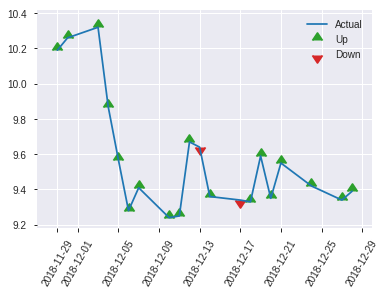


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.23454628719454138
RMSE: 0.4842997906199644
LogLoss: 0.7504485332261496
Mean Per-Class Error: 0.30772161544323096
AUC: 0.7371729743459488
pr_auc: 0.736095750145399
Gini: 0.4743459486918975
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5215425107046656: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      75   49   0.3952   (49.0/124.0)
1      28   99   0.2205   (28.0/127.0)
Total  103  148  0.3068   (77.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.521543     0.72      147
max f2                       0.00835202   0.842175  245
max f0point5                 0.743813     0.702703  106
max accuracy                 0.525662     0.693227  145
max precision                0.999993     1         0
max recall                   0.00835202   1         245
max specificity              0.999993     1         0
max absolute_mcc             0.521543     0.390669  147
max min_per_class_accuracy   0.626067     0.677419  126
max mean_per_class_accuracy  0.525662     0.692278  145

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 57.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.999375           1.97638   1.97638            1                0.999758   1                           0.999758            0.023622        0.023622                   97.6378   97.6378
    2        0.0239044                   0.996314           1.97638   1.97638            1                0.997799   1                           0.998779            0.023622        0.0472441                  97.6378   97.6378
    3        0.0318725                   0.99435            1.97638   1.97638            1                0.995219   1                           0.997889            0.015748        0.0629921                  97.6378   97.6378
    4        0.0438247                   0.992708           1.31759   1.79671            0.666667         0.993646   0.909091                    0.996732            0.015748        0.0787402                  31.7585   79.6707
    5        0.0517928                   0.991237           1.97638   1.82435            1                0.991835   0.923077                    0.995978            0.015748        0.0944882                  97.6378   82.4349
    6        0.103586                    0.978923           1.52029   1.67232            0.769231         0.983535   0.846154                    0.989757            0.0787402       0.173228                   52.0291   67.232
    7        0.151394                    0.965359           1.31759   1.5603             0.666667         0.97139    0.789474                    0.983957            0.0629921       0.23622                    31.7585   56.0298
    8        0.203187                    0.928941           1.52029   1.5501             0.769231         0.948298   0.784314                    0.974867            0.0787402       0.314961                   52.0291   55.01
    9        0.302789                    0.864971           1.26488   1.45628            0.64             0.90578    0.736842                    0.952141            0.125984        0.440945                   26.4882   45.6278
    10       0.40239                     0.776552           1.34394   1.42847            0.68             0.825959   0.722772                    0.920908            0.133858        0.574803                   34.3937   42.8471
    11       0.501992                    0.626337           1.02772   1.34896            0.52             0.703273   0.68254                     0.877726            0.102362        0.677165                   2.77165   34.8956
    12       0.601594                    0.495437           1.02772   1.29577            0.52             0.562526   0.655629                    0.825541            0.102362        0.779528                   2.77165   29.5771
    13       0.701195                    0.33793            0.632441  1.20155            0.32             0.410099   0.607955                    0.766529            0.0629921       0.84252                    -36.7559  20.1548
    14       0.800797                    0.171634           0.869606  1.16026            0.44             0.238356   0.587065                    0.700836            0.0866142       0.929134                   -13.0394  16.0262
    15       0.900398                    0.0469998          0.237165  1.05815            0.12             0.112701   0.535398                    0.635777            0.023622        0.952756                   -76.2835  5.81493
    16       1                           0.000364272        0.474331  1                  0.24             0.0206428  0.505976                    0.

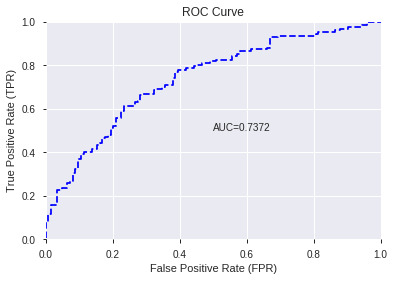

This function is available for GLM models only


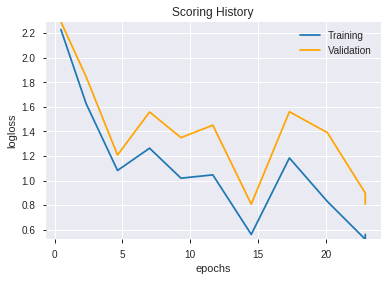

--2019-08-26 20:57:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.0.248
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.0.248|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


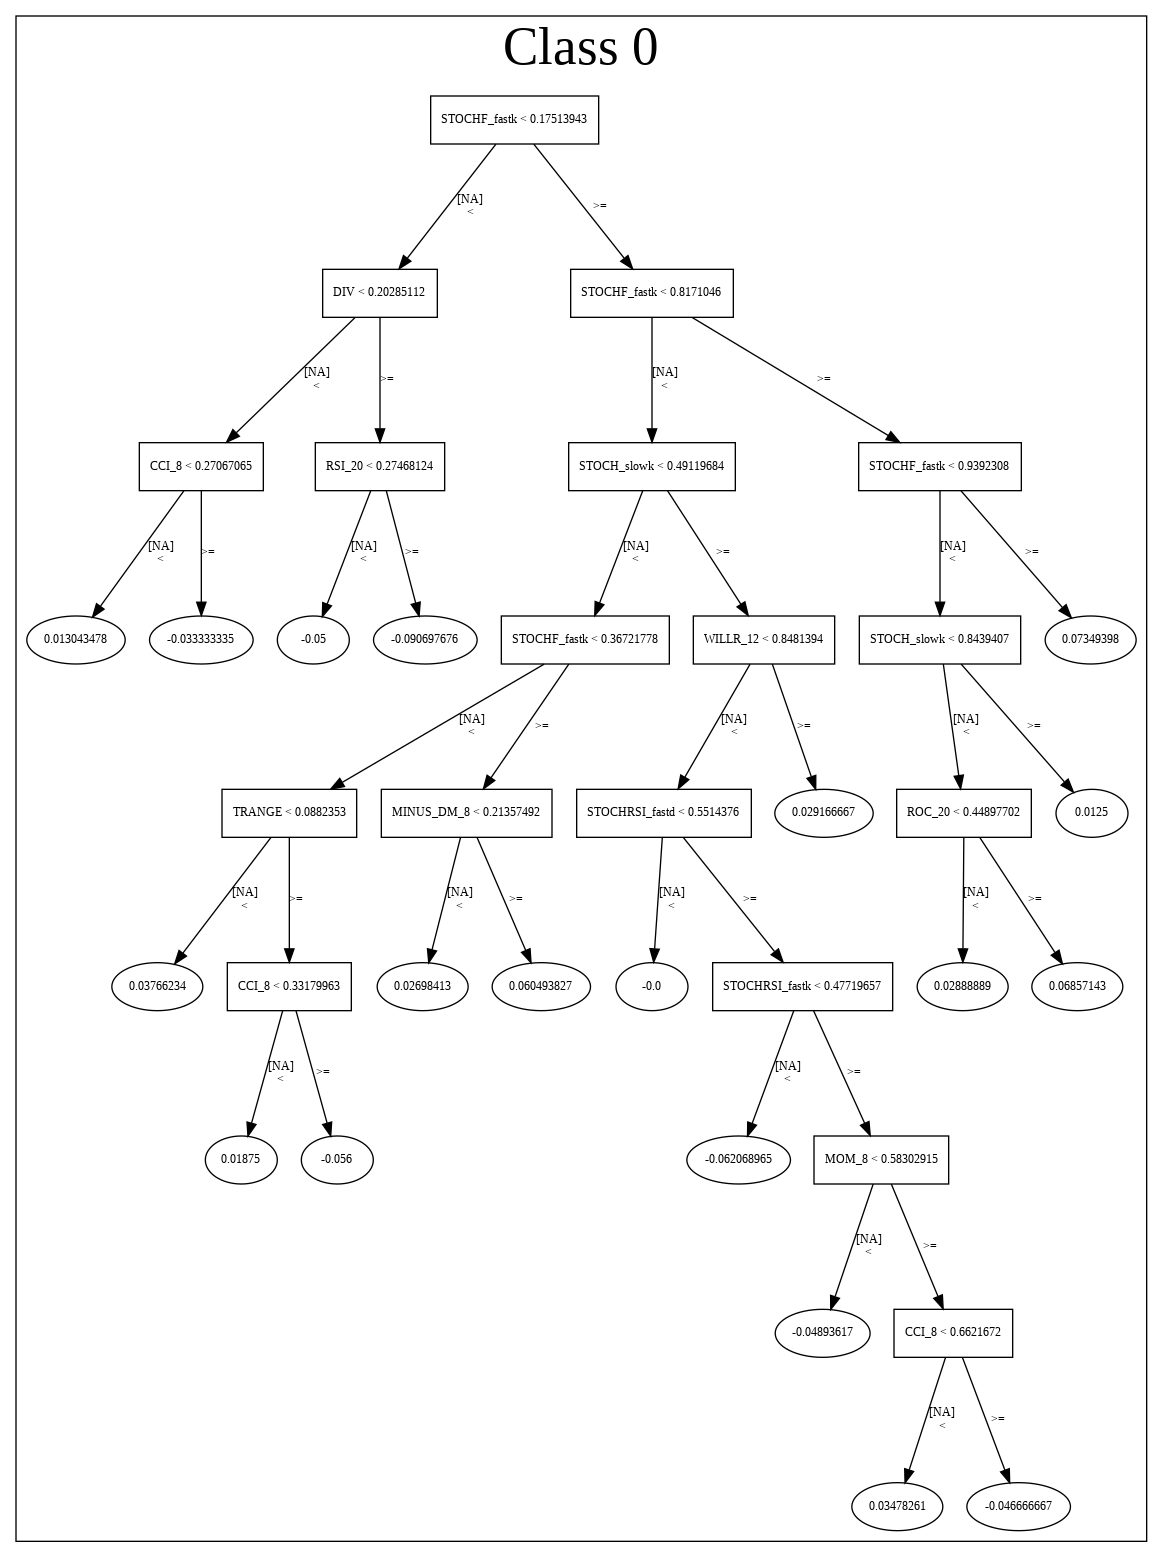

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_203717_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_203717_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_8650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLPIERCING',
 'CDL3WHITESOLDIERS',
 'CDLEVENINGSTAR',
 'CDLSTALLEDPATTERN',
 'CDLONNECK',
 'CDLSTICKSANDWICH',
 'CDL2CROWS',
 'CDLHIKKAKEMOD',
 'CDL3LINESTRIKE',
 'CDLLADDERBOTTOM',
 'CDLMORNINGDOJISTAR',
 'CDLTASUKIGAP',
 'CDLGAPSIDESIDEWHITE',
 'CDLSEPARATINGLINES',
 'CDL3INSIDE',
 'TRANGE',
 'CDLMORNINGSTAR',
 'CDLADVANCEBLOCK',
 'CDLTHRUSTING',
 'CDLXSIDEGAP3METHODS',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLGRAVESTONEDOJI',
 'CDLDARKCLOUDCOVER',
 'CDLSHOOTINGSTAR',
 'CDLCLOSINGMARUBOZU',
 'CDLHANGINGMAN',
 'CDLHAMMER',
 'CDLDOJISTAR',
 'CDLMATCHINGLOW',
 'CDLMARUBOZU',
 'CDLLONGLINE',
 'COSH',
 'HT_TRENDMODE',
 'SINH',
 'CDLHARAMICROSS',
 'STOCHRSI_fastk',
 'EXP',
 'CDLSHORTLINE',
 'BETA_8',
 'CORREL_8',
 'CDLBELTHOLD',
 'CDL3OUTSIDE',
 'CDLSPINNINGTOP',
 'CORREL_12',
 'HT_PHASOR_quadrature',
 'CDLLONGLEGGEDDOJI',
 'CDLHIGHWAVE',
 'OBV',
 'CORREL_30',
 'CDLHARAMI',
 'CDLENGULFING',
 'BETA_12',
 'ADXR_12',
 'BETA_20',
 'aroonup_12',
 'STOCHF_fastk',
 'CORREL_20',
 'ADX_14

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_205752_model_1  0.760668  0.578817              0.333344  0.445469  0.198442

variable  relative_importance  scaled_importance    percentage
0                         BOP             0.445378           1.000000  4.807498e-02
1                      TRANGE             0.325264           0.730309  3.510960e-02
2          CDLCLOSINGMARUBOZU             0.170603           0.383052  1.841520e-02
3                      ULTOSC             0.144566           0.324592  1.560475e-02
4                STOCHF_fastk             0.121164           0.272048  1.307870e-02
..                        ...                  ...                ...           ...
664  BBANDS_middleband_14_4_2             0.000012           0.000027  1.282084e-06
665  BBANDS_middleband_30_5_5             0.000012           0.000026  1.260008e-06
666  BBANDS_middleband_30_5_4             0.000008           0.000019  9.094438e-07
667   BBANDS_lowerband_30_1_2             0.000007           0.000016  7.747866e-07
668  BBANDS_middleband_30_5_3             0.000001           0.000003  1.222777e-07

[669 rows x 4 columns]

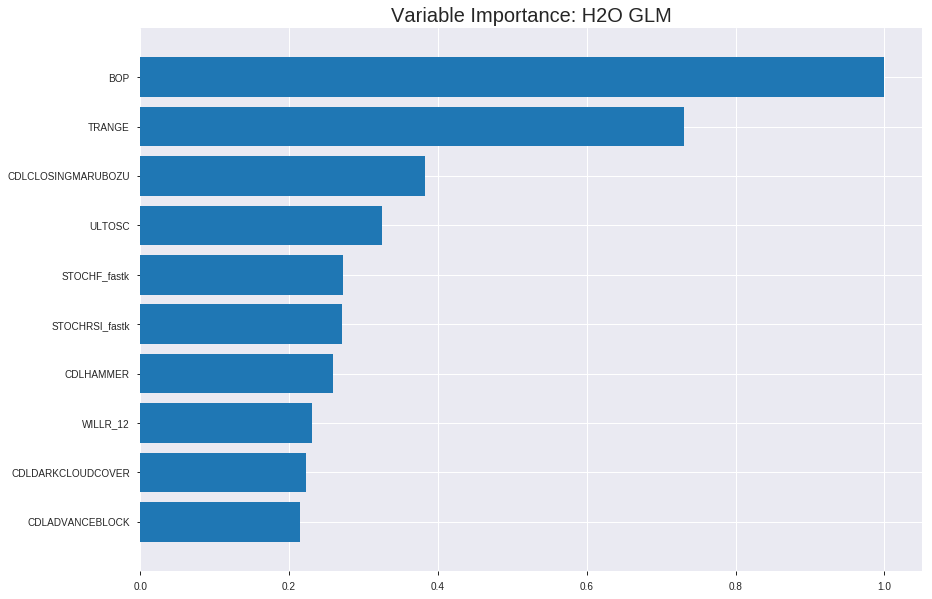

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_205752_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18232673682545053
RMSE: 0.4269973499044819
LogLoss: 0.5447059543089181
Null degrees of freedom: 1752
Residual degrees of freedom: 1083
Null deviance: 2429.6257833865593
Residual deviance: 1909.739075807067
AIC: 3249.739075807067
AUC: 0.8033774211861272
pr_auc: 0.7889588494487438
Gini: 0.6067548423722544
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4156024560913377: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      516  345   0.4007   (345.0/861.0)
1      135  757   0.1513   (135.0/892.0)
Total  651  1102  0.2738   (480.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.415602     0.759278  239
max f2                       0.227477     0.85167   327
max f0point5                 0.582076     0.747449  161
max accuracy                 0.509436     0.735311  194
max precision                0.990015     1         0
max recall                   0.0899463    1         382
max specificity              0.990015     1         0
max absolute_mcc             0.509436     0.470403  194
max min_per_class_accuracy   0.522031     0.730942  189
max mean_per_class_accuracy  0.509436     0.735168  194

Gains/Lift Table: Avg response rate: 50.88 %, avg score: 50.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.907614           1.74689   1.74689            0.888889         0.928294  0.888889                    0.928294            0.0179372       0.0179372                  74.6886   74.6886
    2        0.0205362                   0.887104           1.85607   1.80148            0.944444         0.895884  0.916667                    0.912089            0.0190583       0.0369955                  85.6066   80.1476
    3        0.0302339                   0.871857           1.84964   1.81693            0.941176         0.879427  0.924528                    0.901613            0.0179372       0.0549327                  84.9644   81.6926
    4        0.040502                    0.860384           1.52853   1.74381            0.777778         0.866531  0.887324                    0.892719            0.0156951       0.0706278                  52.8525   74.381
    5        0.0501997                   0.84429            1.73404   1.74192            0.882353         0.851626  0.886364                    0.88478             0.0168161       0.0874439                  73.4041   74.1923
    6        0.100399                    0.800775           1.74192   1.74192            0.886364         0.822795  0.886364                    0.853787            0.0874439       0.174888                   74.1923   74.1923
    7        0.150029                    0.767812           1.60382   1.69624            0.816092         0.785081  0.863118                    0.831059            0.0795964       0.254484                   60.3822   69.6239
    8        0.200228                    0.734222           1.54093   1.6573             0.784091         0.750036  0.843305                    0.810746            0.0773543       0.331839                   54.0932   65.7302
    9        0.300057                    0.668583           1.54974   1.62152            0.788571         0.700944  0.825095                    0.774215            0.154709        0.486547                   54.9737   62.1515
    10       0.399886                    0.601784           1.30268   1.54192            0.662857         0.635576  0.784593                    0.739604            0.130045        0.616592                   30.2678   54.192
    11       0.500285                    0.52198            1.12778   1.45881            0.573864         0.564076  0.742303                    0.704379            0.113229        0.729821                   12.7784   45.8809
    12       0.600114                    0.431488           0.932088  1.37119            0.474286         0.476399  0.697719                    0.666454            0.0930493       0.82287                    -6.79116  37.1189
    13       0.699943                    0.360483           0.685029  1.27333            0.348571         0.396904  0.647922                    0.62801             0.0683857       0.891256                   -31.4971  27.3326
    14       0.799772                    0.28652            0.527809  1.18027            0.268571         0.322881  0.600571                    0.589923            0.0526906       0.943946                   -47.2191  18.0269
    15       0.899601                    0.192677           0.348129  1.08793            0.177143         0.240974  0.553583                    0.5512              0.0347534       0.9787                     -65.1871  8.79266
    16       1                           0.0256613          0.212157  1                  0.107955         0.129302  0.508842                    0.508842           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1977231526873004
RMSE: 0.4446607163751936
LogLoss: 0.5805984104970537
Null degrees of freedom: 500
Residual degrees of freedom: -169
Null deviance: 693.5229098211739
Residual deviance: 581.7596073180479
AIC: 1921.759607318048
AUC: 0.7609478536444828
pr_auc: 0.7494425568544679
Gini: 0.5218957072889656
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4114817858600184: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      113  121  0.5171   (121.0/234.0)
1      33   234  0.1236   (33.0/267.0)
Total  146  355  0.3074   (154.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.411482     0.752412  273
max f2                       0.281252     0.86126   334
max f0point5                 0.609399     0.725735  163
max accuracy                 0.547972     0.702595  196
max precision                0.886887     0.916667  9
max recall                   0.091171     1         389
max specificity              0.940615     0.995726  0
max absolute_mcc             0.547972     0.40472   196
max min_per_class_accuracy   0.547972     0.700375  196
max mean_per_class_accuracy  0.547972     0.702751  196

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 53.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.903107           1.56367   1.56367            0.833333         0.91294   0.833333                    0.91294             0.0187266       0.0187266                  56.367    56.367
    2        0.0219561                   0.888576           1.8764    1.70582            1                0.896169  0.909091                    0.905317            0.0187266       0.0374532                  87.6404   70.5822
    3        0.0319361                   0.878668           0.750562  1.4073             0.4              0.883318  0.75                        0.898442            0.00749064      0.0449438                  -24.9438  40.7303
    4        0.0419162                   0.860195           1.50112   1.42964            0.8              0.867688  0.761905                    0.891119            0.0149813       0.0599251                  50.1124   42.9642
    5        0.0518962                   0.851339           1.50112   1.44339            0.8              0.854588  0.769231                    0.884094            0.0149813       0.0749064                  50.1124   44.3388
    6        0.101796                    0.81265            1.65124   1.54527            0.88             0.827832  0.823529                    0.856514            0.082397        0.157303                   65.1236   54.5274
    7        0.151697                    0.783102           1.65124   1.58013            0.88             0.80147   0.842105                    0.838408            0.082397        0.2397                     65.1236   58.013
    8        0.201597                    0.746153           1.57618   1.57915            0.84             0.764238  0.841584                    0.820049            0.0786517       0.318352                   57.618    57.9152
    9        0.301397                    0.681429           1.27596   1.47876            0.68             0.714778  0.788079                    0.785191            0.127341        0.445693                   27.5955   47.8756
    10       0.401198                    0.619435           1.35101   1.44698            0.72             0.646827  0.771144                    0.750772            0.134831        0.580524                   35.1011   44.6979
    11       0.500998                    0.557506           1.01326   1.36058            0.54             0.59525   0.7251                      0.719791            0.101124        0.681648                   1.32584   36.058
    12       0.600798                    0.475204           0.78809   1.26548            0.42             0.512235  0.674419                    0.685314            0.0786517       0.7603                     -21.191   26.5482
    13       0.700599                    0.420122           1.05079   1.2349             0.56             0.449474  0.65812                     0.651718            0.104869        0.865169                   5.07865   23.4899
    14       0.800399                    0.33208            0.600449  1.15579            0.32             0.37177   0.61596                     0.616812            0.0599251       0.925094                   -39.9551  15.579
    15       0.9002                      0.224674           0.525393  1.0859             0.28             0.277892  0.578714                    0.579238            0.0524345       0.977528                   -47.4607  8.59015
    16       1                           0.00234001         0.225169  1                  0.12             0.144687  0.532934                    0.535869            0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-26 20:57:54  0.000 sec   2            .22E2     660           1.3584811140780424  1.3534653930989506
     2019-08-26 20:57:55  0.850 sec   4            .16E2     660           1.35137357982747    1.346373110636561
     2019-08-26 20:57:56  1.703 sec   6            .12E2     670           1.3427370667177547  1.3380964622861227
     2019-08-26 20:57:57  2.553 sec   8            .84E1     670           1.3323451517652602  1.3283619841129497
     2019-08-26 20:57:57  3.423 sec   10           .61E1     670           1.3200029883286026  1.3170896700706598
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-26 20:58:11  17.206 sec  42           .38E-1    670           1.0812889756617141  1.162074919200822
     2019-08-26 20:58:12  18.065 sec  44           .28E-1    670           1.0738169959677952  1.1642270905410395
     2019-08-26 20:58:13  18.955 sec  46           .2E-1     670           1.066873694803225   1.167649793355998
     2019-08-26 20:58:14  19.829 sec  48           .15E-1    670           1.0603653577259105  1.1723797035035644
     2019-08-26 20:58:15  20.691 sec  50           .11E-1    670           1.0542109986685244  1.1784764333798128


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7051792828685259)

('F1', 0.7313915857605178)

('auc', 0.7606680213360426)

('logloss', 0.5788168603740526)

('mean_per_class_error', 0.2946723393446786)

('rmse', 0.4454685284489461)

('mse', 0.1984422098384695)

glm prediction progress: |████████████████████████████████████████████████| 100%


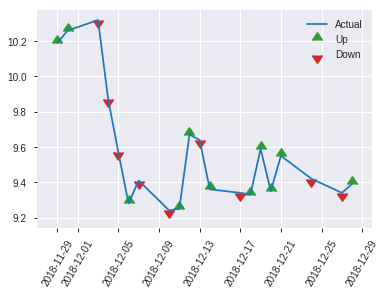


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1984422098384695
RMSE: 0.4454685284489461
LogLoss: 0.5788168603740526
Null degrees of freedom: 250
Residual degrees of freedom: -419
Null deviance: 347.9322754570597
Residual deviance: 290.5660639077744
AIC: 1630.5660639077744
AUC: 0.7606680213360426
pr_auc: 0.7504534610523975
Gini: 0.5213360426720852
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3448024287881235: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      55   69   0.5565   (69.0/124.0)
1      14   113  0.1102   (14.0/127.0)
Total  69   182  0.3307   (83.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.344802     0.731392  181
max f2                       0.222158     0.852982  212
max f0point5                 0.497673     0.710824  122
max accuracy                 0.497673     0.705179  122
max precision                0.919817     1         0
max recall                   0.115825     1         240
max specificity              0.919817     1         0
max absolute_mcc             0.497673     0.410707  122
max min_per_class_accuracy   0.48313      0.693548  126
max mean_per_class_accuracy  0.497673     0.705328  122

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 48.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.895509           1.97638   1.97638            1                0.907294  1                           0.907294            0.023622        0.023622                   97.6378   97.6378
    2        0.0239044                   0.86325            1.97638   1.97638            1                0.875517  1                           0.891405            0.023622        0.0472441                  97.6378   97.6378
    3        0.0318725                   0.857551           0.988189  1.72933            0.5              0.858574  0.875                       0.883198            0.00787402      0.0551181                  -1.1811   72.9331
    4        0.0438247                   0.848109           1.97638   1.79671            1                0.851194  0.909091                    0.874469            0.023622        0.0787402                  97.6378   79.6707
    5        0.0517928                   0.832515           1.97638   1.82435            1                0.836128  0.923077                    0.868571            0.015748        0.0944882                  97.6378   82.4349
    6        0.103586                    0.779719           1.82435   1.82435            0.923077         0.806064  0.923077                    0.837318            0.0944882       0.188976                   82.4349   82.4349
    7        0.151394                    0.745737           1.31759   1.66432            0.666667         0.761954  0.842105                    0.813518            0.0629921       0.251969                   31.7585   66.4318
    8        0.203187                    0.69832            1.52029   1.62761            0.769231         0.720589  0.823529                    0.789831            0.0787402       0.330709                   52.0291   62.7605
    9        0.302789                    0.643515           1.18583   1.48228            0.6              0.666012  0.75                        0.749101            0.11811         0.448819                   18.5827   48.2283
    10       0.40239                     0.562357           1.34394   1.44804            0.68             0.607023  0.732673                    0.713933            0.133858        0.582677                   34.3937   44.8039
    11       0.501992                    0.489542           1.10677   1.38033            0.56             0.526281  0.698413                    0.6767              0.110236        0.692913                   10.6772   38.0327
    12       0.601594                    0.41958            0.948661  1.30886            0.48             0.456515  0.662252                    0.640246            0.0944882       0.787402                   -5.13386  30.886
    13       0.701195                    0.35376            0.790551  1.23524            0.4              0.37939   0.625                       0.603192            0.0787402       0.866142                   -20.9449  23.5236
    14       0.800797                    0.248033           0.474331  1.1406             0.24             0.301791  0.577114                    0.565705            0.0472441       0.913386                   -52.5669  14.0596
    15       0.900398                    0.178921           0.632441  1.08438            0.32             0.216124  0.548673                    0.527034            0.0629921       0.976378                   -36.7559  8.43844
    16       1                           0.023777           0.237165  1                  0.12             0.117825  0.505976                    0.486277          

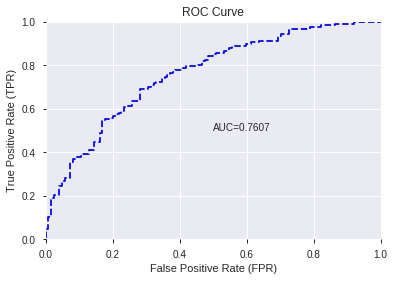

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


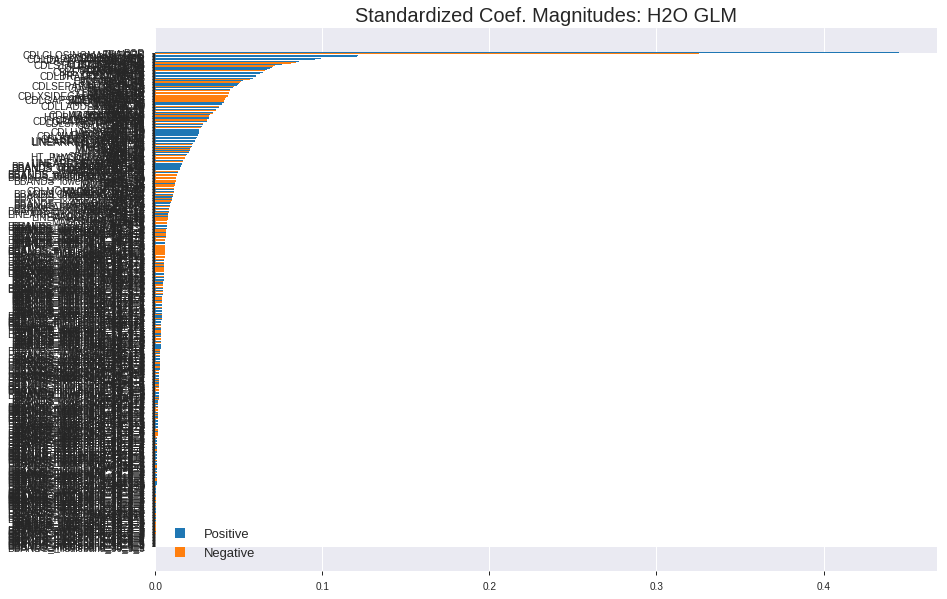

'log_likelihood'
--2019-08-26 20:58:31--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.176.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.176.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


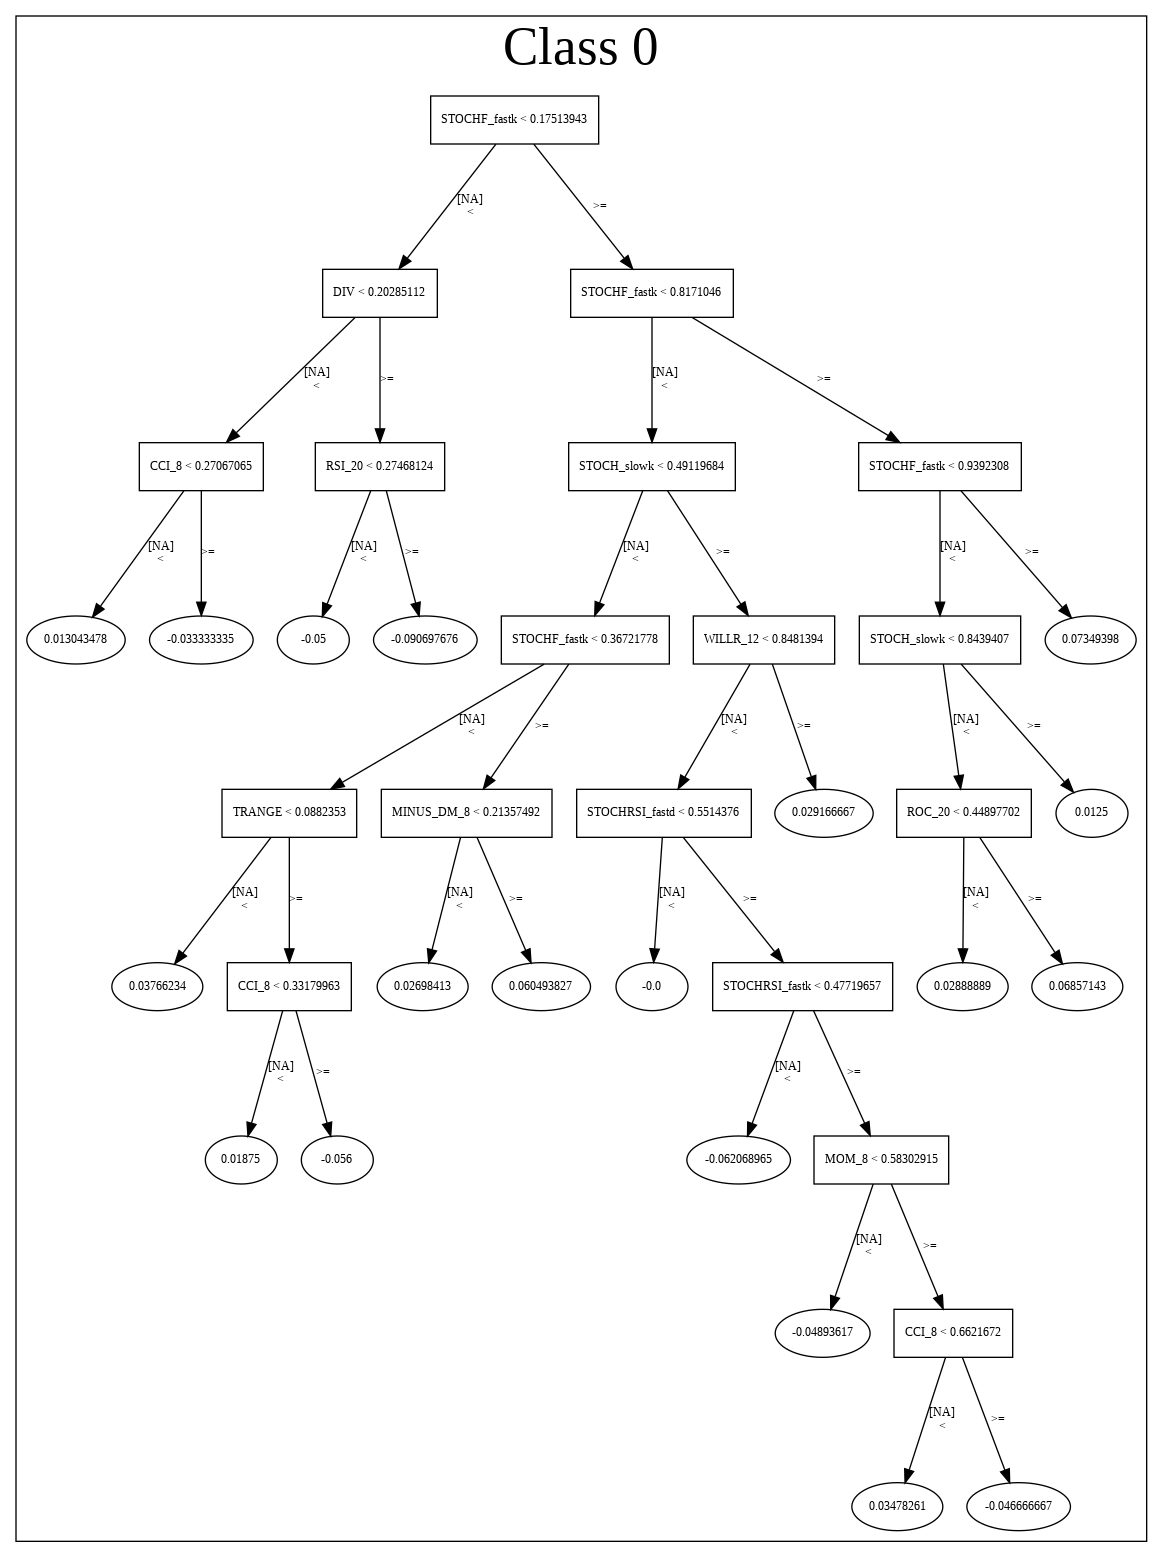

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_205752_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_205752_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_8650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'CDLCLOSINGMARUBOZU',
 'ULTOSC',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'CDLHAMMER',
 'WILLR_12',
 'CDLDARKCLOUDCOVER',
 'CDLADVANCEBLOCK',
 'WILLR_8',
 'CCI_8',
 'ADOSC',
 'STOCHF_fastd',
 'STOCH_slowk',
 'CDLTHRUSTING',
 'CDLSTALLEDPATTERN',
 'CCI_30',
 'WILLR_14',
 'BETA_12',
 'CDLHIKKAKEMOD',
 'CORREL_24',
 'STOCH_slowd',
 'CDL3INSIDE',
 'aroonup_12',
 'RSI_8',
 'CDLEVENINGSTAR',
 'CMO_8',
 'HT_TRENDMODE',
 'MFI_8',
 'CDLONNECK',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'DX_8',
 'aroondown_24',
 'ADX_24',
 'ADXR_12',
 'CDLLONGLINE',
 'WILLR_24',
 'BETA_8',
 'BETA_24',
 'COS',
 'MINUS_DM_8',
 'MFI_20',
 'CDLSEPARATINGLINES',
 'PLUS_DI_14',
 'PLUS_DI_12',
 'CDLSHORTLINE',
 'PLUS_DI_20',
 'MINUS_DI_8',
 'SAR_0.2',
 'aroonup_14',
 'SIN',
 'RSI_12',
 'CDLDOJISTAR',
 'PLUS_DM_8',
 'CMO_12',
 'aroondown_30',
 'CDLXSIDEGAP3METHODS',
 'CORREL_14',
 'PLUS_DI_24',
 'PLUS_DI_8',
 'CDLTASUKIGAP',
 'CDLGAPSIDESIDEWHITE',
 'CDLHIGHWAVE',
 'AROONOSC_12',
 'ADX_8',
 'BETA_20',
 'aroonu

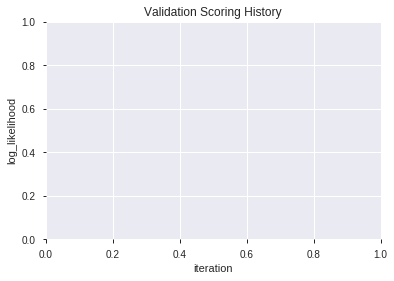

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_205844_model_5  0.753747  0.588192              0.313468  0.449466  0.202020
1  XGBoost_grid_1_AutoML_20190826_205844_model_2  0.748857  0.588926              0.280163  0.448583  0.201227
2  XGBoost_grid_1_AutoML_20190826_205844_model_6  0.742697  0.594666              0.300514  0.452062  0.204360
3  XGBoost_grid_1_AutoML_20190826_205844_model_7  0.741808  0.598093              0.292069  0.453299  0.205480
4  XGBoost_grid_1_AutoML_20190826_205844_model_1  0.739332  0.594622              0.280544  0.450906  0.203316
5  XGBoost_grid_1_AutoML_20190826_205844_model_3  0.739141  0.600209              0.353981  0.454388  0.206469
6               XGBoost_1_AutoML_20190826_205844  0.737998  0.597363              0.275654  0.451809  0.204131
7  XGBoost_grid_1_AutoML_20190826_205844_model_4  0.737871  0.598677              0.292259  0.452270  0.204548
8               XGBoost_3_AutoML_20190826_205844  0.735903  0.600202              0.297054  0.453805  0.205939
9               XGBoost_2_AutoML_20190826_205844  0.732791  0.601984              0.309341  0.454689  0.206742

variable  relative_importance  scaled_importance  percentage
0                         BOP          2061.447998           1.000000    0.077714
1                      TRANGE           621.228516           0.301355    0.023420
2                STOCHF_fastk           514.908508           0.249780    0.019411
3                     MA_12_0           443.204987           0.214997    0.016708
4                    CORREL_8           327.906097           0.159066    0.012362
..                        ...                  ...                ...         ...
510   BBANDS_lowerband_14_5_3             0.478824           0.000232    0.000018
511  BBANDS_middleband_12_1_5             0.415814           0.000202    0.000016
512   BBANDS_lowerband_12_6_3             0.250667           0.000122    0.000009
513   BBANDS_upperband_12_7_2             0.208284           0.000101    0.000008
514                   MA_24_3             0.065081           0.000032    0.000002

[515 rows x 4 columns]

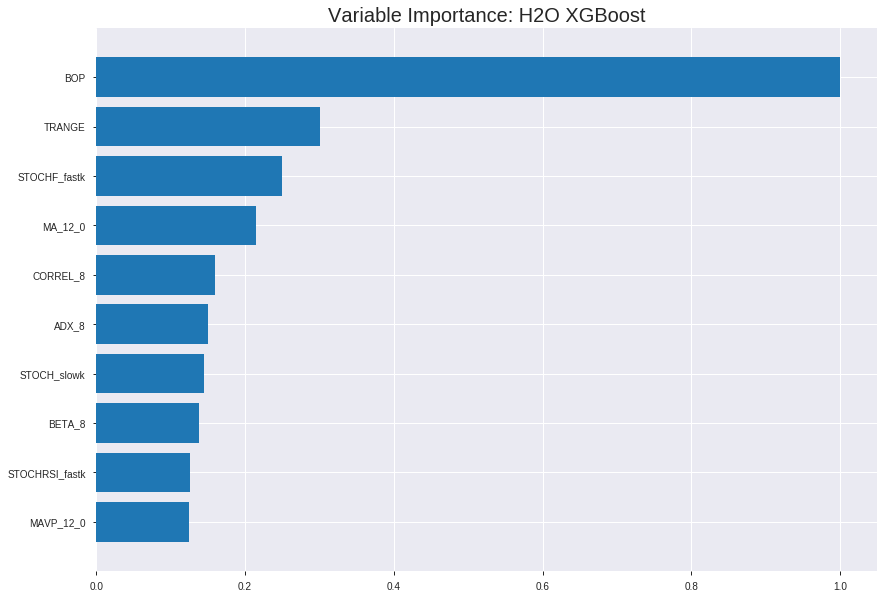

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_205844_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.019229198043284754
RMSE: 0.13866938394355385
LogLoss: 0.1317721934111531
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9988789237668162
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5886442065238953: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      861  0    0        (0.0/861.0)
1      0    892  0        (0.0/892.0)
Total  861  892  0        (0.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.588644     1        200
max f2                       0.588644     1        200
max f0point5                 0.588644     1        200
max accuracy                 0.588644     1        200
max precision                0.971246     1        0
max recall                   0.588644     1        200
max specificity              0.971246     1        0
max absolute_mcc             0.588644     1        200
max min_per_class_accuracy   0.588644     1        200
max mean_per_class_accuracy  0.588644     1        200

Gains/Lift Table: Avg response rate: 50.88 %, avg score: 50.93 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0102681                   0.961045           1.96525  1.96525            1                0.964238   1                           0.964238            0.0201794       0.0201794                  96.5247  96.5247
    2        0.0205362                   0.957203           1.96525  1.96525            1                0.958841   1                           0.961539            0.0201794       0.0403587                  96.5247  96.5247
    3        0.0302339                   0.95312            1.96525  1.96525            1                0.954686   1                           0.959341            0.0190583       0.059417                   96.5247  96.5247
    4        0.040502                    0.950581           1.96525  1.96525            1                0.951866   1                           0.957446            0.0201794       0.0795964                  96.5247  96.5247
    5        0.0501997                   0.948461           1.96525  1.96525            1                0.949505   1                           0.955912            0.0190583       0.0986547                  96.5247  96.5247
    6        0.100399                    0.938369           1.96525  1.96525            1                0.942978   1                           0.949445            0.0986547       0.197309                   96.5247  96.5247
    7        0.150029                    0.927769           1.96525  1.96525            1                0.93263    1                           0.943883            0.0975336       0.294843                   96.5247  96.5247
    8        0.200228                    0.915809           1.96525  1.96525            1                0.921839   1                           0.938356            0.0986547       0.393498                   96.5247  96.5247
    9        0.300057                    0.885591           1.96525  1.96525            1                0.900762   1                           0.925848            0.196188        0.589686                   96.5247  96.5247
    10       0.399886                    0.838319           1.96525  1.96525            1                0.864324   1                           0.910489            0.196188        0.785874                   96.5247  96.5247
    11       0.500285                    0.703197           1.96525  1.96525            1                0.787832   1                           0.885874            0.197309        0.983184                   96.5247  96.5247
    12       0.600114                    0.181722           0.16845  1.66635            0.0857143        0.276292   0.847909                    0.78447             0.0168161       1                          -83.155  66.635
    13       0.699943                    0.127409           0        1.42869            0                0.152198   0.726976                    0.694293            0               1                          -100     42.8688
    14       0.799772                    0.0903565          0        1.25036            0                0.106527   0.636234                    0.620927            0               1                          -100     25.0357
    15       0.899601                    0.0646563          0        1.1116             0                0.0778367  0.565631                    0.56066             0               1                          -100     11.1604
    16       1                           0.0255328          0        1                  0                0.0490119  0.508842                    0.509291            0              



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.21633027017686782
RMSE: 0.4651131799646918
LogLoss: 0.6282188861732564
Mean Per-Class Error: 0.3179919331604725
AUC: 0.7148116136880183
pr_auc: 0.7034190635225196
Gini: 0.42962322737603653
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39446258544921875: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      110  124  0.5299   (124.0/234.0)
1      35   232  0.1311   (35.0/267.0)
Total  145  356  0.3174   (159.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.394463     0.744783  275
max f2                       0.19205      0.855007  370
max f0point5                 0.443859     0.697749  246
max accuracy                 0.443859     0.690619  246
max precision                0.95448      1         0
max recall                   0.0708784    1         396
max specificity              0.95448      1         0
max absolute_mcc             0.443859     0.378992  246
max min_per_class_accuracy   0.546781     0.662393  197
max mean_per_class_accuracy  0.443859     0.682008  246

Gains/Lift Table: Avg response rate: 53.29 %, avg score: 54.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.928491           1.56367   1.56367            0.833333         0.940684  0.833333                    0.940684            0.0187266       0.0187266                  56.367    56.367
    2        0.0219561                   0.91641            1.50112   1.53524            0.8              0.921934  0.818182                    0.932161            0.0149813       0.0337079                  50.1124   53.524
    3        0.0319361                   0.909898           1.50112   1.52458            0.8              0.91406   0.8125                      0.926505            0.0149813       0.0486891                  50.1124   52.4579
    4        0.0419162                   0.894202           1.8764    1.60835            1                0.898853  0.857143                    0.919921            0.0187266       0.0674157                  87.6404   60.8347
    5        0.0518962                   0.89011            1.12584   1.51556            0.6              0.891839  0.807692                    0.914521            0.011236        0.0786517                  12.5843   51.5557
    6        0.101796                    0.848918           1.42607   1.47169            0.76             0.867249  0.784314                    0.891349            0.071161        0.149813                   42.6067   47.169
    7        0.151697                    0.812547           1.12584   1.35792            0.6              0.832364  0.723684                    0.871946            0.0561798       0.205993                   12.5843   35.7924
    8        0.201597                    0.76629            1.35101   1.35621            0.72             0.792914  0.722772                    0.852383            0.0674157       0.273408                   35.1011   35.6213
    9        0.301397                    0.679781           1.31348   1.34206            0.7              0.71489   0.715232                    0.806856            0.131086        0.404494                   31.3483   34.2064
    10       0.401198                    0.613077           1.31348   1.33495            0.7              0.644232  0.711443                    0.766402            0.131086        0.535581                   31.3483   33.4954
    11       0.500998                    0.556385           1.12584   1.2933             0.6              0.580311  0.689243                    0.729332            0.11236         0.64794                    12.5843   29.3299
    12       0.600798                    0.490164           1.01326   1.24678            0.54             0.523922  0.664452                    0.695211            0.101124        0.749064                   1.32584   24.678
    13       0.700599                    0.406177           1.01326   1.21352            0.54             0.440927  0.646724                    0.658988            0.101124        0.850187                   1.32584   21.3515
    14       0.800399                    0.328368           0.600449  1.13707            0.32             0.364969  0.605985                    0.622327            0.0599251       0.910112                   -39.9551  13.7073
    15       0.9002                      0.235156           0.525393  1.06926            0.28             0.282259  0.569845                    0.584626            0.0524345       0.962547                   -47.4607  6.92593
    16       1                           0.053588           0.375281  1                  0.2              0.158322  0.532934                    0.54208             0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 20:59:10  13.917 sec  0                  0.5              0.693147            0.5             0                  1                0.491158                         0.5                0.693147              0.5               0                    1                  0.467066
    2019-08-26 20:59:11  15.025 sec  5                  0.435276         0.570764            0.977106        0.973607           1.96525          0.074729                         0.491063           0.675281              0.616361          0.624416             1.25094            0.441118
    2019-08-26 20:59:12  15.609 sec  10                 0.381134         0.477401            0.994371        0.990053           1.96525          0.0347975                        0.484437           0.66199               0.64698           0.643635             1.25094            0.389222
    2019-08-26 20:59:12  16.164 sec  15                 0.339636         0.410177            0.998186        0.995939           1.96525          0.0182544                        0.481987           0.657071              0.65455           0.642161             1.25094            0.387226
    2019-08-26 20:59:13  16.732 sec  20                 0.303366         0.353984            0.999307        0.99821            1.96525          0.011409                         0.476638           0.646208              0.674629          0.661576             1.25094            0.355289
    2019-08-26 20:59:13  17.328 sec  25                 0.272187         0.307821            0.999788        0.996433           1.96525          0.00684541                       0.474604           0.641911              0.678111          0.670246             1.25094            0.353293
    2019-08-26 20:59:14  17.934 sec  30                 0.247426         0.272278            0.999893        0.998777           1.96525          0.00513406                       0.472044           0.63692               0.687186          0.67551              1.25094            0.331337
    2019-08-26 20:59:15  18.526 sec  35                 0.224818         0.240753            0.999963        0.997722           1.96525          0.00285225                       0.470046           0.633122              0.69382           0.682207             1.56367            0.319361
    2019-08-26 20:59:15  19.094 sec  40                 0.207251         0.216662            0.999975        0.997734           1.96525          0.0022818                        0.46882            0.631043              0.69799           0.684955             1.25094            0.331337
    2019-08-26 20:59:16  19.725 sec  45                 0.189292         0.193238            0.999996        0.998875           1.96525          0.000570451                      0.466928           0.628309              0.705648          0.692251             1.56367            0.327345
    2019-08-26 20:59:16  20.355 sec  50                 0.174641         0.174456            1               0.997758           1.96525          0                                0.465827           0.627655              0.709946          0.694095             1.56367            0.339321
    2019-08-26 20:59:17  20.944 sec  55                 0.162717         0.159773            1               0.998879           1.96525          0                                0.463501           0.622996              0.715412          0

Variable Importances: 


variable                  relative_importance    scaled_importance       percentage
------------------------  ---------------------  ----------------------  ----------------------
BOP                       2061.447998046875      1.0                     0.077714172583855
TRANGE                    621.228515625          0.3013554143561151      0.023419586680350265
STOCHF_fastk              514.9085083007812      0.24978001326671        0.019411447059006694
MA_12_0                   443.2049865722656      0.2149969278837892      0.016708308358559423
CORREL_8                  327.9060974121094      0.15906590790686206     0.012361675419281465
---                       ---                    ---                     ---
BBANDS_lowerband_14_5_3   0.4788236618041992     0.00023227540168748478  1.8051090653725436e-05
BBANDS_middleband_12_1_5  0.41581401228904724    0.00020170967818883205  1.5675700742600747e-05
BBANDS_lowerband_12_6_3   0.2506665587425232     0.00012159732332807714  9.449835370853004e-06
BBANDS_upperband_12_7_2   0.2082839012145996     0.00010103766935277475  7.852058873552015e-06
MA_24_3                   0.06508060544729233    3.157033575862847e-05   2.453462521676302e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.701195219123506)

('F1', 0.7483870967741937)

('auc', 0.753746507493015)

('logloss', 0.5881918870331202)

('mean_per_class_error', 0.30003810007620013)

('rmse', 0.4494662982366969)

('mse', 0.20201995325059938)

xgboost prediction progress: |████████████████████████████████████████████| 100%


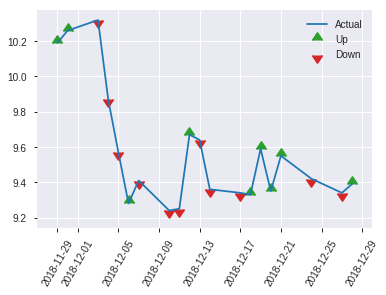


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20201995325059938
RMSE: 0.4494662982366969
LogLoss: 0.5881918870331202
Mean Per-Class Error: 0.30003810007620013
AUC: 0.753746507493015
pr_auc: 0.7252425364878624
Gini: 0.5074930149860299
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29731521010398865: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      57   67   0.5403   (67.0/124.0)
1      11   116  0.0866   (11.0/127.0)
Total  68   183  0.3108   (78.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.297315     0.748387  182
max f2                       0.218607     0.862553  204
max f0point5                 0.464337     0.693878  151
max accuracy                 0.464337     0.701195  151
max precision                0.957516     1         0
max recall                   0.0873065    1         245
max specificity              0.957516     1         0
max absolute_mcc             0.297315     0.419677  182
max min_per_class_accuracy   0.573851     0.677165  125
max mean_per_class_accuracy  0.464337     0.699962  151

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 52.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.928088           1.97638   1.97638            1                0.945662  1                           0.945662            0.023622        0.023622                   97.6378   97.6378
    2        0.0239044                   0.91476            1.31759   1.64698            0.666667         0.917352  0.833333                    0.931507            0.015748        0.0393701                  31.7585   64.6982
    3        0.0318725                   0.886604           1.97638   1.72933            1                0.89501   0.875                       0.922383            0.015748        0.0551181                  97.6378   72.9331
    4        0.0438247                   0.873168           1.97638   1.79671            1                0.876157  0.909091                    0.909776            0.023622        0.0787402                  97.6378   79.6707
    5        0.0517928                   0.864039           1.97638   1.82435            1                0.867915  0.923077                    0.903335            0.015748        0.0944882                  97.6378   82.4349
    6        0.103586                    0.82637            1.21623   1.52029            0.615385         0.842718  0.769231                    0.873027            0.0629921       0.15748                    21.6233   52.0291
    7        0.151394                    0.796318           1.48228   1.50829            0.75             0.810145  0.763158                    0.853169            0.0708661       0.228346                   48.2283   50.8288
    8        0.203187                    0.775456           1.52029   1.51135            0.769231         0.786505  0.764706                    0.836176            0.0787402       0.307087                   52.0291   51.1348
    9        0.302789                    0.722821           1.42299   1.48228            0.72             0.752284  0.75                        0.80858             0.141732        0.448819                   42.2992   48.2283
    10       0.40239                     0.659286           1.26488   1.42847            0.64             0.695234  0.722772                    0.780524            0.125984        0.574803                   26.4882   42.8471
    11       0.501992                    0.573851           1.02772   1.34896            0.52             0.613754  0.68254                     0.747435            0.102362        0.677165                   2.77165   34.8956
    12       0.601594                    0.470944           1.18583   1.32195            0.6              0.516163  0.668874                    0.709145            0.11811         0.795276                   18.5827   32.1948
    13       0.701195                    0.352565           0.869606  1.2577             0.44             0.416705  0.636364                    0.667605            0.0866142       0.88189                    -13.0394  25.7695
    14       0.800797                    0.233941           0.711496  1.18976            0.36             0.279332  0.60199                     0.619312            0.0708661       0.952756                   -28.8504  18.976
    15       0.900398                    0.144237           0.31622   1.09313            0.16             0.186476  0.553097                    0.571432            0.0314961       0.984252                   -68.378   9.31294
    16       1                           0.058452           0.15811   1                  0.08             0.105333  0.505976                    0.525008          

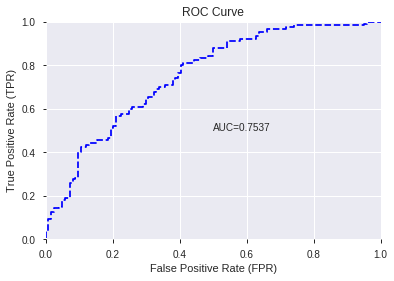

This function is available for GLM models only


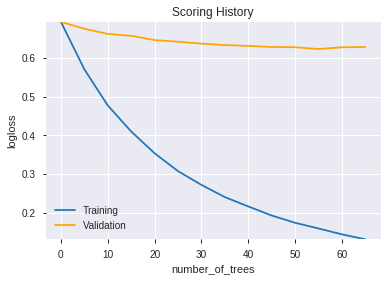

--2019-08-26 20:59:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.205.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.205.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

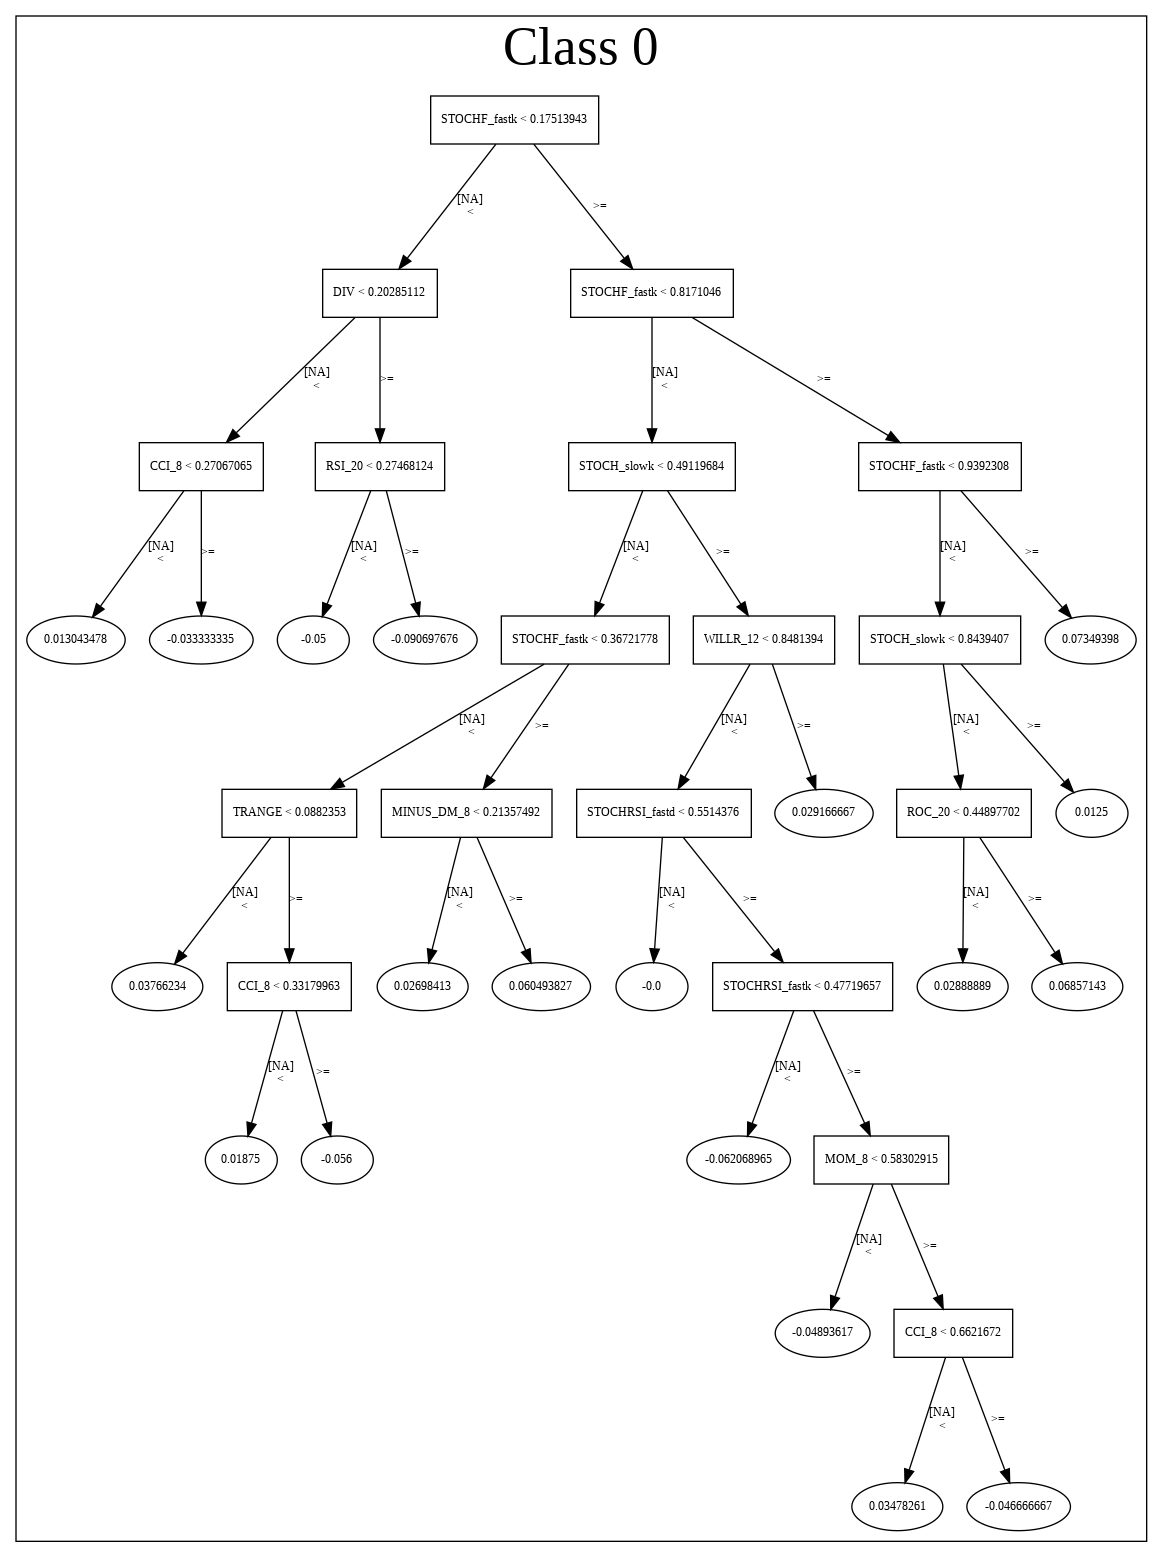

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_205844_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_205844_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_8650',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'MA_12_0',
 'CORREL_8',
 'ADX_8',
 'STOCH_slowk',
 'BETA_8',
 'STOCHRSI_fastk',
 'MAVP_12_0',
 'SIN',
 'WILLR_12',
 'ULTOSC',
 'CCI_12',
 'ADXR_8',
 'STOCH_slowd',
 'CORREL_12',
 'DX_20',
 'MFI_8',
 'CCI_8',
 'HT_DCPERIOD',
 'ADXR_14',
 'CMO_8',
 'ADOSC',
 'BETA_30',
 'DX_8',
 'MINUS_DM_8',
 'BETA_12',
 'WILLR_8',
 'BETA_14',
 'ADXR_12',
 'MACDEXT_hist',
 'BETA_24',
 'COS',
 'HT_PHASOR_inphase',
 'MFI_20',
 'BETA_20',
 'HT_PHASOR_quadrature',
 'MINUS_DI_8',
 'CORREL_14',
 'STOCHRSI_fastd',
 'PLUS_DI_8',
 'MFI_14',
 'ADX_24',
 'MFI_12',
 'PLUS_DM_8',
 'OBV',
 'ROC_8',
 'MFI_30',
 'MOM_8',
 'DX_30',
 'ATR_8',
 'DX_12',
 'CCI_24',
 'AROONOSC_24',
 'ADX_14',
 'BBANDS_upperband_12_0_2',
 'CORREL_30',
 'STDDEV_8',
 'aroonup_8',
 'CDLCLOSINGMARUBOZU',
 'STDDEV_12',
 'ADX_12',
 'MACDFIX_signal_20',
 'ROC_14',
 'MFI_24',
 'CORREL_20',
 'CCI_14',
 'MOM_12',
 'MACDFIX_hist_8',
 'PLUS_DI_20',
 'CORREL_24',
 'ADX_20',
 'AD',
 'aroondown_8',
 'MACDFIX_signal_8',


In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.725
GLM             0.733
XGBoost         0.733
dtype: float64

DeepLearning    GLM  XGBoost
All          0.725  0.733    0.721
DLF          0.709  0.713    0.713
Fwe          0.701  0.717    0.733
RFE          0.693  0.705    0.701
XGBF         0.717  0.713    0.713





F1


DeepLearning    0.756
GLM             0.757
XGBoost         0.756
dtype: float64

DeepLearning    GLM  XGBoost
All          0.745  0.748    0.755
DLF          0.751  0.757    0.749
Fwe          0.756  0.749    0.756
RFE          0.720  0.731    0.748
XGBF         0.753  0.757    0.749





auc


DeepLearning    0.782
GLM             0.780
XGBoost         0.767
dtype: float64

DeepLearning    GLM  XGBoost
All          0.761  0.780    0.758
DLF          0.782  0.772    0.767
Fwe          0.779  0.772    0.767
RFE          0.737  0.761    0.754
XGBF         0.760  0.772    0.767





logloss


DeepLearning    0.750
GLM             0.579
XGBoost         0.588
dtype: float64

DeepLearning    GLM  XGBoost
All          0.584  0.565    0.581
DLF          0.558  0.565    0.576
Fwe          0.563  0.565    0.574
RFE          0.750  0.579    0.588
XGBF         0.652  0.565    0.576





mean_per_class_error


DeepLearning    0.308
GLM             0.295
XGBoost         0.300
dtype: float64

DeepLearning    GLM  XGBoost
All          0.275  0.267    0.278
DLF          0.291  0.288    0.288
Fwe          0.299  0.284    0.268
RFE          0.308  0.295    0.300
XGBF         0.284  0.288    0.288





rmse


DeepLearning    0.484
GLM             0.445
XGBoost         0.449
dtype: float64

DeepLearning    GLM  XGBoost
All          0.447  0.439    0.445
DLF          0.436  0.439    0.442
Fwe          0.438  0.439    0.441
RFE          0.484  0.445    0.449
XGBF         0.456  0.439    0.442





mse


DeepLearning    0.235
GLM             0.198
XGBoost         0.202
dtype: float64

DeepLearning    GLM  XGBoost
All          0.200  0.192    0.198
DLF          0.190  0.192    0.196
Fwe          0.192  0.193    0.195
RFE          0.235  0.198    0.202
XGBF         0.208  0.192    0.196

{'F1':       DeepLearning    GLM  XGBoost
 All          0.745    NaN      NaN
 DLF          0.751    NaN      NaN
 DLF            NaN  0.757      NaN
 DLF            NaN    NaN    0.749
 All            NaN  0.748      NaN
 All            NaN    NaN    0.755
 XGBF         0.753    NaN      NaN
 XGBF           NaN  0.757      NaN
 XGBF           NaN    NaN    0.749
 Fwe          0.756    NaN      NaN
 Fwe            NaN  0.749      NaN
 Fwe            NaN    NaN    0.756
 RFE          0.720    NaN      NaN
 RFE            NaN  0.731      NaN
 RFE            NaN    NaN    0.748,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.725    NaN      NaN
 DLF          0.709    NaN      NaN
 DLF            NaN  0.713      NaN
 DLF            NaN    NaN    0.713
 All            NaN  0.733      NaN
 All            NaN    NaN    0.721
 XGBF         0.717    NaN      NaN
 XGBF           NaN  0.713      NaN
 XGBF           NaN    NaN    0.713
 Fwe          0.701    NaN      NaN
 Fwe     